# XGB

In [24]:
import cudf
import cuml
from cuml.preprocessing import StandardScaler
from cuml.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import ParameterGrid
import numpy as np
import time
import joblib

# Convert pandas DataFrame to cuDF
df_gpu = cudf.DataFrame(df)
X = df_gpu.drop('label', axis=1)
y = df_gpu['label']

# Convert data to float32 for better GPU performance
X = X.astype('float32')
y = y.astype('float32')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the data using GPU
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

# Define parameter grid for XGBoost
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Calculate total combinations
total_combinations = len([p for p in ParameterGrid(param_grid)])
print(f"Total parameter combinations: {total_combinations}")

# Initialize variables
best_score = 0
best_params = None
best_model = None

# Function to format time
def format_time(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return f"{hours:02d}:{minutes:02d}:{seconds:02d}"

# Grid search with progress tracking
start_time = time.time()
for i, params in enumerate(ParameterGrid(param_grid), 1):
    iteration_start = time.time()
    current_time = time.strftime('%H:%M:%S')

    print(f"\nCombination {i}/{total_combinations} at {current_time}")
    print(f"Parameters: {params}")

    # Prepare XGBoost parameters
    xgb_params = {
        'max_depth': params['max_depth'],
        'learning_rate': params['learning_rate'],
        'min_child_weight': params['min_child_weight'],
        'gamma': params['gamma'],
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'objective': 'multi:softmax',
        'num_class': len(np.unique(y.values.get())),
        'tree_method': 'gpu_hist',  # Use GPU acceleration
        'random_state': 42
    }

    # Train model
    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=params['n_estimators']
    )

    # Calculate scores
    train_pred = model.predict(dtrain)
    test_pred = model.predict(dtest)
    train_score = (train_pred == y_train.values.get()).mean()
    test_score = (test_pred == y_test.values.get()).mean()

    iteration_time = time.time() - iteration_start

    print(f"Training Score: {train_score:.4f}")
    print(f"Test Score: {test_score:.4f}")
    print(f"Iteration Time: {format_time(iteration_time)}")

    if test_score > best_score:
        best_score = test_score
        best_params = params
        best_model = model
        print(f"New best score: {best_score:.4f}")

# Print final results
total_time = time.time() - start_time
print("\n" + "="*50)
print("Grid Search Completed!")
print(f"Total Time: {format_time(total_time)}")
print(f"Best Parameters: {best_params}")
print(f"Best Test Score: {best_score:.4f}")

# Save the best model
best_model.save_model('XGB_GPU.pkl')

# Fine-tuning phase
print("\nStarting fine-tuning phase...")

# Create fine-tuning grid based on best parameters
fine_tune_grid = {
    'max_depth': [best_params['max_depth'] - 1, best_params['max_depth'], best_params['max_depth'] + 1],
    'learning_rate': [best_params['learning_rate'] * 0.5, best_params['learning_rate'], best_params['learning_rate'] * 1.5],
    'n_estimators': [best_params['n_estimators'] - 50, best_params['n_estimators'], best_params['n_estimators'] + 50],
    'min_child_weight': [best_params['min_child_weight']],
    'gamma': [best_params['gamma']],
    'subsample': [best_params['subsample']],
    'colsample_bytree': [best_params['colsample_bytree']]
}

# Fine-tuning search
fine_tune_start = time.time()
for i, params in enumerate(ParameterGrid(fine_tune_grid), 1):
    iteration_start = time.time()
    print(f"\nFine-tuning combination {i}/{len(list(ParameterGrid(fine_tune_grid)))}")

    xgb_params = {
        'max_depth': params['max_depth'],
        'learning_rate': params['learning_rate'],
        'min_child_weight': params['min_child_weight'],
        'gamma': params['gamma'],
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'objective': 'multi:softmax',
        'num_class': len(np.unique(y.values.get())),
        'tree_method': 'gpu_hist',
        'random_state': 42
    }

    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=params['n_estimators']
    )

    test_pred = model.predict(dtest)
    test_score = (test_pred == y_test.values.get()).mean()

    if test_score > best_score:
        best_score = test_score
        best_params = params
        best_model = model
        print(f"New best score: {best_score:.4f}")

# Print final results
print("\n" + "="*50)
print("Fine-tuning Completed!")
print(f"Final Best Parameters: {best_params}")
print(f"Final Best Score: {best_score:.4f}")

# Save the final model
best_model.save_model('XGB_GPU_final.pkl')

# For predictions
y_pred = best_model.predict(dtest)

Total parameter combinations: 2187

Combination 1/2187 at 11:41:49
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:41:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9437
Test Score: 0.9408
Iteration Time: 00:00:00
New best score: 0.9408

Combination 2/2187 at 11:41:50
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:41:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9435
Test Score: 0.9409
Iteration Time: 00:00:00
New best score: 0.9409

Combination 3/2187 at 11:41:51
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9432
Test Score: 0.9398
Iteration Time: 00:00:00

Combination 4/2187 at 11:41:51
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:41:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9486
Test Score: 0.9455
Iteration Time: 00:00:00
New best score: 0.9455

Combination 5/2187 at 11:41:52
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}
Training Score: 0.9482
Test Score: 0.9446
Iteration Time: 00:00:00

Combination 6/2187 at 11:41:52
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:41:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9481
Test Score: 0.9445
Iteration Time: 00:00:00

Combination 7/2187 at 11:41:53
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:41:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9528
Test Score: 0.9495
Iteration Time: 00:00:01
New best score: 0.9495

Combination 8/2187 at 11:41:54
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:41:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:41:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9522
Test Score: 0.9489
Iteration Time: 00:00:01

Combination 9/2187 at 11:41:56
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:41:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9517
Test Score: 0.9484
Iteration Time: 00:00:01

Combination 10/2187 at 11:41:57
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9437
Test Score: 0.9408
Iteration Time: 00:00:00

Combination 11/2187 at 11:41:57
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:41:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9435
Test Score: 0.9409
Iteration Time: 00:00:00

Combination 12/2187 at 11:41:58
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9432
Test Score: 0.9398
Iteration Time: 00:00:00

Combination 13/2187 at 11:41:58
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:41:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9486
Test Score: 0.9455
Iteration Time: 00:00:00

Combination 14/2187 at 11:41:59
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:42:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9482
Test Score: 0.9446
Iteration Time: 00:00:00

Combination 15/2187 at 11:42:00
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}
Training Score: 0.9481
Test Score: 0.9445
Iteration Time: 00:00:00

Combination 16/2187 at 11:42:00
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:42:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9529
Test Score: 0.9497
Iteration Time: 00:00:01
New best score: 0.9497

Combination 17/2187 at 11:42:01
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:42:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:42:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9522
Test Score: 0.9489
Iteration Time: 00:00:01

Combination 18/2187 at 11:42:02
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:42:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9517
Test Score: 0.9484
Iteration Time: 00:00:01

Combination 19/2187 at 11:42:04
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9437
Test Score: 0.9408
Iteration Time: 00:00:00

Combination 20/2187 at 11:42:04
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9435
Test Score: 0.9409
Iteration Time: 00:00:00

Combination 21/2187 at 11:42:04
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:42:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9432
Test Score: 0.9397
Iteration Time: 00:00:00

Combination 22/2187 at 11:42:05
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}
Training Score: 0.9486
Test Score: 0.9455
Iteration Time: 00:00:00

Combination 23/2187 at 11:42:05
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:42:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9481
Test Score: 0.9446
Iteration Time: 00:00:00

Combination 24/2187 at 11:42:06
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:42:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9481
Test Score: 0.9444
Iteration Time: 00:00:00

Combination 25/2187 at 11:42:07
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:42:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9529
Test Score: 0.9497
Iteration Time: 00:00:01

Combination 26/2187 at 11:42:08
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:42:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9522
Test Score: 0.9491
Iteration Time: 00:00:01

Combination 27/2187 at 11:42:09
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:42:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9518
Test Score: 0.9486
Iteration Time: 00:00:01

Combination 28/2187 at 11:42:10
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:42:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9725
Test Score: 0.9677
Iteration Time: 00:00:00
New best score: 0.9677

Combination 29/2187 at 11:42:11
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:42:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9726
Test Score: 0.9676
Iteration Time: 00:00:01

Combination 30/2187 at 11:42:13
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:42:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9725
Test Score: 0.9671
Iteration Time: 00:00:01

Combination 31/2187 at 11:42:14
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:42:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9767
Test Score: 0.9714
Iteration Time: 00:00:01
New best score: 0.9714

Combination 32/2187 at 11:42:16
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:42:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9767
Test Score: 0.9712
Iteration Time: 00:00:01

Combination 33/2187 at 11:42:18
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:42:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9764
Test Score: 0.9707
Iteration Time: 00:00:01

Combination 34/2187 at 11:42:19
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:42:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9796
Test Score: 0.9738
Iteration Time: 00:00:02
New best score: 0.9738

Combination 35/2187 at 11:42:22
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:42:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9796
Test Score: 0.9738
Iteration Time: 00:00:02

Combination 36/2187 at 11:42:24
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:42:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9796
Test Score: 0.9740
Iteration Time: 00:00:02
New best score: 0.9740

Combination 37/2187 at 11:42:27
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:42:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9726
Test Score: 0.9674
Iteration Time: 00:00:00

Combination 38/2187 at 11:42:28
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:42:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9725
Test Score: 0.9677
Iteration Time: 00:00:00

Combination 39/2187 at 11:42:29
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:42:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9725
Test Score: 0.9670
Iteration Time: 00:00:00

Combination 40/2187 at 11:42:30
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:42:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9767
Test Score: 0.9716
Iteration Time: 00:00:01

Combination 41/2187 at 11:42:31
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:42:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9765
Test Score: 0.9712
Iteration Time: 00:00:01

Combination 42/2187 at 11:42:33
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:42:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9763
Test Score: 0.9708
Iteration Time: 00:00:01

Combination 43/2187 at 11:42:34
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:42:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9794
Test Score: 0.9741
Iteration Time: 00:00:02
New best score: 0.9741

Combination 44/2187 at 11:42:37
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:42:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9793
Test Score: 0.9737
Iteration Time: 00:00:02

Combination 45/2187 at 11:42:39
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:42:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9794
Test Score: 0.9739
Iteration Time: 00:00:02

Combination 46/2187 at 11:42:42
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9723
Test Score: 0.9674
Iteration Time: 00:00:00

Combination 47/2187 at 11:42:42
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:42:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9723
Test Score: 0.9674
Iteration Time: 00:00:00

Combination 48/2187 at 11:42:43
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:42:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9723
Test Score: 0.9673
Iteration Time: 00:00:00

Combination 49/2187 at 11:42:44
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:42:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9764
Test Score: 0.9715
Iteration Time: 00:00:01

Combination 50/2187 at 11:42:46
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:42:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9763
Test Score: 0.9713
Iteration Time: 00:00:01

Combination 51/2187 at 11:42:47
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:42:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9761
Test Score: 0.9708
Iteration Time: 00:00:01

Combination 52/2187 at 11:42:49
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:42:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9791
Test Score: 0.9743
Iteration Time: 00:00:02
New best score: 0.9743

Combination 53/2187 at 11:42:51
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:42:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:42:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9791
Test Score: 0.9741
Iteration Time: 00:00:02

Combination 54/2187 at 11:42:53
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:42:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9793
Test Score: 0.9743
Iteration Time: 00:00:02

Combination 55/2187 at 11:42:56
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:42:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9879
Test Score: 0.9784
Iteration Time: 00:00:02
New best score: 0.9784

Combination 56/2187 at 11:42:58
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:43:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9881
Test Score: 0.9785
Iteration Time: 00:00:02
New best score: 0.9785

Combination 57/2187 at 11:43:01
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:43:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9881
Test Score: 0.9780
Iteration Time: 00:00:03

Combination 58/2187 at 11:43:04
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:43:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9906
Test Score: 0.9798
Iteration Time: 00:00:04
New best score: 0.9798

Combination 59/2187 at 11:43:09
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:43:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9910
Test Score: 0.9804
Iteration Time: 00:00:04
New best score: 0.9804

Combination 60/2187 at 11:43:14
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:43:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9910
Test Score: 0.9800
Iteration Time: 00:00:04

Combination 61/2187 at 11:43:18
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:43:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9929
Test Score: 0.9813
Iteration Time: 00:00:07
New best score: 0.9813

Combination 62/2187 at 11:43:26
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:43:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9932
Test Score: 0.9816
Iteration Time: 00:00:06
New best score: 0.9816

Combination 63/2187 at 11:43:33
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:43:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9935
Test Score: 0.9810
Iteration Time: 00:00:07

Combination 64/2187 at 11:43:40
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:43:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9869
Test Score: 0.9779
Iteration Time: 00:00:02

Combination 65/2187 at 11:43:42
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:43:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9871
Test Score: 0.9779
Iteration Time: 00:00:02

Combination 66/2187 at 11:43:44
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:43:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9874
Test Score: 0.9776
Iteration Time: 00:00:02

Combination 67/2187 at 11:43:46
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:43:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9899
Test Score: 0.9803
Iteration Time: 00:00:03

Combination 68/2187 at 11:43:50
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:43:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9900
Test Score: 0.9799
Iteration Time: 00:00:04

Combination 69/2187 at 11:43:55
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:43:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9904
Test Score: 0.9798
Iteration Time: 00:00:04

Combination 70/2187 at 11:43:59
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:44:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9922
Test Score: 0.9815
Iteration Time: 00:00:05

Combination 71/2187 at 11:44:04
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:44:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9924
Test Score: 0.9808
Iteration Time: 00:00:06

Combination 72/2187 at 11:44:11
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:44:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9928
Test Score: 0.9813
Iteration Time: 00:00:05

Combination 73/2187 at 11:44:17
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:44:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9860
Test Score: 0.9777
Iteration Time: 00:00:01

Combination 74/2187 at 11:44:19
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:44:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9862
Test Score: 0.9778
Iteration Time: 00:00:02

Combination 75/2187 at 11:44:21
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:44:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9866
Test Score: 0.9770
Iteration Time: 00:00:02

Combination 76/2187 at 11:44:23
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:44:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9888
Test Score: 0.9800
Iteration Time: 00:00:03

Combination 77/2187 at 11:44:27
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:44:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9893
Test Score: 0.9798
Iteration Time: 00:00:03

Combination 78/2187 at 11:44:31
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:44:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9897
Test Score: 0.9794
Iteration Time: 00:00:04

Combination 79/2187 at 11:44:35
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:44:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:44:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9912
Test Score: 0.9815
Iteration Time: 00:00:05

Combination 80/2187 at 11:44:41
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:44:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9916
Test Score: 0.9809
Iteration Time: 00:00:05

Combination 81/2187 at 11:44:46
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:44:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9917
Test Score: 0.9810
Iteration Time: 00:00:06

Combination 82/2187 at 11:44:52
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:44:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9726
Test Score: 0.9694
Iteration Time: 00:00:00

Combination 83/2187 at 11:44:53
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9727
Test Score: 0.9696
Iteration Time: 00:00:00

Combination 84/2187 at 11:44:53
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9725
Test Score: 0.9699
Iteration Time: 00:00:00

Combination 85/2187 at 11:44:53
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:44:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9811
Test Score: 0.9761
Iteration Time: 00:00:00

Combination 86/2187 at 11:44:54
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:44:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9813
Test Score: 0.9762
Iteration Time: 00:00:00

Combination 87/2187 at 11:44:55
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}
Training Score: 0.9809
Test Score: 0.9760
Iteration Time: 00:00:00

Combination 88/2187 at 11:44:55
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:44:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9851
Test Score: 0.9795
Iteration Time: 00:00:01

Combination 89/2187 at 11:44:56
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:44:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:44:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9855
Test Score: 0.9798
Iteration Time: 00:00:01

Combination 90/2187 at 11:44:58
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:44:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9856
Test Score: 0.9796
Iteration Time: 00:00:01

Combination 91/2187 at 11:44:59
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9727
Test Score: 0.9701
Iteration Time: 00:00:00

Combination 92/2187 at 11:44:59
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9724
Test Score: 0.9697
Iteration Time: 00:00:00

Combination 93/2187 at 11:44:59
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:45:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9724
Test Score: 0.9703
Iteration Time: 00:00:00

Combination 94/2187 at 11:45:00
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}
Training Score: 0.9809
Test Score: 0.9762
Iteration Time: 00:00:00

Combination 95/2187 at 11:45:00
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:45:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9811
Test Score: 0.9755
Iteration Time: 00:00:00

Combination 96/2187 at 11:45:01
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:45:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9810
Test Score: 0.9767
Iteration Time: 00:00:00

Combination 97/2187 at 11:45:02
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:45:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9852
Test Score: 0.9796
Iteration Time: 00:00:01

Combination 98/2187 at 11:45:03
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:45:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9851
Test Score: 0.9796
Iteration Time: 00:00:01

Combination 99/2187 at 11:45:05
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:45:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9851
Test Score: 0.9790
Iteration Time: 00:00:01

Combination 100/2187 at 11:45:06
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9725
Test Score: 0.9694
Iteration Time: 00:00:00

Combination 101/2187 at 11:45:06
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9724
Test Score: 0.9694
Iteration Time: 00:00:00

Combination 102/2187 at 11:45:06
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:45:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9723
Test Score: 0.9701
Iteration Time: 00:00:00

Combination 103/2187 at 11:45:07
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:45:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9809
Test Score: 0.9755
Iteration Time: 00:00:00

Combination 104/2187 at 11:45:08
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}
Training Score: 0.9808
Test Score: 0.9755
Iteration Time: 00:00:00

Combination 105/2187 at 11:45:08
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:45:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9809
Test Score: 0.9762
Iteration Time: 00:00:00

Combination 106/2187 at 11:45:09
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:45:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:45:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9852
Test Score: 0.9798
Iteration Time: 00:00:01

Combination 107/2187 at 11:45:11
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:45:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9852
Test Score: 0.9794
Iteration Time: 00:00:01

Combination 108/2187 at 11:45:12
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:45:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9853
Test Score: 0.9797
Iteration Time: 00:00:01

Combination 109/2187 at 11:45:13
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9916
Test Score: 0.9830
Iteration Time: 00:00:00
New best score: 0.9830

Combination 110/2187 at 11:45:13
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:45:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9916
Test Score: 0.9833
Iteration Time: 00:00:00
New best score: 0.9833

Combination 111/2187 at 11:45:14
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:45:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9917
Test Score: 0.9832
Iteration Time: 00:00:00

Combination 112/2187 at 11:45:15
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:45:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9987
Test Score: 0.9871
Iteration Time: 00:00:01
New best score: 0.9871

Combination 113/2187 at 11:45:17
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:45:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9988
Test Score: 0.9876
Iteration Time: 00:00:01
New best score: 0.9876

Combination 114/2187 at 11:45:19
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:45:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9987
Test Score: 0.9872
Iteration Time: 00:00:01

Combination 115/2187 at 11:45:20
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:45:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9886
Iteration Time: 00:00:02
New best score: 0.9886

Combination 116/2187 at 11:45:23
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:45:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9883
Iteration Time: 00:00:02

Combination 117/2187 at 11:45:25
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:45:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9884
Iteration Time: 00:00:02

Combination 118/2187 at 11:45:27
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:45:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9917
Test Score: 0.9828
Iteration Time: 00:00:00

Combination 119/2187 at 11:45:28
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:45:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9916
Test Score: 0.9830
Iteration Time: 00:00:00

Combination 120/2187 at 11:45:29
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:45:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9910
Test Score: 0.9828
Iteration Time: 00:00:00

Combination 121/2187 at 11:45:30
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:45:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9985
Test Score: 0.9869
Iteration Time: 00:00:01

Combination 122/2187 at 11:45:31
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:45:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9985
Test Score: 0.9873
Iteration Time: 00:00:01

Combination 123/2187 at 11:45:33
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:45:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9984
Test Score: 0.9871
Iteration Time: 00:00:01

Combination 124/2187 at 11:45:35
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:45:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9885
Iteration Time: 00:00:02

Combination 125/2187 at 11:45:37
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:45:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9887
Iteration Time: 00:00:02
New best score: 0.9887

Combination 126/2187 at 11:45:39
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:45:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9885
Iteration Time: 00:00:02

Combination 127/2187 at 11:45:42
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9910
Test Score: 0.9827
Iteration Time: 00:00:00

Combination 128/2187 at 11:45:42
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:45:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9909
Test Score: 0.9828
Iteration Time: 00:00:00

Combination 129/2187 at 11:45:43
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:45:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9904
Test Score: 0.9821
Iteration Time: 00:00:00

Combination 130/2187 at 11:45:44
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:45:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9982
Test Score: 0.9868
Iteration Time: 00:00:01

Combination 131/2187 at 11:45:46
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:45:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9982
Test Score: 0.9871
Iteration Time: 00:00:01

Combination 132/2187 at 11:45:47
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:45:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9980
Test Score: 0.9874
Iteration Time: 00:00:01

Combination 133/2187 at 11:45:49
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:45:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9878
Iteration Time: 00:00:02

Combination 134/2187 at 11:45:51
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:45:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9884
Iteration Time: 00:00:02

Combination 135/2187 at 11:45:53
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:45:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9996
Test Score: 0.9883
Iteration Time: 00:00:02

Combination 136/2187 at 11:45:55
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:45:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9996
Test Score: 0.9864
Iteration Time: 00:00:01

Combination 137/2187 at 11:45:57
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:45:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9997
Test Score: 0.9870
Iteration Time: 00:00:01

Combination 138/2187 at 11:45:59
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:46:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9997
Test Score: 0.9870
Iteration Time: 00:00:02

Combination 139/2187 at 11:46:01
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:46:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9888
Iteration Time: 00:00:03
New best score: 0.9888

Combination 140/2187 at 11:46:04
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:46:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9888
Iteration Time: 00:00:03

Combination 141/2187 at 11:46:08
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:46:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9886
Iteration Time: 00:00:03

Combination 142/2187 at 11:46:11
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:46:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9894
Iteration Time: 00:00:04
New best score: 0.9894

Combination 143/2187 at 11:46:16
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:46:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9895
Iteration Time: 00:00:04
New best score: 0.9895

Combination 144/2187 at 11:46:20
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:46:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9889
Iteration Time: 00:00:04

Combination 145/2187 at 11:46:24
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:46:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9993
Test Score: 0.9872
Iteration Time: 00:00:01

Combination 146/2187 at 11:46:26
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:46:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9995
Test Score: 0.9874
Iteration Time: 00:00:01

Combination 147/2187 at 11:46:28
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:46:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9995
Test Score: 0.9866
Iteration Time: 00:00:01

Combination 148/2187 at 11:46:30
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:46:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:46:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9892
Iteration Time: 00:00:02

Combination 149/2187 at 11:46:33
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:46:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9893
Iteration Time: 00:00:02

Combination 150/2187 at 11:46:35
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:46:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9885
Iteration Time: 00:00:02

Combination 151/2187 at 11:46:38
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:46:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9898
Iteration Time: 00:00:04
New best score: 0.9898

Combination 152/2187 at 11:46:42
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:46:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9900
Iteration Time: 00:00:04
New best score: 0.9900

Combination 153/2187 at 11:46:46
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:46:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:03

Combination 154/2187 at 11:46:50
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:46:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9990
Test Score: 0.9873
Iteration Time: 00:00:01

Combination 155/2187 at 11:46:52
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:46:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9991
Test Score: 0.9873
Iteration Time: 00:00:01

Combination 156/2187 at 11:46:53
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:46:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9990
Test Score: 0.9873
Iteration Time: 00:00:01

Combination 157/2187 at 11:46:55
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:46:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9895
Iteration Time: 00:00:04

Combination 158/2187 at 11:46:59
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:47:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9887
Iteration Time: 00:00:02

Combination 159/2187 at 11:47:02
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:47:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9892
Iteration Time: 00:00:02

Combination 160/2187 at 11:47:05
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:47:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:47:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9898
Iteration Time: 00:00:03

Combination 161/2187 at 11:47:09
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:47:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9896
Iteration Time: 00:00:04

Combination 162/2187 at 11:47:13
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:47:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9896
Iteration Time: 00:00:03

Combination 163/2187 at 11:47:16
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:47:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9853
Test Score: 0.9796
Iteration Time: 00:00:00

Combination 164/2187 at 11:47:17
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9854
Test Score: 0.9800
Iteration Time: 00:00:00

Combination 165/2187 at 11:47:17
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:47:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9861
Test Score: 0.9798
Iteration Time: 00:00:00

Combination 166/2187 at 11:47:18
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
Training Score: 0.9927
Test Score: 0.9848
Iteration Time: 00:00:00

Combination 167/2187 at 11:47:18
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:47:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9926
Test Score: 0.9848
Iteration Time: 00:00:00

Combination 168/2187 at 11:47:19
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:47:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9927
Test Score: 0.9837
Iteration Time: 00:00:00

Combination 169/2187 at 11:47:20
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:47:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9964
Test Score: 0.9864
Iteration Time: 00:00:01

Combination 170/2187 at 11:47:21
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:47:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9964
Test Score: 0.9866
Iteration Time: 00:00:01

Combination 171/2187 at 11:47:22
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:47:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9963
Test Score: 0.9866
Iteration Time: 00:00:01

Combination 172/2187 at 11:47:23
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9854
Test Score: 0.9795
Iteration Time: 00:00:00

Combination 173/2187 at 11:47:23
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:47:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9852
Test Score: 0.9795
Iteration Time: 00:00:00

Combination 174/2187 at 11:47:24
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9846
Test Score: 0.9798
Iteration Time: 00:00:00

Combination 175/2187 at 11:47:24
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:47:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9925
Test Score: 0.9844
Iteration Time: 00:00:00

Combination 176/2187 at 11:47:25
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:47:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9924
Test Score: 0.9842
Iteration Time: 00:00:00

Combination 177/2187 at 11:47:26
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:47:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9923
Test Score: 0.9839
Iteration Time: 00:00:00

Combination 178/2187 at 11:47:27
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:47:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9966
Test Score: 0.9861
Iteration Time: 00:00:01

Combination 179/2187 at 11:47:28
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:47:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9963
Test Score: 0.9861
Iteration Time: 00:00:01

Combination 180/2187 at 11:47:29
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:47:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9961
Test Score: 0.9857
Iteration Time: 00:00:01

Combination 181/2187 at 11:47:30
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:47:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9853
Test Score: 0.9791
Iteration Time: 00:00:00

Combination 182/2187 at 11:47:31
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9851
Test Score: 0.9801
Iteration Time: 00:00:00

Combination 183/2187 at 11:47:31
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9847
Test Score: 0.9789
Iteration Time: 00:00:00

Combination 184/2187 at 11:47:31
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:47:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9924
Test Score: 0.9839
Iteration Time: 00:00:00

Combination 185/2187 at 11:47:32
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:47:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9926
Test Score: 0.9843
Iteration Time: 00:00:00

Combination 186/2187 at 11:47:33
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}
Training Score: 0.9921
Test Score: 0.9831
Iteration Time: 00:00:00

Combination 187/2187 at 11:47:33
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:47:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9964
Test Score: 0.9857
Iteration Time: 00:00:01

Combination 188/2187 at 11:47:34
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:47:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9964
Test Score: 0.9860
Iteration Time: 00:00:01

Combination 189/2187 at 11:47:35
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:47:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9962
Test Score: 0.9862
Iteration Time: 00:00:01

Combination 190/2187 at 11:47:36
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:47:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9885
Iteration Time: 00:00:00

Combination 191/2187 at 11:47:37
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:47:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9875
Iteration Time: 00:00:00

Combination 192/2187 at 11:47:38
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:47:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9881
Iteration Time: 00:00:00

Combination 193/2187 at 11:47:39
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:47:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9895
Iteration Time: 00:00:01

Combination 194/2187 at 11:47:41
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:47:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9892
Iteration Time: 00:00:01

Combination 195/2187 at 11:47:42
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:47:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9894
Iteration Time: 00:00:01

Combination 196/2187 at 11:47:44
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:47:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9898
Iteration Time: 00:00:02

Combination 197/2187 at 11:47:46
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:47:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9902
Iteration Time: 00:00:02
New best score: 0.9902

Combination 198/2187 at 11:47:48
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:47:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9895
Iteration Time: 00:00:02

Combination 199/2187 at 11:47:50
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:47:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9877
Iteration Time: 00:00:00

Combination 200/2187 at 11:47:51
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:47:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9885
Iteration Time: 00:00:00

Combination 201/2187 at 11:47:52
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:47:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9997
Test Score: 0.9886
Iteration Time: 00:00:00

Combination 202/2187 at 11:47:53
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:47:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:01

Combination 203/2187 at 11:47:55
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:47:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:01

Combination 204/2187 at 11:47:56
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:47:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9893
Iteration Time: 00:00:01

Combination 205/2187 at 11:47:58
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:48:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:02

Combination 206/2187 at 11:48:00
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:48:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9899
Iteration Time: 00:00:02

Combination 207/2187 at 11:48:02
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:48:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9898
Iteration Time: 00:00:02

Combination 208/2187 at 11:48:04
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:48:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9997
Test Score: 0.9874
Iteration Time: 00:00:00

Combination 209/2187 at 11:48:05
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9997
Test Score: 0.9878
Iteration Time: 00:00:00

Combination 210/2187 at 11:48:05
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:48:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9997
Test Score: 0.9875
Iteration Time: 00:00:00

Combination 211/2187 at 11:48:06
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:48:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9892
Iteration Time: 00:00:01

Combination 212/2187 at 11:48:08
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:48:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9896
Iteration Time: 00:00:01

Combination 213/2187 at 11:48:10
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:48:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:01

Combination 214/2187 at 11:48:11
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:48:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9900
Iteration Time: 00:00:02

Combination 215/2187 at 11:48:13
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:48:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9898
Iteration Time: 00:00:01

Combination 216/2187 at 11:48:15
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:48:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9898
Iteration Time: 00:00:02

Combination 217/2187 at 11:48:17
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:48:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9892
Iteration Time: 00:00:01

Combination 218/2187 at 11:48:19
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:48:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:01

Combination 219/2187 at 11:48:20
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:48:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9886
Iteration Time: 00:00:01

Combination 220/2187 at 11:48:22
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:48:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9901
Iteration Time: 00:00:02

Combination 221/2187 at 11:48:25
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:48:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9896
Iteration Time: 00:00:02

Combination 222/2187 at 11:48:27
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:48:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9895
Iteration Time: 00:00:02

Combination 223/2187 at 11:48:30
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:48:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9899
Iteration Time: 00:00:03

Combination 224/2187 at 11:48:33
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:48:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9895
Iteration Time: 00:00:03

Combination 225/2187 at 11:48:37
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:48:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9899
Iteration Time: 00:00:03

Combination 226/2187 at 11:48:40
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:48:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9897
Iteration Time: 00:00:01

Combination 227/2187 at 11:48:42
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:48:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9896
Iteration Time: 00:00:01

Combination 228/2187 at 11:48:43
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:48:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9880
Iteration Time: 00:00:01

Combination 229/2187 at 11:48:44
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:48:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9901
Iteration Time: 00:00:02

Combination 230/2187 at 11:48:47
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:48:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9902
Iteration Time: 00:00:02

Combination 231/2187 at 11:48:49
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:48:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9892
Iteration Time: 00:00:02

Combination 232/2187 at 11:48:51
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:48:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9903
Iteration Time: 00:00:03
New best score: 0.9903

Combination 233/2187 at 11:48:54
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:48:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9904
Iteration Time: 00:00:02
New best score: 0.9904

Combination 234/2187 at 11:48:57
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9895
Iteration Time: 00:00:02

Combination 235/2187 at 11:49:00
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9900
Iteration Time: 00:00:01

Combination 236/2187 at 11:49:02
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:01

Combination 237/2187 at 11:49:03
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9892
Iteration Time: 00:00:01

Combination 238/2187 at 11:49:04
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9904
Iteration Time: 00:00:02

Combination 239/2187 at 11:49:06
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9892
Iteration Time: 00:00:02

Combination 240/2187 at 11:49:09
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9900
Iteration Time: 00:00:02

Combination 241/2187 at 11:49:11
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9898
Iteration Time: 00:00:02

Combination 242/2187 at 11:49:14
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9893
Iteration Time: 00:00:02

Combination 243/2187 at 11:49:16
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9901
Iteration Time: 00:00:02

Combination 244/2187 at 11:49:19
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9437
Test Score: 0.9408
Iteration Time: 00:00:00

Combination 245/2187 at 11:49:20
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9435
Test Score: 0.9409
Iteration Time: 00:00:00

Combination 246/2187 at 11:49:20
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9432
Test Score: 0.9398
Iteration Time: 00:00:00

Combination 247/2187 at 11:49:21
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9486
Test Score: 0.9455
Iteration Time: 00:00:00

Combination 248/2187 at 11:49:22
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9482
Test Score: 0.9446
Iteration Time: 00:00:00

Combination 249/2187 at 11:49:23
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}
Training Score: 0.9481
Test Score: 0.9445
Iteration Time: 00:00:00

Combination 250/2187 at 11:49:23
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9528
Test Score: 0.9495
Iteration Time: 00:00:01

Combination 251/2187 at 11:49:24
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9522
Test Score: 0.9489
Iteration Time: 00:00:01

Combination 252/2187 at 11:49:26
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9517
Test Score: 0.9484
Iteration Time: 00:00:01

Combination 253/2187 at 11:49:27
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9437
Test Score: 0.9408
Iteration Time: 00:00:00

Combination 254/2187 at 11:49:27
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9435
Test Score: 0.9409
Iteration Time: 00:00:00

Combination 255/2187 at 11:49:27
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9432
Test Score: 0.9398
Iteration Time: 00:00:00

Combination 256/2187 at 11:49:28
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}
Training Score: 0.9486
Test Score: 0.9455
Iteration Time: 00:00:00

Combination 257/2187 at 11:49:28
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9482
Test Score: 0.9446
Iteration Time: 00:00:00

Combination 258/2187 at 11:49:29
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9481
Test Score: 0.9445
Iteration Time: 00:00:00

Combination 259/2187 at 11:49:30
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9529
Test Score: 0.9497
Iteration Time: 00:00:01

Combination 260/2187 at 11:49:31
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9522
Test Score: 0.9489
Iteration Time: 00:00:01

Combination 261/2187 at 11:49:32
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9517
Test Score: 0.9484
Iteration Time: 00:00:01

Combination 262/2187 at 11:49:33
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9437
Test Score: 0.9408
Iteration Time: 00:00:00

Combination 263/2187 at 11:49:33
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9435
Test Score: 0.9409
Iteration Time: 00:00:00

Combination 264/2187 at 11:49:34
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9432
Test Score: 0.9397
Iteration Time: 00:00:00

Combination 265/2187 at 11:49:34
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9486
Test Score: 0.9455
Iteration Time: 00:00:00

Combination 266/2187 at 11:49:35
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9481
Test Score: 0.9446
Iteration Time: 00:00:00

Combination 267/2187 at 11:49:36
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9481
Test Score: 0.9444
Iteration Time: 00:00:00

Combination 268/2187 at 11:49:37
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9529
Test Score: 0.9497
Iteration Time: 00:00:01

Combination 269/2187 at 11:49:38
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9522
Test Score: 0.9491
Iteration Time: 00:00:01

Combination 270/2187 at 11:49:39
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9518
Test Score: 0.9486
Iteration Time: 00:00:01

Combination 271/2187 at 11:49:40
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9725
Test Score: 0.9677
Iteration Time: 00:00:00

Combination 272/2187 at 11:49:41
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9725
Test Score: 0.9678
Iteration Time: 00:00:00

Combination 273/2187 at 11:49:42
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9727
Test Score: 0.9670
Iteration Time: 00:00:00

Combination 274/2187 at 11:49:43
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9767
Test Score: 0.9712
Iteration Time: 00:00:01

Combination 275/2187 at 11:49:44
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9767
Test Score: 0.9712
Iteration Time: 00:00:01

Combination 276/2187 at 11:49:46
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9765
Test Score: 0.9707
Iteration Time: 00:00:01

Combination 277/2187 at 11:49:47
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9796
Test Score: 0.9738
Iteration Time: 00:00:02

Combination 278/2187 at 11:49:50
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9795
Test Score: 0.9740
Iteration Time: 00:00:02

Combination 279/2187 at 11:49:53
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9797
Test Score: 0.9740
Iteration Time: 00:00:02

Combination 280/2187 at 11:49:55
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9725
Test Score: 0.9674
Iteration Time: 00:00:00

Combination 281/2187 at 11:49:56
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9725
Test Score: 0.9677
Iteration Time: 00:00:00

Combination 282/2187 at 11:49:57
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9725
Test Score: 0.9669
Iteration Time: 00:00:00

Combination 283/2187 at 11:49:58
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9766
Test Score: 0.9713
Iteration Time: 00:00:01

Combination 284/2187 at 11:49:59
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:50:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9764
Test Score: 0.9711
Iteration Time: 00:00:01

Combination 285/2187 at 11:50:01
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:50:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9763
Test Score: 0.9707
Iteration Time: 00:00:01

Combination 286/2187 at 11:50:02
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:50:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9794
Test Score: 0.9742
Iteration Time: 00:00:02

Combination 287/2187 at 11:50:05
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:50:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9793
Test Score: 0.9738
Iteration Time: 00:00:02

Combination 288/2187 at 11:50:08
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:50:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9795
Test Score: 0.9740
Iteration Time: 00:00:02

Combination 289/2187 at 11:50:10
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:50:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9723
Test Score: 0.9674
Iteration Time: 00:00:00

Combination 290/2187 at 11:50:11
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:50:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9723
Test Score: 0.9674
Iteration Time: 00:00:00

Combination 291/2187 at 11:50:12
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:50:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9723
Test Score: 0.9673
Iteration Time: 00:00:00

Combination 292/2187 at 11:50:13
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:50:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9764
Test Score: 0.9711
Iteration Time: 00:00:01

Combination 293/2187 at 11:50:14
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:50:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9763
Test Score: 0.9712
Iteration Time: 00:00:01

Combination 294/2187 at 11:50:16
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:50:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9760
Test Score: 0.9706
Iteration Time: 00:00:01

Combination 295/2187 at 11:50:17
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:50:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9792
Test Score: 0.9743
Iteration Time: 00:00:02

Combination 296/2187 at 11:50:20
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:50:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9791
Test Score: 0.9741
Iteration Time: 00:00:02

Combination 297/2187 at 11:50:23
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:50:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9792
Test Score: 0.9741
Iteration Time: 00:00:02

Combination 298/2187 at 11:50:25
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:50:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9879
Test Score: 0.9784
Iteration Time: 00:00:02

Combination 299/2187 at 11:50:28
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:50:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9881
Test Score: 0.9786
Iteration Time: 00:00:02

Combination 300/2187 at 11:50:30
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:50:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9880
Test Score: 0.9780
Iteration Time: 00:00:02

Combination 301/2187 at 11:50:32
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:50:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9906
Test Score: 0.9799
Iteration Time: 00:00:04

Combination 302/2187 at 11:50:37
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:50:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9910
Test Score: 0.9804
Iteration Time: 00:00:04

Combination 303/2187 at 11:50:42
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:50:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9910
Test Score: 0.9799
Iteration Time: 00:00:04

Combination 304/2187 at 11:50:47
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:50:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9930
Test Score: 0.9812
Iteration Time: 00:00:07

Combination 305/2187 at 11:50:54
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:51:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9932
Test Score: 0.9816
Iteration Time: 00:00:06

Combination 306/2187 at 11:51:00
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:51:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9934
Test Score: 0.9810
Iteration Time: 00:00:07

Combination 307/2187 at 11:51:07
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:51:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9869
Test Score: 0.9779
Iteration Time: 00:00:02

Combination 308/2187 at 11:51:10
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:51:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9871
Test Score: 0.9777
Iteration Time: 00:00:02

Combination 309/2187 at 11:51:12
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:51:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9874
Test Score: 0.9774
Iteration Time: 00:00:02

Combination 310/2187 at 11:51:14
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:51:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9898
Test Score: 0.9802
Iteration Time: 00:00:04

Combination 311/2187 at 11:51:18
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:51:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9899
Test Score: 0.9799
Iteration Time: 00:00:04

Combination 312/2187 at 11:51:23
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:51:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9902
Test Score: 0.9798
Iteration Time: 00:00:04

Combination 313/2187 at 11:51:27
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:51:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9922
Test Score: 0.9817
Iteration Time: 00:00:06

Combination 314/2187 at 11:51:33
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:51:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9924
Test Score: 0.9809
Iteration Time: 00:00:06

Combination 315/2187 at 11:51:39
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:51:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9926
Test Score: 0.9813
Iteration Time: 00:00:06

Combination 316/2187 at 11:51:46
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:51:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9860
Test Score: 0.9776
Iteration Time: 00:00:02

Combination 317/2187 at 11:51:48
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:51:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9861
Test Score: 0.9776
Iteration Time: 00:00:02

Combination 318/2187 at 11:51:50
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:51:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9866
Test Score: 0.9771
Iteration Time: 00:00:02

Combination 319/2187 at 11:51:52
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:51:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9887
Test Score: 0.9799
Iteration Time: 00:00:03

Combination 320/2187 at 11:51:56
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:52:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9892
Test Score: 0.9799
Iteration Time: 00:00:04

Combination 321/2187 at 11:52:00
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:52:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9897
Test Score: 0.9796
Iteration Time: 00:00:04

Combination 322/2187 at 11:52:05
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:52:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9911
Test Score: 0.9815
Iteration Time: 00:00:05

Combination 323/2187 at 11:52:10
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:52:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9916
Test Score: 0.9810
Iteration Time: 00:00:05

Combination 324/2187 at 11:52:16
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:52:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9918
Test Score: 0.9810
Iteration Time: 00:00:05

Combination 325/2187 at 11:52:22
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9726
Test Score: 0.9694
Iteration Time: 00:00:00

Combination 326/2187 at 11:52:22
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:52:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9727
Test Score: 0.9696
Iteration Time: 00:00:00

Combination 327/2187 at 11:52:23
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9725
Test Score: 0.9699
Iteration Time: 00:00:00

Combination 328/2187 at 11:52:23
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:52:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9811
Test Score: 0.9761
Iteration Time: 00:00:00

Combination 329/2187 at 11:52:24
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}
Training Score: 0.9813
Test Score: 0.9762
Iteration Time: 00:00:00

Combination 330/2187 at 11:52:24
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:52:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9811
Test Score: 0.9762
Iteration Time: 00:00:00

Combination 331/2187 at 11:52:25
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:52:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9855
Test Score: 0.9796
Iteration Time: 00:00:01

Combination 332/2187 at 11:52:26
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:52:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9851
Test Score: 0.9798
Iteration Time: 00:00:01

Combination 333/2187 at 11:52:27
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:52:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9849
Test Score: 0.9789
Iteration Time: 00:00:01

Combination 334/2187 at 11:52:28
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:52:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9727
Test Score: 0.9701
Iteration Time: 00:00:00

Combination 335/2187 at 11:52:29
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9724
Test Score: 0.9697
Iteration Time: 00:00:00

Combination 336/2187 at 11:52:29
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:52:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9724
Test Score: 0.9703
Iteration Time: 00:00:00

Combination 337/2187 at 11:52:30
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:52:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9813
Test Score: 0.9764
Iteration Time: 00:00:00

Combination 338/2187 at 11:52:31
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}
Training Score: 0.9811
Test Score: 0.9755
Iteration Time: 00:00:00

Combination 339/2187 at 11:52:31
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:52:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9808
Test Score: 0.9764
Iteration Time: 00:00:00

Combination 340/2187 at 11:52:32
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:52:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9849
Test Score: 0.9794
Iteration Time: 00:00:01

Combination 341/2187 at 11:52:33
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:52:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9850
Test Score: 0.9790
Iteration Time: 00:00:01

Combination 342/2187 at 11:52:34
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:52:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9849
Test Score: 0.9791
Iteration Time: 00:00:01

Combination 343/2187 at 11:52:35
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:52:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9725
Test Score: 0.9694
Iteration Time: 00:00:00

Combination 344/2187 at 11:52:36
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9724
Test Score: 0.9694
Iteration Time: 00:00:00

Combination 345/2187 at 11:52:36
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9723
Test Score: 0.9701
Iteration Time: 00:00:00

Combination 346/2187 at 11:52:36
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:52:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9809
Test Score: 0.9755
Iteration Time: 00:00:00

Combination 347/2187 at 11:52:37
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:52:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9808
Test Score: 0.9755
Iteration Time: 00:00:00

Combination 348/2187 at 11:52:38
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:52:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9810
Test Score: 0.9762
Iteration Time: 00:00:00

Combination 349/2187 at 11:52:39
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:52:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9852
Test Score: 0.9798
Iteration Time: 00:00:01

Combination 350/2187 at 11:52:40
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:52:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9850
Test Score: 0.9794
Iteration Time: 00:00:01

Combination 351/2187 at 11:52:41
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:52:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9851
Test Score: 0.9794
Iteration Time: 00:00:01

Combination 352/2187 at 11:52:42
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:52:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9919
Test Score: 0.9833
Iteration Time: 00:00:00

Combination 353/2187 at 11:52:43
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:52:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9915
Test Score: 0.9830
Iteration Time: 00:00:00

Combination 354/2187 at 11:52:44
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:52:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9914
Test Score: 0.9830
Iteration Time: 00:00:01

Combination 355/2187 at 11:52:45
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:52:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9988
Test Score: 0.9871
Iteration Time: 00:00:01

Combination 356/2187 at 11:52:47
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:52:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9988
Test Score: 0.9871
Iteration Time: 00:00:01

Combination 357/2187 at 11:52:49
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:52:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9985
Test Score: 0.9870
Iteration Time: 00:00:01

Combination 358/2187 at 11:52:50
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:52:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9882
Iteration Time: 00:00:02

Combination 359/2187 at 11:52:53
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:52:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9883
Iteration Time: 00:00:02

Combination 360/2187 at 11:52:55
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:52:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9884
Iteration Time: 00:00:02

Combination 361/2187 at 11:52:58
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:52:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9914
Test Score: 0.9830
Iteration Time: 00:00:01

Combination 362/2187 at 11:52:59
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:53:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9910
Test Score: 0.9829
Iteration Time: 00:00:00

Combination 363/2187 at 11:53:00
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:53:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9912
Test Score: 0.9829
Iteration Time: 00:00:00

Combination 364/2187 at 11:53:01
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:53:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9984
Test Score: 0.9869
Iteration Time: 00:00:01

Combination 365/2187 at 11:53:02
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:53:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9984
Test Score: 0.9875
Iteration Time: 00:00:01

Combination 366/2187 at 11:53:04
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:53:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9983
Test Score: 0.9878
Iteration Time: 00:00:01

Combination 367/2187 at 11:53:05
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:53:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9878
Iteration Time: 00:00:02

Combination 368/2187 at 11:53:08
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:53:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9886
Iteration Time: 00:00:02

Combination 369/2187 at 11:53:10
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:53:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:53:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9891
Iteration Time: 00:00:02

Combination 370/2187 at 11:53:13
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9907
Test Score: 0.9825
Iteration Time: 00:00:00

Combination 371/2187 at 11:53:13
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:53:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9910
Test Score: 0.9834
Iteration Time: 00:00:00

Combination 372/2187 at 11:53:14
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:53:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9909
Test Score: 0.9823
Iteration Time: 00:00:00

Combination 373/2187 at 11:53:15
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:53:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9980
Test Score: 0.9869
Iteration Time: 00:00:01

Combination 374/2187 at 11:53:17
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:53:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9981
Test Score: 0.9866
Iteration Time: 00:00:01

Combination 375/2187 at 11:53:19
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:53:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9978
Test Score: 0.9866
Iteration Time: 00:00:01

Combination 376/2187 at 11:53:20
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:53:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9880
Iteration Time: 00:00:02

Combination 377/2187 at 11:53:22
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:53:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9997
Test Score: 0.9879
Iteration Time: 00:00:02

Combination 378/2187 at 11:53:25
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:53:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9997
Test Score: 0.9884
Iteration Time: 00:00:02

Combination 379/2187 at 11:53:27
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:53:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9995
Test Score: 0.9864
Iteration Time: 00:00:02

Combination 380/2187 at 11:53:29
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:53:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9996
Test Score: 0.9869
Iteration Time: 00:00:01

Combination 381/2187 at 11:53:31
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:53:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9995
Test Score: 0.9871
Iteration Time: 00:00:01

Combination 382/2187 at 11:53:33
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:53:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9892
Iteration Time: 00:00:03

Combination 383/2187 at 11:53:36
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:53:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9884
Iteration Time: 00:00:03

Combination 384/2187 at 11:53:39
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:53:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:03

Combination 385/2187 at 11:53:43
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:53:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9894
Iteration Time: 00:00:03

Combination 386/2187 at 11:53:47
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:53:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9887
Iteration Time: 00:00:03

Combination 387/2187 at 11:53:50
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:53:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:03

Combination 388/2187 at 11:53:54
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:53:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9993
Test Score: 0.9868
Iteration Time: 00:00:01

Combination 389/2187 at 11:53:55
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:53:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9995
Test Score: 0.9875
Iteration Time: 00:00:01

Combination 390/2187 at 11:53:57
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:53:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9993
Test Score: 0.9872
Iteration Time: 00:00:01

Combination 391/2187 at 11:53:59
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:54:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:03

Combination 392/2187 at 11:54:02
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:54:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9893
Iteration Time: 00:00:02

Combination 393/2187 at 11:54:05
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:54:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:02

Combination 394/2187 at 11:54:08
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:54:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9896
Iteration Time: 00:00:03

Combination 395/2187 at 11:54:12
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:54:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:54:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9897
Iteration Time: 00:00:03

Combination 396/2187 at 11:54:16
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:54:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:03

Combination 397/2187 at 11:54:19
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:54:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9990
Test Score: 0.9867
Iteration Time: 00:00:01

Combination 398/2187 at 11:54:20
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:54:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9991
Test Score: 0.9867
Iteration Time: 00:00:01

Combination 399/2187 at 11:54:22
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:54:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9991
Test Score: 0.9867
Iteration Time: 00:00:01

Combination 400/2187 at 11:54:23
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:54:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9892
Iteration Time: 00:00:02

Combination 401/2187 at 11:54:26
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:54:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9887
Iteration Time: 00:00:03

Combination 402/2187 at 11:54:30
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:54:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9887
Iteration Time: 00:00:02

Combination 403/2187 at 11:54:32
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:54:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9897
Iteration Time: 00:00:03

Combination 404/2187 at 11:54:36
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:54:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9895
Iteration Time: 00:00:03

Combination 405/2187 at 11:54:40
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:54:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9892
Iteration Time: 00:00:03

Combination 406/2187 at 11:54:43
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:54:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9853
Test Score: 0.9799
Iteration Time: 00:00:00

Combination 407/2187 at 11:54:44
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9849
Test Score: 0.9799
Iteration Time: 00:00:00

Combination 408/2187 at 11:54:44
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:54:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9861
Test Score: 0.9798
Iteration Time: 00:00:00

Combination 409/2187 at 11:54:45
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
Training Score: 0.9927
Test Score: 0.9842
Iteration Time: 00:00:00

Combination 410/2187 at 11:54:45
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:54:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9921
Test Score: 0.9838
Iteration Time: 00:00:00

Combination 411/2187 at 11:54:46
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:54:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9927
Test Score: 0.9835
Iteration Time: 00:00:00

Combination 412/2187 at 11:54:47
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:54:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9964
Test Score: 0.9872
Iteration Time: 00:00:01

Combination 413/2187 at 11:54:48
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:54:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9963
Test Score: 0.9867
Iteration Time: 00:00:01

Combination 414/2187 at 11:54:49
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:54:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9964
Test Score: 0.9862
Iteration Time: 00:00:01

Combination 415/2187 at 11:54:50
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:54:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9854
Test Score: 0.9795
Iteration Time: 00:00:00

Combination 416/2187 at 11:54:51
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9850
Test Score: 0.9789
Iteration Time: 00:00:00

Combination 417/2187 at 11:54:51
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9849
Test Score: 0.9790
Iteration Time: 00:00:00

Combination 418/2187 at 11:54:51
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:54:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9927
Test Score: 0.9843
Iteration Time: 00:00:00

Combination 419/2187 at 11:54:52
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:54:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9926
Test Score: 0.9834
Iteration Time: 00:00:00

Combination 420/2187 at 11:54:53
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:54:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9924
Test Score: 0.9846
Iteration Time: 00:00:00

Combination 421/2187 at 11:54:54
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:54:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9964
Test Score: 0.9858
Iteration Time: 00:00:01

Combination 422/2187 at 11:54:55
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:54:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9964
Test Score: 0.9857
Iteration Time: 00:00:01

Combination 423/2187 at 11:54:56
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:54:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9963
Test Score: 0.9868
Iteration Time: 00:00:01

Combination 424/2187 at 11:54:58
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9853
Test Score: 0.9791
Iteration Time: 00:00:00

Combination 425/2187 at 11:54:58
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:54:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9851
Test Score: 0.9801
Iteration Time: 00:00:00

Combination 426/2187 at 11:54:59
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9847
Test Score: 0.9789
Iteration Time: 00:00:00

Combination 427/2187 at 11:54:59
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:55:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9923
Test Score: 0.9836
Iteration Time: 00:00:00

Combination 428/2187 at 11:55:00
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}
Training Score: 0.9926
Test Score: 0.9846
Iteration Time: 00:00:00

Combination 429/2187 at 11:55:00
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:55:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9924
Test Score: 0.9835
Iteration Time: 00:00:00

Combination 430/2187 at 11:55:01
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:55:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9965
Test Score: 0.9858
Iteration Time: 00:00:01

Combination 431/2187 at 11:55:02
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:55:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9962
Test Score: 0.9871
Iteration Time: 00:00:01

Combination 432/2187 at 11:55:03
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:55:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9961
Test Score: 0.9863
Iteration Time: 00:00:01

Combination 433/2187 at 11:55:05
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9999
Test Score: 0.9879
Iteration Time: 00:00:00

Combination 434/2187 at 11:55:05
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:55:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9877
Iteration Time: 00:00:00

Combination 435/2187 at 11:55:06
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:55:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9882
Iteration Time: 00:00:00

Combination 436/2187 at 11:55:07
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:55:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:01

Combination 437/2187 at 11:55:08
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:55:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:01

Combination 438/2187 at 11:55:10
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:55:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:01

Combination 439/2187 at 11:55:11
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:55:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9889
Iteration Time: 00:00:01

Combination 440/2187 at 11:55:13
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:55:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9888
Iteration Time: 00:00:01

Combination 441/2187 at 11:55:15
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:55:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:01

Combination 442/2187 at 11:55:16
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:55:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9880
Iteration Time: 00:00:00

Combination 443/2187 at 11:55:17
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:55:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9877
Iteration Time: 00:00:00

Combination 444/2187 at 11:55:18
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9998
Test Score: 0.9882
Iteration Time: 00:00:00

Combination 445/2187 at 11:55:18
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:55:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9894
Iteration Time: 00:00:01

Combination 446/2187 at 11:55:20
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:55:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9887
Iteration Time: 00:00:01

Combination 447/2187 at 11:55:21
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:55:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9893
Iteration Time: 00:00:01

Combination 448/2187 at 11:55:22
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:55:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9895
Iteration Time: 00:00:01

Combination 449/2187 at 11:55:24
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:55:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9888
Iteration Time: 00:00:01

Combination 450/2187 at 11:55:26
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:55:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9893
Iteration Time: 00:00:01

Combination 451/2187 at 11:55:28
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:55:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9880
Iteration Time: 00:00:00

Combination 452/2187 at 11:55:29
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9998
Test Score: 0.9879
Iteration Time: 00:00:00

Combination 453/2187 at 11:55:29
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:55:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9996
Test Score: 0.9876
Iteration Time: 00:00:00

Combination 454/2187 at 11:55:30
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:55:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9892
Iteration Time: 00:00:01

Combination 455/2187 at 11:55:32
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:55:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:01

Combination 456/2187 at 11:55:33
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:55:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9883
Iteration Time: 00:00:01

Combination 457/2187 at 11:55:34
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:55:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9893
Iteration Time: 00:00:01

Combination 458/2187 at 11:55:36
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:55:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9888
Iteration Time: 00:00:01

Combination 459/2187 at 11:55:38
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:55:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9883
Iteration Time: 00:00:01

Combination 460/2187 at 11:55:39
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:55:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9885
Iteration Time: 00:00:01

Combination 461/2187 at 11:55:41
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:55:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9884
Iteration Time: 00:00:01

Combination 462/2187 at 11:55:42
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:55:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9886
Iteration Time: 00:00:01

Combination 463/2187 at 11:55:43
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:55:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9887
Iteration Time: 00:00:01

Combination 464/2187 at 11:55:45
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:55:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9885
Iteration Time: 00:00:01

Combination 465/2187 at 11:55:46
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:55:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9886
Iteration Time: 00:00:01

Combination 466/2187 at 11:55:48
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:55:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9888
Iteration Time: 00:00:01

Combination 467/2187 at 11:55:50
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:55:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9886
Iteration Time: 00:00:01

Combination 468/2187 at 11:55:52
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:55:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9886
Iteration Time: 00:00:01

Combination 469/2187 at 11:55:53
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:55:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9886
Iteration Time: 00:00:01

Combination 470/2187 at 11:55:55
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:55:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9897
Iteration Time: 00:00:01

Combination 471/2187 at 11:55:56
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:55:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:01

Combination 472/2187 at 11:55:58
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:55:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:01

Combination 473/2187 at 11:55:59
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9898
Iteration Time: 00:00:01

Combination 474/2187 at 11:56:01
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:01

Combination 475/2187 at 11:56:02
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9892
Iteration Time: 00:00:01

Combination 476/2187 at 11:56:04
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9898
Iteration Time: 00:00:01

Combination 477/2187 at 11:56:06
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:01

Combination 478/2187 at 11:56:08
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9893
Iteration Time: 00:00:01

Combination 479/2187 at 11:56:09
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9887
Iteration Time: 00:00:01

Combination 480/2187 at 11:56:11
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9883
Iteration Time: 00:00:01

Combination 481/2187 at 11:56:12
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9894
Iteration Time: 00:00:01

Combination 482/2187 at 11:56:14
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9889
Iteration Time: 00:00:01

Combination 483/2187 at 11:56:15
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9883
Iteration Time: 00:00:01

Combination 484/2187 at 11:56:17
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9895
Iteration Time: 00:00:01

Combination 485/2187 at 11:56:19
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9888
Iteration Time: 00:00:01

Combination 486/2187 at 11:56:21
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9883
Iteration Time: 00:00:01

Combination 487/2187 at 11:56:22
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9437
Test Score: 0.9408
Iteration Time: 00:00:00

Combination 488/2187 at 11:56:23
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9435
Test Score: 0.9409
Iteration Time: 00:00:00

Combination 489/2187 at 11:56:23
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9432
Test Score: 0.9398
Iteration Time: 00:00:00

Combination 490/2187 at 11:56:24
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9486
Test Score: 0.9455
Iteration Time: 00:00:00

Combination 491/2187 at 11:56:25
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9482
Test Score: 0.9446
Iteration Time: 00:00:00

Combination 492/2187 at 11:56:26
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}
Training Score: 0.9481
Test Score: 0.9445
Iteration Time: 00:00:00

Combination 493/2187 at 11:56:27
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9528
Test Score: 0.9495
Iteration Time: 00:00:01

Combination 494/2187 at 11:56:28
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9522
Test Score: 0.9489
Iteration Time: 00:00:01

Combination 495/2187 at 11:56:29
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9517
Test Score: 0.9484
Iteration Time: 00:00:01

Combination 496/2187 at 11:56:30
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9437
Test Score: 0.9408
Iteration Time: 00:00:00

Combination 497/2187 at 11:56:30
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9435
Test Score: 0.9409
Iteration Time: 00:00:00

Combination 498/2187 at 11:56:31
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9432
Test Score: 0.9398
Iteration Time: 00:00:00

Combination 499/2187 at 11:56:31
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9486
Test Score: 0.9455
Iteration Time: 00:00:00

Combination 500/2187 at 11:56:32
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9482
Test Score: 0.9446
Iteration Time: 00:00:00

Combination 501/2187 at 11:56:33
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}
Training Score: 0.9481
Test Score: 0.9445
Iteration Time: 00:00:00

Combination 502/2187 at 11:56:33
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9529
Test Score: 0.9497
Iteration Time: 00:00:01

Combination 503/2187 at 11:56:34
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9522
Test Score: 0.9489
Iteration Time: 00:00:01

Combination 504/2187 at 11:56:36
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9517
Test Score: 0.9484
Iteration Time: 00:00:01

Combination 505/2187 at 11:56:37
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9437
Test Score: 0.9408
Iteration Time: 00:00:00

Combination 506/2187 at 11:56:37
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9435
Test Score: 0.9409
Iteration Time: 00:00:00

Combination 507/2187 at 11:56:38
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9432
Test Score: 0.9397
Iteration Time: 00:00:00

Combination 508/2187 at 11:56:38
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9486
Test Score: 0.9455
Iteration Time: 00:00:00

Combination 509/2187 at 11:56:39
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9481
Test Score: 0.9446
Iteration Time: 00:00:00

Combination 510/2187 at 11:56:40
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9481
Test Score: 0.9444
Iteration Time: 00:00:00

Combination 511/2187 at 11:56:41
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9529
Test Score: 0.9497
Iteration Time: 00:00:01

Combination 512/2187 at 11:56:42
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9522
Test Score: 0.9491
Iteration Time: 00:00:01

Combination 513/2187 at 11:56:43
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9518
Test Score: 0.9486
Iteration Time: 00:00:01

Combination 514/2187 at 11:56:44
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9725
Test Score: 0.9677
Iteration Time: 00:00:00

Combination 515/2187 at 11:56:45
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9726
Test Score: 0.9676
Iteration Time: 00:00:00

Combination 516/2187 at 11:56:46
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9727
Test Score: 0.9669
Iteration Time: 00:00:00

Combination 517/2187 at 11:56:47
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9768
Test Score: 0.9713
Iteration Time: 00:00:01

Combination 518/2187 at 11:56:49
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9766
Test Score: 0.9711
Iteration Time: 00:00:01

Combination 519/2187 at 11:56:50
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9765
Test Score: 0.9709
Iteration Time: 00:00:01

Combination 520/2187 at 11:56:52
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9797
Test Score: 0.9740
Iteration Time: 00:00:02

Combination 521/2187 at 11:56:54
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9795
Test Score: 0.9737
Iteration Time: 00:00:02

Combination 522/2187 at 11:56:57
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:57:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9796
Test Score: 0.9738
Iteration Time: 00:00:02

Combination 523/2187 at 11:57:00
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9725
Test Score: 0.9674
Iteration Time: 00:00:00

Combination 524/2187 at 11:57:00
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:57:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9724
Test Score: 0.9676
Iteration Time: 00:00:00

Combination 525/2187 at 11:57:01
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:57:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9725
Test Score: 0.9669
Iteration Time: 00:00:00

Combination 526/2187 at 11:57:02
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:57:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9766
Test Score: 0.9715
Iteration Time: 00:00:01

Combination 527/2187 at 11:57:04
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:57:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9765
Test Score: 0.9712
Iteration Time: 00:00:01

Combination 528/2187 at 11:57:05
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:57:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9764
Test Score: 0.9708
Iteration Time: 00:00:01

Combination 529/2187 at 11:57:07
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:57:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9794
Test Score: 0.9741
Iteration Time: 00:00:02

Combination 530/2187 at 11:57:10
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:57:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9794
Test Score: 0.9737
Iteration Time: 00:00:02

Combination 531/2187 at 11:57:13
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:57:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9793
Test Score: 0.9737
Iteration Time: 00:00:02

Combination 532/2187 at 11:57:15
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:57:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9724
Test Score: 0.9675
Iteration Time: 00:00:00

Combination 533/2187 at 11:57:16
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:57:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9723
Test Score: 0.9675
Iteration Time: 00:00:00

Combination 534/2187 at 11:57:17
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9724
Test Score: 0.9671
Iteration Time: 00:00:00

Combination 535/2187 at 11:57:17
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:57:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9765
Test Score: 0.9714
Iteration Time: 00:00:01

Combination 536/2187 at 11:57:19
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:57:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9762
Test Score: 0.9713
Iteration Time: 00:00:01

Combination 537/2187 at 11:57:21
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:57:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9760
Test Score: 0.9710
Iteration Time: 00:00:01

Combination 538/2187 at 11:57:22
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:57:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9791
Test Score: 0.9742
Iteration Time: 00:00:02

Combination 539/2187 at 11:57:25
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:57:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:57:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9791
Test Score: 0.9742
Iteration Time: 00:00:02

Combination 540/2187 at 11:57:28
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:57:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9790
Test Score: 0.9742
Iteration Time: 00:00:02

Combination 541/2187 at 11:57:30
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:57:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9880
Test Score: 0.9783
Iteration Time: 00:00:02

Combination 542/2187 at 11:57:32
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:57:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9880
Test Score: 0.9788
Iteration Time: 00:00:02

Combination 543/2187 at 11:57:34
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:57:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9882
Test Score: 0.9780
Iteration Time: 00:00:02

Combination 544/2187 at 11:57:37
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:57:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9906
Test Score: 0.9801
Iteration Time: 00:00:04

Combination 545/2187 at 11:57:42
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:57:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9909
Test Score: 0.9803
Iteration Time: 00:00:04

Combination 546/2187 at 11:57:46
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:57:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9910
Test Score: 0.9799
Iteration Time: 00:00:04

Combination 547/2187 at 11:57:50
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:57:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9928
Test Score: 0.9813
Iteration Time: 00:00:06

Combination 548/2187 at 11:57:57
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:58:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9932
Test Score: 0.9815
Iteration Time: 00:00:06

Combination 549/2187 at 11:58:04
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:58:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9934
Test Score: 0.9812
Iteration Time: 00:00:07

Combination 550/2187 at 11:58:11
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:58:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9869
Test Score: 0.9780
Iteration Time: 00:00:02

Combination 551/2187 at 11:58:13
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:58:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9871
Test Score: 0.9780
Iteration Time: 00:00:02

Combination 552/2187 at 11:58:15
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:58:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9874
Test Score: 0.9776
Iteration Time: 00:00:02

Combination 553/2187 at 11:58:17
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:58:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9897
Test Score: 0.9800
Iteration Time: 00:00:04

Combination 554/2187 at 11:58:21
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:58:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9900
Test Score: 0.9799
Iteration Time: 00:00:04

Combination 555/2187 at 11:58:26
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:58:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9902
Test Score: 0.9796
Iteration Time: 00:00:04

Combination 556/2187 at 11:58:30
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:58:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9920
Test Score: 0.9814
Iteration Time: 00:00:05

Combination 557/2187 at 11:58:36
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:58:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9925
Test Score: 0.9809
Iteration Time: 00:00:06

Combination 558/2187 at 11:58:42
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:58:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9926
Test Score: 0.9812
Iteration Time: 00:00:06

Combination 559/2187 at 11:58:48
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:58:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9860
Test Score: 0.9776
Iteration Time: 00:00:02

Combination 560/2187 at 11:58:50
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:58:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9862
Test Score: 0.9775
Iteration Time: 00:00:02

Combination 561/2187 at 11:58:52
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:58:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9866
Test Score: 0.9771
Iteration Time: 00:00:02

Combination 562/2187 at 11:58:55
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:58:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9886
Test Score: 0.9800
Iteration Time: 00:00:03

Combination 563/2187 at 11:58:59
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:59:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9892
Test Score: 0.9797
Iteration Time: 00:00:03

Combination 564/2187 at 11:59:02
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:59:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:59:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9896
Test Score: 0.9795
Iteration Time: 00:00:04

Combination 565/2187 at 11:59:07
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:59:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9910
Test Score: 0.9813
Iteration Time: 00:00:05

Combination 566/2187 at 11:59:12
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:59:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9914
Test Score: 0.9810
Iteration Time: 00:00:05

Combination 567/2187 at 11:59:18
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:59:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9917
Test Score: 0.9809
Iteration Time: 00:00:06

Combination 568/2187 at 11:59:24
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9726
Test Score: 0.9694
Iteration Time: 00:00:00

Combination 569/2187 at 11:59:24
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:59:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9727
Test Score: 0.9696
Iteration Time: 00:00:00

Combination 570/2187 at 11:59:25
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9725
Test Score: 0.9699
Iteration Time: 00:00:00

Combination 571/2187 at 11:59:25
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:59:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9811
Test Score: 0.9762
Iteration Time: 00:00:00

Combination 572/2187 at 11:59:26
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:59:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9813
Test Score: 0.9762
Iteration Time: 00:00:00

Combination 573/2187 at 11:59:27
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}
Training Score: 0.9808
Test Score: 0.9770
Iteration Time: 00:00:00

Combination 574/2187 at 11:59:27
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:59:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9852
Test Score: 0.9796
Iteration Time: 00:00:01

Combination 575/2187 at 11:59:29
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:59:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9852
Test Score: 0.9798
Iteration Time: 00:00:01

Combination 576/2187 at 11:59:30
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:59:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9847
Test Score: 0.9793
Iteration Time: 00:00:01

Combination 577/2187 at 11:59:31
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9727
Test Score: 0.9701
Iteration Time: 00:00:00

Combination 578/2187 at 11:59:31
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:59:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9724
Test Score: 0.9697
Iteration Time: 00:00:00

Combination 579/2187 at 11:59:32
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9724
Test Score: 0.9703
Iteration Time: 00:00:00

Combination 580/2187 at 11:59:32
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:59:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9813
Test Score: 0.9764
Iteration Time: 00:00:00

Combination 581/2187 at 11:59:33
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}
Training Score: 0.9811
Test Score: 0.9759
Iteration Time: 00:00:00

Combination 582/2187 at 11:59:33
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:59:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9810
Test Score: 0.9765
Iteration Time: 00:00:00

Combination 583/2187 at 11:59:34
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:59:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9850
Test Score: 0.9802
Iteration Time: 00:00:01

Combination 584/2187 at 11:59:35
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:59:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9854
Test Score: 0.9802
Iteration Time: 00:00:01

Combination 585/2187 at 11:59:37
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:59:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9852
Test Score: 0.9790
Iteration Time: 00:00:01

Combination 586/2187 at 11:59:38
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9725
Test Score: 0.9694
Iteration Time: 00:00:00

Combination 587/2187 at 11:59:38
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:59:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9724
Test Score: 0.9694
Iteration Time: 00:00:00

Combination 588/2187 at 11:59:39
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9723
Test Score: 0.9701
Iteration Time: 00:00:00

Combination 589/2187 at 11:59:39
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:59:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9809
Test Score: 0.9755
Iteration Time: 00:00:00

Combination 590/2187 at 11:59:40
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:59:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9808
Test Score: 0.9755
Iteration Time: 00:00:00

Combination 591/2187 at 11:59:41
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}
Training Score: 0.9809
Test Score: 0.9763
Iteration Time: 00:00:00

Combination 592/2187 at 11:59:41
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:59:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9852
Test Score: 0.9798
Iteration Time: 00:00:01

Combination 593/2187 at 11:59:42
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:59:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:59:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9852
Test Score: 0.9799
Iteration Time: 00:00:01

Combination 594/2187 at 11:59:43
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}
Training Score: 0.9851
Test Score: 0.9795
Iteration Time: 00:00:01

Combination 595/2187 at 11:59:45
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:59:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9916
Test Score: 0.9825
Iteration Time: 00:00:00

Combination 596/2187 at 11:59:45
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:59:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9915
Test Score: 0.9830
Iteration Time: 00:00:00

Combination 597/2187 at 11:59:46
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:59:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9912
Test Score: 0.9827
Iteration Time: 00:00:00

Combination 598/2187 at 11:59:47
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:59:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9988
Test Score: 0.9868
Iteration Time: 00:00:01

Combination 599/2187 at 11:59:48
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:59:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9987
Test Score: 0.9871
Iteration Time: 00:00:01

Combination 600/2187 at 11:59:50
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:59:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9986
Test Score: 0.9870
Iteration Time: 00:00:01

Combination 601/2187 at 11:59:52
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:59:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9885
Iteration Time: 00:00:02

Combination 602/2187 at 11:59:54
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:59:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9887
Iteration Time: 00:00:02

Combination 603/2187 at 11:59:56
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:59:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:00:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9886
Iteration Time: 00:00:03

Combination 604/2187 at 12:00:00
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:00:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9916
Test Score: 0.9832
Iteration Time: 00:00:01

Combination 605/2187 at 12:00:01
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:00:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9917
Test Score: 0.9833
Iteration Time: 00:00:01

Combination 606/2187 at 12:00:02
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:00:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9912
Test Score: 0.9827
Iteration Time: 00:00:01

Combination 607/2187 at 12:00:03
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:00:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9985
Test Score: 0.9868
Iteration Time: 00:00:03

Combination 608/2187 at 12:00:07
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:00:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9985
Test Score: 0.9874
Iteration Time: 00:00:01

Combination 609/2187 at 12:00:08
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:00:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9982
Test Score: 0.9874
Iteration Time: 00:00:01

Combination 610/2187 at 12:00:10
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:00:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9881
Iteration Time: 00:00:02

Combination 611/2187 at 12:00:12
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:00:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9887
Iteration Time: 00:00:02

Combination 612/2187 at 12:00:14
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:00:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9889
Iteration Time: 00:00:02

Combination 613/2187 at 12:00:16
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:00:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9910
Test Score: 0.9830
Iteration Time: 00:00:00

Combination 614/2187 at 12:00:17
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:00:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9911
Test Score: 0.9828
Iteration Time: 00:00:00

Combination 615/2187 at 12:00:18
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:00:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9908
Test Score: 0.9824
Iteration Time: 00:00:00

Combination 616/2187 at 12:00:19
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:00:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9981
Test Score: 0.9871
Iteration Time: 00:00:01

Combination 617/2187 at 12:00:20
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:00:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9983
Test Score: 0.9871
Iteration Time: 00:00:01

Combination 618/2187 at 12:00:22
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:00:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9980
Test Score: 0.9868
Iteration Time: 00:00:01

Combination 619/2187 at 12:00:23
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:00:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9883
Iteration Time: 00:00:02

Combination 620/2187 at 12:00:26
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:00:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9879
Iteration Time: 00:00:02

Combination 621/2187 at 12:00:28
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:00:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9997
Test Score: 0.9881
Iteration Time: 00:00:02

Combination 622/2187 at 12:00:30
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:00:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9996
Test Score: 0.9868
Iteration Time: 00:00:01

Combination 623/2187 at 12:00:32
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:00:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9996
Test Score: 0.9869
Iteration Time: 00:00:01

Combination 624/2187 at 12:00:33
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:00:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9997
Test Score: 0.9872
Iteration Time: 00:00:01

Combination 625/2187 at 12:00:35
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:00:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:02

Combination 626/2187 at 12:00:38
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:00:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:00:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9886
Iteration Time: 00:00:02

Combination 627/2187 at 12:00:40
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:00:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9887
Iteration Time: 00:00:02

Combination 628/2187 at 12:00:43
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:00:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:03

Combination 629/2187 at 12:00:46
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:00:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9887
Iteration Time: 00:00:03

Combination 630/2187 at 12:00:50
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:00:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9887
Iteration Time: 00:00:02

Combination 631/2187 at 12:00:53
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:00:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9993
Test Score: 0.9868
Iteration Time: 00:00:01

Combination 632/2187 at 12:00:54
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:00:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9993
Test Score: 0.9869
Iteration Time: 00:00:01

Combination 633/2187 at 12:00:56
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:00:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9993
Test Score: 0.9869
Iteration Time: 00:00:01

Combination 634/2187 at 12:00:57
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:01:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9887
Iteration Time: 00:00:02

Combination 635/2187 at 12:01:00
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:01:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9884
Iteration Time: 00:00:02

Combination 636/2187 at 12:01:03
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:01:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9883
Iteration Time: 00:00:02

Combination 637/2187 at 12:01:06
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:01:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9886
Iteration Time: 00:00:03

Combination 638/2187 at 12:01:09
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:01:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9885
Iteration Time: 00:00:02

Combination 639/2187 at 12:01:12
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:01:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:01:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9883
Iteration Time: 00:00:02

Combination 640/2187 at 12:01:15
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:01:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9988
Test Score: 0.9868
Iteration Time: 00:00:01

Combination 641/2187 at 12:01:16
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:01:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9990
Test Score: 0.9873
Iteration Time: 00:00:01

Combination 642/2187 at 12:01:18
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:01:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9991
Test Score: 0.9873
Iteration Time: 00:00:01

Combination 643/2187 at 12:01:20
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:01:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:02

Combination 644/2187 at 12:01:22
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:01:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:02

Combination 645/2187 at 12:01:25
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:01:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9886
Iteration Time: 00:00:02

Combination 646/2187 at 12:01:27
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:01:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9896
Iteration Time: 00:00:03

Combination 647/2187 at 12:01:30
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:01:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:03

Combination 648/2187 at 12:01:34
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:01:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9886
Iteration Time: 00:00:02

Combination 649/2187 at 12:01:36
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:01:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9852
Test Score: 0.9799
Iteration Time: 00:00:00

Combination 650/2187 at 12:01:37
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9852
Test Score: 0.9802
Iteration Time: 00:00:00

Combination 651/2187 at 12:01:37
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:01:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9858
Test Score: 0.9803
Iteration Time: 00:00:00

Combination 652/2187 at 12:01:38
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
Training Score: 0.9927
Test Score: 0.9837
Iteration Time: 00:00:00

Combination 653/2187 at 12:01:38
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:01:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9924
Test Score: 0.9838
Iteration Time: 00:00:00

Combination 654/2187 at 12:01:39
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:01:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9927
Test Score: 0.9844
Iteration Time: 00:00:00

Combination 655/2187 at 12:01:40
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:01:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9967
Test Score: 0.9867
Iteration Time: 00:00:01

Combination 656/2187 at 12:01:41
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:01:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9965
Test Score: 0.9863
Iteration Time: 00:00:01

Combination 657/2187 at 12:01:42
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:01:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9965
Test Score: 0.9864
Iteration Time: 00:00:01

Combination 658/2187 at 12:01:43
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9857
Test Score: 0.9799
Iteration Time: 00:00:00

Combination 659/2187 at 12:01:43
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:01:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9850
Test Score: 0.9789
Iteration Time: 00:00:00

Combination 660/2187 at 12:01:44
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9850
Test Score: 0.9797
Iteration Time: 00:00:00

Combination 661/2187 at 12:01:44
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:01:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9927
Test Score: 0.9846
Iteration Time: 00:00:00

Combination 662/2187 at 12:01:45
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:01:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9925
Test Score: 0.9840
Iteration Time: 00:00:00

Combination 663/2187 at 12:01:46
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:01:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9927
Test Score: 0.9846
Iteration Time: 00:00:00

Combination 664/2187 at 12:01:47
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:01:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9965
Test Score: 0.9861
Iteration Time: 00:00:01

Combination 665/2187 at 12:01:48
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:01:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9963
Test Score: 0.9858
Iteration Time: 00:00:01

Combination 666/2187 at 12:01:49
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:01:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9964
Test Score: 0.9862
Iteration Time: 00:00:01

Combination 667/2187 at 12:01:50
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:01:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9848
Test Score: 0.9787
Iteration Time: 00:00:00

Combination 668/2187 at 12:01:51
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9851
Test Score: 0.9801
Iteration Time: 00:00:00

Combination 669/2187 at 12:01:51
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9847
Test Score: 0.9788
Iteration Time: 00:00:00

Combination 670/2187 at 12:01:51
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:01:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9921
Test Score: 0.9843
Iteration Time: 00:00:00

Combination 671/2187 at 12:01:52
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:01:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9925
Test Score: 0.9843
Iteration Time: 00:00:00

Combination 672/2187 at 12:01:53
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}
Training Score: 0.9923
Test Score: 0.9841
Iteration Time: 00:00:00

Combination 673/2187 at 12:01:53
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:01:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:01:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9964
Test Score: 0.9861
Iteration Time: 00:00:01

Combination 674/2187 at 12:01:55
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:01:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9966
Test Score: 0.9866
Iteration Time: 00:00:01

Combination 675/2187 at 12:01:56
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:01:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9961
Test Score: 0.9867
Iteration Time: 00:00:01

Combination 676/2187 at 12:01:57
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9999
Test Score: 0.9877
Iteration Time: 00:00:00

Combination 677/2187 at 12:01:58
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:01:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9876
Iteration Time: 00:00:00

Combination 678/2187 at 12:01:58
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:01:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9881
Iteration Time: 00:00:00

Combination 679/2187 at 12:01:59
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:02:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:01

Combination 680/2187 at 12:02:01
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:02:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9884
Iteration Time: 00:00:01

Combination 681/2187 at 12:02:02
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:02:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9882
Iteration Time: 00:00:01

Combination 682/2187 at 12:02:03
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:02:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9888
Iteration Time: 00:00:01

Combination 683/2187 at 12:02:05
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:02:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9883
Iteration Time: 00:00:01

Combination 684/2187 at 12:02:06
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:02:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9882
Iteration Time: 00:00:01

Combination 685/2187 at 12:02:07
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:02:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9882
Iteration Time: 00:00:00

Combination 686/2187 at 12:02:08
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:02:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9872
Iteration Time: 00:00:00

Combination 687/2187 at 12:02:09
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9998
Test Score: 0.9879
Iteration Time: 00:00:00

Combination 688/2187 at 12:02:09
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:02:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9892
Iteration Time: 00:00:01

Combination 689/2187 at 12:02:11
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:02:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9881
Iteration Time: 00:00:01

Combination 690/2187 at 12:02:12
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:02:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9881
Iteration Time: 00:00:01

Combination 691/2187 at 12:02:13
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:02:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9895
Iteration Time: 00:00:01

Combination 692/2187 at 12:02:14
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:02:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9885
Iteration Time: 00:00:01

Combination 693/2187 at 12:02:16
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:02:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9881
Iteration Time: 00:00:01

Combination 694/2187 at 12:02:17
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:02:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9875
Iteration Time: 00:00:00

Combination 695/2187 at 12:02:18
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:02:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9996
Test Score: 0.9883
Iteration Time: 00:00:00

Combination 696/2187 at 12:02:19
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:02:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9997
Test Score: 0.9876
Iteration Time: 00:00:00

Combination 697/2187 at 12:02:20
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:02:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:01

Combination 698/2187 at 12:02:21
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:02:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:01

Combination 699/2187 at 12:02:22
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:02:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9877
Iteration Time: 00:00:00

Combination 700/2187 at 12:02:23
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:02:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9889
Iteration Time: 00:00:01

Combination 701/2187 at 12:02:24
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:02:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:01

Combination 702/2187 at 12:02:26
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:02:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9877
Iteration Time: 00:00:01

Combination 703/2187 at 12:02:27
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:02:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9879
Iteration Time: 00:00:01

Combination 704/2187 at 12:02:28
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:02:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9882
Iteration Time: 00:00:01

Combination 705/2187 at 12:02:29
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:02:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9878
Iteration Time: 00:00:01

Combination 706/2187 at 12:02:30
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:02:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9880
Iteration Time: 00:00:01

Combination 707/2187 at 12:02:32
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:02:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9883
Iteration Time: 00:00:01

Combination 708/2187 at 12:02:33
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:02:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9878
Iteration Time: 00:00:01

Combination 709/2187 at 12:02:34
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:02:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9880
Iteration Time: 00:00:01

Combination 710/2187 at 12:02:36
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:02:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9883
Iteration Time: 00:00:01

Combination 711/2187 at 12:02:38
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:02:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9878
Iteration Time: 00:00:01

Combination 712/2187 at 12:02:39
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:02:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9885
Iteration Time: 00:00:01

Combination 713/2187 at 12:02:40
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:02:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9880
Iteration Time: 00:00:01

Combination 714/2187 at 12:02:41
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:02:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9878
Iteration Time: 00:00:01

Combination 715/2187 at 12:02:42
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:02:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9883
Iteration Time: 00:00:02

Combination 716/2187 at 12:02:45
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:02:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9882
Iteration Time: 00:00:01

Combination 717/2187 at 12:02:46
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:02:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9878
Iteration Time: 00:00:01

Combination 718/2187 at 12:02:48
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:02:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9884
Iteration Time: 00:00:02

Combination 719/2187 at 12:02:50
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:02:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9882
Iteration Time: 00:00:02

Combination 720/2187 at 12:02:53
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:02:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9878
Iteration Time: 00:00:02

Combination 721/2187 at 12:02:55
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:02:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9886
Iteration Time: 00:00:01

Combination 722/2187 at 12:02:57
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:02:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9879
Iteration Time: 00:00:02

Combination 723/2187 at 12:02:59
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:03:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9888
Iteration Time: 00:00:02

Combination 724/2187 at 12:03:02
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:03:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9883
Iteration Time: 00:00:01

Combination 725/2187 at 12:03:03
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:03:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9882
Iteration Time: 00:00:01

Combination 726/2187 at 12:03:04
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:03:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9888
Iteration Time: 00:00:01

Combination 727/2187 at 12:03:06
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:03:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9882
Iteration Time: 00:00:01

Combination 728/2187 at 12:03:07
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:03:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9881
Iteration Time: 00:00:01

Combination 729/2187 at 12:03:09
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:03:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9888
Iteration Time: 00:00:01

Combination 730/2187 at 12:03:10
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:03:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9444
Test Score: 0.9418
Iteration Time: 00:00:00

Combination 731/2187 at 12:03:11
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9443
Test Score: 0.9421
Iteration Time: 00:00:00

Combination 732/2187 at 12:03:11
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:03:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9431
Test Score: 0.9408
Iteration Time: 00:00:00

Combination 733/2187 at 12:03:12
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
Training Score: 0.9491
Test Score: 0.9453
Iteration Time: 00:00:00

Combination 734/2187 at 12:03:12
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:03:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9491
Test Score: 0.9453
Iteration Time: 00:00:00

Combination 735/2187 at 12:03:13
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:03:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9487
Test Score: 0.9451
Iteration Time: 00:00:00

Combination 736/2187 at 12:03:14
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:03:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9530
Test Score: 0.9494
Iteration Time: 00:00:01

Combination 737/2187 at 12:03:16
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:03:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9528
Test Score: 0.9494
Iteration Time: 00:00:01

Combination 738/2187 at 12:03:17
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:03:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9525
Test Score: 0.9495
Iteration Time: 00:00:01

Combination 739/2187 at 12:03:18
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9444
Test Score: 0.9418
Iteration Time: 00:00:00

Combination 740/2187 at 12:03:18
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9443
Test Score: 0.9421
Iteration Time: 00:00:00

Combination 741/2187 at 12:03:18
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:03:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9431
Test Score: 0.9408
Iteration Time: 00:00:00

Combination 742/2187 at 12:03:19
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}
Training Score: 0.9491
Test Score: 0.9453
Iteration Time: 00:00:00

Combination 743/2187 at 12:03:19
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:03:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9488
Test Score: 0.9453
Iteration Time: 00:00:00

Combination 744/2187 at 12:03:20
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:03:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9487
Test Score: 0.9451
Iteration Time: 00:00:00

Combination 745/2187 at 12:03:21
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:03:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9529
Test Score: 0.9492
Iteration Time: 00:00:01

Combination 746/2187 at 12:03:22
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:03:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9529
Test Score: 0.9494
Iteration Time: 00:00:01

Combination 747/2187 at 12:03:23
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:03:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9525
Test Score: 0.9495
Iteration Time: 00:00:01

Combination 748/2187 at 12:03:24
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:03:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9444
Test Score: 0.9418
Iteration Time: 00:00:00

Combination 749/2187 at 12:03:25
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9443
Test Score: 0.9421
Iteration Time: 00:00:00

Combination 750/2187 at 12:03:25
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9431
Test Score: 0.9408
Iteration Time: 00:00:00

Combination 751/2187 at 12:03:25
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:03:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9491
Test Score: 0.9453
Iteration Time: 00:00:00

Combination 752/2187 at 12:03:26
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:03:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9488
Test Score: 0.9453
Iteration Time: 00:00:00

Combination 753/2187 at 12:03:27
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:03:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9487
Test Score: 0.9451
Iteration Time: 00:00:00

Combination 754/2187 at 12:03:28
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:03:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9530
Test Score: 0.9495
Iteration Time: 00:00:01

Combination 755/2187 at 12:03:29
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:03:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9530
Test Score: 0.9494
Iteration Time: 00:00:01

Combination 756/2187 at 12:03:30
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:03:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9525
Test Score: 0.9494
Iteration Time: 00:00:01

Combination 757/2187 at 12:03:31
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:03:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9725
Test Score: 0.9670
Iteration Time: 00:00:00

Combination 758/2187 at 12:03:32
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:03:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9725
Test Score: 0.9670
Iteration Time: 00:00:00

Combination 759/2187 at 12:03:33
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:03:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9718
Test Score: 0.9663
Iteration Time: 00:00:00

Combination 760/2187 at 12:03:34
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:03:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9764
Test Score: 0.9713
Iteration Time: 00:00:01

Combination 761/2187 at 12:03:36
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:03:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9763
Test Score: 0.9706
Iteration Time: 00:00:01

Combination 762/2187 at 12:03:37
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:03:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9755
Test Score: 0.9702
Iteration Time: 00:00:02

Combination 763/2187 at 12:03:39
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:03:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9791
Test Score: 0.9736
Iteration Time: 00:00:04

Combination 764/2187 at 12:03:44
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:03:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9790
Test Score: 0.9736
Iteration Time: 00:00:03

Combination 765/2187 at 12:03:47
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:03:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9787
Test Score: 0.9735
Iteration Time: 00:00:02

Combination 766/2187 at 12:03:50
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:03:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9723
Test Score: 0.9664
Iteration Time: 00:00:00

Combination 767/2187 at 12:03:51
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9724
Test Score: 0.9669
Iteration Time: 00:00:00

Combination 768/2187 at 12:03:51
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:03:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9718
Test Score: 0.9665
Iteration Time: 00:00:00

Combination 769/2187 at 12:03:52
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:03:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9763
Test Score: 0.9709
Iteration Time: 00:00:01

Combination 770/2187 at 12:03:54
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:03:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9762
Test Score: 0.9707
Iteration Time: 00:00:01

Combination 771/2187 at 12:03:55
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:03:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9756
Test Score: 0.9702
Iteration Time: 00:00:01

Combination 772/2187 at 12:03:57
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:04:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9790
Test Score: 0.9735
Iteration Time: 00:00:02

Combination 773/2187 at 12:04:00
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:04:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9787
Test Score: 0.9738
Iteration Time: 00:00:02

Combination 774/2187 at 12:04:02
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:04:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9786
Test Score: 0.9737
Iteration Time: 00:00:02

Combination 775/2187 at 12:04:05
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:04:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9720
Test Score: 0.9669
Iteration Time: 00:00:00

Combination 776/2187 at 12:04:06
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9723
Test Score: 0.9671
Iteration Time: 00:00:00

Combination 777/2187 at 12:04:06
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:04:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9715
Test Score: 0.9662
Iteration Time: 00:00:00

Combination 778/2187 at 12:04:07
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:04:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9761
Test Score: 0.9712
Iteration Time: 00:00:01

Combination 779/2187 at 12:04:09
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:04:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9759
Test Score: 0.9710
Iteration Time: 00:00:01

Combination 780/2187 at 12:04:11
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:04:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9752
Test Score: 0.9701
Iteration Time: 00:00:01

Combination 781/2187 at 12:04:12
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:04:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9787
Test Score: 0.9733
Iteration Time: 00:00:02

Combination 782/2187 at 12:04:15
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:04:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:04:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9786
Test Score: 0.9737
Iteration Time: 00:00:02

Combination 783/2187 at 12:04:18
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:04:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9783
Test Score: 0.9736
Iteration Time: 00:00:02

Combination 784/2187 at 12:04:20
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:04:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9875
Test Score: 0.9779
Iteration Time: 00:00:02

Combination 785/2187 at 12:04:22
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:04:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9878
Test Score: 0.9775
Iteration Time: 00:00:02

Combination 786/2187 at 12:04:25
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:04:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9876
Test Score: 0.9769
Iteration Time: 00:00:02

Combination 787/2187 at 12:04:28
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:04:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9904
Test Score: 0.9801
Iteration Time: 00:00:04

Combination 788/2187 at 12:04:32
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:04:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9906
Test Score: 0.9800
Iteration Time: 00:00:04

Combination 789/2187 at 12:04:37
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:04:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9910
Test Score: 0.9796
Iteration Time: 00:00:04

Combination 790/2187 at 12:04:42
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:04:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9926
Test Score: 0.9815
Iteration Time: 00:00:06

Combination 791/2187 at 12:04:49
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:04:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9930
Test Score: 0.9816
Iteration Time: 00:00:07

Combination 792/2187 at 12:04:56
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:05:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9932
Test Score: 0.9816
Iteration Time: 00:00:07

Combination 793/2187 at 12:05:03
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:05:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9867
Test Score: 0.9776
Iteration Time: 00:00:02

Combination 794/2187 at 12:05:05
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:05:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9868
Test Score: 0.9774
Iteration Time: 00:00:02

Combination 795/2187 at 12:05:08
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:05:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9869
Test Score: 0.9769
Iteration Time: 00:00:02

Combination 796/2187 at 12:05:10
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:05:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9897
Test Score: 0.9799
Iteration Time: 00:00:04

Combination 797/2187 at 12:05:15
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:05:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9897
Test Score: 0.9796
Iteration Time: 00:00:04

Combination 798/2187 at 12:05:19
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:05:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9900
Test Score: 0.9796
Iteration Time: 00:00:04

Combination 799/2187 at 12:05:23
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:05:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9920
Test Score: 0.9818
Iteration Time: 00:00:06

Combination 800/2187 at 12:05:30
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:05:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9922
Test Score: 0.9810
Iteration Time: 00:00:06

Combination 801/2187 at 12:05:36
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:05:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9923
Test Score: 0.9804
Iteration Time: 00:00:06

Combination 802/2187 at 12:05:42
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:05:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9857
Test Score: 0.9774
Iteration Time: 00:00:02

Combination 803/2187 at 12:05:44
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:05:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9859
Test Score: 0.9772
Iteration Time: 00:00:02

Combination 804/2187 at 12:05:47
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:05:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9861
Test Score: 0.9764
Iteration Time: 00:00:02

Combination 805/2187 at 12:05:49
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:05:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9887
Test Score: 0.9795
Iteration Time: 00:00:04

Combination 806/2187 at 12:05:53
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:05:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9891
Test Score: 0.9794
Iteration Time: 00:00:04

Combination 807/2187 at 12:05:57
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:06:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9892
Test Score: 0.9794
Iteration Time: 00:00:05

Combination 808/2187 at 12:06:03
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:06:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9910
Test Score: 0.9813
Iteration Time: 00:00:05

Combination 809/2187 at 12:06:09
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:06:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9915
Test Score: 0.9809
Iteration Time: 00:00:05

Combination 810/2187 at 12:06:14
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:06:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9917
Test Score: 0.9809
Iteration Time: 00:00:05

Combination 811/2187 at 12:06:20
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:06:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9725
Test Score: 0.9694
Iteration Time: 00:00:00

Combination 812/2187 at 12:06:21
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9724
Test Score: 0.9688
Iteration Time: 00:00:00

Combination 813/2187 at 12:06:21
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:06:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9725
Test Score: 0.9691
Iteration Time: 00:00:00

Combination 814/2187 at 12:06:22
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:06:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9810
Test Score: 0.9761
Iteration Time: 00:00:00

Combination 815/2187 at 12:06:23
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}
Training Score: 0.9811
Test Score: 0.9761
Iteration Time: 00:00:00

Combination 816/2187 at 12:06:23
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:06:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9809
Test Score: 0.9759
Iteration Time: 00:00:00

Combination 817/2187 at 12:06:24
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:06:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9853
Test Score: 0.9800
Iteration Time: 00:00:01

Combination 818/2187 at 12:06:25
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:06:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9849
Test Score: 0.9792
Iteration Time: 00:00:01

Combination 819/2187 at 12:06:26
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:06:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:06:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9851
Test Score: 0.9786
Iteration Time: 00:00:01

Combination 820/2187 at 12:06:27
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9720
Test Score: 0.9692
Iteration Time: 00:00:00

Combination 821/2187 at 12:06:28
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9722
Test Score: 0.9692
Iteration Time: 00:00:00

Combination 822/2187 at 12:06:28
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:06:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9729
Test Score: 0.9695
Iteration Time: 00:00:00

Combination 823/2187 at 12:06:29
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}
Training Score: 0.9810
Test Score: 0.9766
Iteration Time: 00:00:00

Combination 824/2187 at 12:06:29
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:06:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9813
Test Score: 0.9761
Iteration Time: 00:00:00

Combination 825/2187 at 12:06:30
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:06:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9814
Test Score: 0.9760
Iteration Time: 00:00:00

Combination 826/2187 at 12:06:31
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:06:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9852
Test Score: 0.9798
Iteration Time: 00:00:01

Combination 827/2187 at 12:06:32
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:06:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9852
Test Score: 0.9793
Iteration Time: 00:00:01

Combination 828/2187 at 12:06:33
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:06:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9851
Test Score: 0.9793
Iteration Time: 00:00:01

Combination 829/2187 at 12:06:34
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:06:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9728
Test Score: 0.9698
Iteration Time: 00:00:00

Combination 830/2187 at 12:06:35
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9727
Test Score: 0.9697
Iteration Time: 00:00:00

Combination 831/2187 at 12:06:35
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:06:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9722
Test Score: 0.9685
Iteration Time: 00:00:00

Combination 832/2187 at 12:06:36
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:06:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9809
Test Score: 0.9762
Iteration Time: 00:00:00

Combination 833/2187 at 12:06:37
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}
Training Score: 0.9811
Test Score: 0.9755
Iteration Time: 00:00:00

Combination 834/2187 at 12:06:37
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:06:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9806
Test Score: 0.9757
Iteration Time: 00:00:00

Combination 835/2187 at 12:06:38
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:06:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9851
Test Score: 0.9801
Iteration Time: 00:00:01

Combination 836/2187 at 12:06:39
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:06:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9848
Test Score: 0.9790
Iteration Time: 00:00:01

Combination 837/2187 at 12:06:40
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:06:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:06:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9850
Test Score: 0.9790
Iteration Time: 00:00:01

Combination 838/2187 at 12:06:41
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9918
Test Score: 0.9834
Iteration Time: 00:00:00

Combination 839/2187 at 12:06:42
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:06:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9916
Test Score: 0.9829
Iteration Time: 00:00:00

Combination 840/2187 at 12:06:43
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:06:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9912
Test Score: 0.9832
Iteration Time: 00:00:00

Combination 841/2187 at 12:06:44
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:06:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9988
Test Score: 0.9877
Iteration Time: 00:00:01

Combination 842/2187 at 12:06:46
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:06:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9989
Test Score: 0.9876
Iteration Time: 00:00:01

Combination 843/2187 at 12:06:47
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:06:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9986
Test Score: 0.9873
Iteration Time: 00:00:01

Combination 844/2187 at 12:06:49
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:06:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9888
Iteration Time: 00:00:02

Combination 845/2187 at 12:06:52
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:06:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9884
Iteration Time: 00:00:02

Combination 846/2187 at 12:06:54
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:06:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9882
Iteration Time: 00:00:02

Combination 847/2187 at 12:06:57
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:06:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9915
Test Score: 0.9828
Iteration Time: 00:00:00

Combination 848/2187 at 12:06:58
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9913
Test Score: 0.9829
Iteration Time: 00:00:00

Combination 849/2187 at 12:06:59
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:06:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9914
Test Score: 0.9824
Iteration Time: 00:00:00

Combination 850/2187 at 12:06:59
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:07:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9985
Test Score: 0.9875
Iteration Time: 00:00:01

Combination 851/2187 at 12:07:01
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:07:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9987
Test Score: 0.9872
Iteration Time: 00:00:01

Combination 852/2187 at 12:07:03
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:07:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9985
Test Score: 0.9873
Iteration Time: 00:00:01

Combination 853/2187 at 12:07:04
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:07:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9885
Iteration Time: 00:00:02

Combination 854/2187 at 12:07:07
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:07:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9883
Iteration Time: 00:00:02

Combination 855/2187 at 12:07:10
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:07:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9882
Iteration Time: 00:00:02

Combination 856/2187 at 12:07:12
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:07:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9910
Test Score: 0.9826
Iteration Time: 00:00:00

Combination 857/2187 at 12:07:13
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:07:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9908
Test Score: 0.9826
Iteration Time: 00:00:00

Combination 858/2187 at 12:07:14
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9909
Test Score: 0.9825
Iteration Time: 00:00:00

Combination 859/2187 at 12:07:14
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:07:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9982
Test Score: 0.9874
Iteration Time: 00:00:01

Combination 860/2187 at 12:07:16
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:07:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9982
Test Score: 0.9873
Iteration Time: 00:00:01

Combination 861/2187 at 12:07:18
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:07:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9978
Test Score: 0.9868
Iteration Time: 00:00:01

Combination 862/2187 at 12:07:19
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:07:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9886
Iteration Time: 00:00:02

Combination 863/2187 at 12:07:22
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:07:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9881
Iteration Time: 00:00:02

Combination 864/2187 at 12:07:24
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:07:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9997
Test Score: 0.9881
Iteration Time: 00:00:02

Combination 865/2187 at 12:07:26
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:07:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9995
Test Score: 0.9864
Iteration Time: 00:00:01

Combination 866/2187 at 12:07:28
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:07:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9996
Test Score: 0.9864
Iteration Time: 00:00:01

Combination 867/2187 at 12:07:30
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:07:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9996
Test Score: 0.9872
Iteration Time: 00:00:02

Combination 868/2187 at 12:07:32
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:07:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9886
Iteration Time: 00:00:03

Combination 869/2187 at 12:07:36
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:07:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9887
Iteration Time: 00:00:03

Combination 870/2187 at 12:07:39
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:07:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9892
Iteration Time: 00:00:03

Combination 871/2187 at 12:07:43
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:07:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:06

Combination 872/2187 at 12:07:49
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:07:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:07:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9893
Iteration Time: 00:00:04

Combination 873/2187 at 12:07:53
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:07:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9892
Iteration Time: 00:00:04

Combination 874/2187 at 12:07:58
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:08:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9993
Test Score: 0.9870
Iteration Time: 00:00:01

Combination 875/2187 at 12:08:00
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:08:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9994
Test Score: 0.9871
Iteration Time: 00:00:01

Combination 876/2187 at 12:08:02
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:08:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9995
Test Score: 0.9870
Iteration Time: 00:00:01

Combination 877/2187 at 12:08:04
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:08:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:02

Combination 878/2187 at 12:08:07
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:08:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:03

Combination 879/2187 at 12:08:10
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:08:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9887
Iteration Time: 00:00:02

Combination 880/2187 at 12:08:13
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:08:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9896
Iteration Time: 00:00:04

Combination 881/2187 at 12:08:17
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:08:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9896
Iteration Time: 00:00:04

Combination 882/2187 at 12:08:21
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:08:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:04

Combination 883/2187 at 12:08:25
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:08:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9990
Test Score: 0.9869
Iteration Time: 00:00:01

Combination 884/2187 at 12:08:27
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:08:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9990
Test Score: 0.9866
Iteration Time: 00:00:01

Combination 885/2187 at 12:08:28
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:08:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9991
Test Score: 0.9864
Iteration Time: 00:00:01

Combination 886/2187 at 12:08:30
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:08:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:02

Combination 887/2187 at 12:08:33
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:08:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9887
Iteration Time: 00:00:02

Combination 888/2187 at 12:08:36
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:08:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9887
Iteration Time: 00:00:02

Combination 889/2187 at 12:08:38
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:08:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9895
Iteration Time: 00:00:03

Combination 890/2187 at 12:08:42
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:08:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9895
Iteration Time: 00:00:04

Combination 891/2187 at 12:08:46
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:08:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9893
Iteration Time: 00:00:03

Combination 892/2187 at 12:08:50
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9853
Test Score: 0.9793
Iteration Time: 00:00:00

Combination 893/2187 at 12:08:50
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:08:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9852
Test Score: 0.9796
Iteration Time: 00:00:00

Combination 894/2187 at 12:08:51
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9846
Test Score: 0.9795
Iteration Time: 00:00:00

Combination 895/2187 at 12:08:51
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:08:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9929
Test Score: 0.9848
Iteration Time: 00:00:00

Combination 896/2187 at 12:08:52
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}
Training Score: 0.9929
Test Score: 0.9839
Iteration Time: 00:00:00

Combination 897/2187 at 12:08:52
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:08:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9927
Test Score: 0.9844
Iteration Time: 00:00:00

Combination 898/2187 at 12:08:53
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:08:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9969
Test Score: 0.9862
Iteration Time: 00:00:01

Combination 899/2187 at 12:08:54
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:08:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9967
Test Score: 0.9859
Iteration Time: 00:00:01

Combination 900/2187 at 12:08:55
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:08:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9964
Test Score: 0.9858
Iteration Time: 00:00:01

Combination 901/2187 at 12:08:56
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:08:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9852
Test Score: 0.9799
Iteration Time: 00:00:00

Combination 902/2187 at 12:08:57
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9853
Test Score: 0.9804
Iteration Time: 00:00:00

Combination 903/2187 at 12:08:57
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9848
Test Score: 0.9784
Iteration Time: 00:00:00

Combination 904/2187 at 12:08:57
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:08:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9930
Test Score: 0.9845
Iteration Time: 00:00:00

Combination 905/2187 at 12:08:58
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:08:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9924
Test Score: 0.9835
Iteration Time: 00:00:00

Combination 906/2187 at 12:08:59
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9922
Test Score: 0.9838
Iteration Time: 00:00:00

Combination 907/2187 at 12:09:00
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9969
Test Score: 0.9863
Iteration Time: 00:00:01

Combination 908/2187 at 12:09:01
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9964
Test Score: 0.9858
Iteration Time: 00:00:01

Combination 909/2187 at 12:09:02
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9965
Test Score: 0.9864
Iteration Time: 00:00:01

Combination 910/2187 at 12:09:03
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9844
Test Score: 0.9792
Iteration Time: 00:00:00

Combination 911/2187 at 12:09:04
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9850
Test Score: 0.9796
Iteration Time: 00:00:00

Combination 912/2187 at 12:09:04
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9847
Test Score: 0.9796
Iteration Time: 00:00:00

Combination 913/2187 at 12:09:04
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9926
Test Score: 0.9842
Iteration Time: 00:00:00

Combination 914/2187 at 12:09:05
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9922
Test Score: 0.9843
Iteration Time: 00:00:00

Combination 915/2187 at 12:09:06
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}
Training Score: 0.9925
Test Score: 0.9842
Iteration Time: 00:00:00

Combination 916/2187 at 12:09:06
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9966
Test Score: 0.9866
Iteration Time: 00:00:01

Combination 917/2187 at 12:09:07
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9964
Test Score: 0.9864
Iteration Time: 00:00:01

Combination 918/2187 at 12:09:08
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9964
Test Score: 0.9859
Iteration Time: 00:00:01

Combination 919/2187 at 12:09:09
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9882
Iteration Time: 00:00:01

Combination 920/2187 at 12:09:11
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9880
Iteration Time: 00:00:01

Combination 921/2187 at 12:09:13
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9885
Iteration Time: 00:00:00

Combination 922/2187 at 12:09:14
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9896
Iteration Time: 00:00:01

Combination 923/2187 at 12:09:16
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9893
Iteration Time: 00:00:01

Combination 924/2187 at 12:09:17
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9889
Iteration Time: 00:00:01

Combination 925/2187 at 12:09:19
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9901
Iteration Time: 00:00:02

Combination 926/2187 at 12:09:21
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9901
Iteration Time: 00:00:02

Combination 927/2187 at 12:09:23
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:03

Combination 928/2187 at 12:09:27
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9878
Iteration Time: 00:00:01

Combination 929/2187 at 12:09:29
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9875
Iteration Time: 00:00:02

Combination 930/2187 at 12:09:31
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9880
Iteration Time: 00:00:01

Combination 931/2187 at 12:09:32
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9892
Iteration Time: 00:00:01

Combination 932/2187 at 12:09:33
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9898
Iteration Time: 00:00:01

Combination 933/2187 at 12:09:35
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9896
Iteration Time: 00:00:01

Combination 934/2187 at 12:09:36
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9896
Iteration Time: 00:00:02

Combination 935/2187 at 12:09:38
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9904
Iteration Time: 00:00:02

Combination 936/2187 at 12:09:40
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9897
Iteration Time: 00:00:02

Combination 937/2187 at 12:09:43
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9998
Test Score: 0.9880
Iteration Time: 00:00:00

Combination 938/2187 at 12:09:43
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9882
Iteration Time: 00:00:00

Combination 939/2187 at 12:09:44
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9997
Test Score: 0.9880
Iteration Time: 00:00:00

Combination 940/2187 at 12:09:45
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:01

Combination 941/2187 at 12:09:47
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9892
Iteration Time: 00:00:01

Combination 942/2187 at 12:09:48
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9896
Iteration Time: 00:00:01

Combination 943/2187 at 12:09:49
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9893
Iteration Time: 00:00:02

Combination 944/2187 at 12:09:51
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9897
Iteration Time: 00:00:02

Combination 945/2187 at 12:09:53
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9897
Iteration Time: 00:00:01

Combination 946/2187 at 12:09:55
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:01

Combination 947/2187 at 12:09:57
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:01

Combination 948/2187 at 12:09:59
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:10:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9892
Iteration Time: 00:00:01

Combination 949/2187 at 12:10:00
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:10:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9898
Iteration Time: 00:00:02

Combination 950/2187 at 12:10:03
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:10:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9897
Iteration Time: 00:00:02

Combination 951/2187 at 12:10:05
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:10:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9899
Iteration Time: 00:00:02

Combination 952/2187 at 12:10:08
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:10:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9902
Iteration Time: 00:00:03

Combination 953/2187 at 12:10:11
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:10:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9898
Iteration Time: 00:00:03

Combination 954/2187 at 12:10:15
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:10:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9900
Iteration Time: 00:00:03

Combination 955/2187 at 12:10:18
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:10:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9888
Iteration Time: 00:00:01

Combination 956/2187 at 12:10:20
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:10:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9885
Iteration Time: 00:00:01

Combination 957/2187 at 12:10:21
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:10:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9887
Iteration Time: 00:00:01

Combination 958/2187 at 12:10:22
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:10:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9897
Iteration Time: 00:00:02

Combination 959/2187 at 12:10:25
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:10:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:02

Combination 960/2187 at 12:10:27
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:10:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9892
Iteration Time: 00:00:02

Combination 961/2187 at 12:10:30
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:10:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9895
Iteration Time: 00:00:02

Combination 962/2187 at 12:10:33
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:10:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9892
Iteration Time: 00:00:02

Combination 963/2187 at 12:10:36
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:10:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:10:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9893
Iteration Time: 00:00:02

Combination 964/2187 at 12:10:39
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:10:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9893
Iteration Time: 00:00:01

Combination 965/2187 at 12:10:40
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:10:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9887
Iteration Time: 00:00:01

Combination 966/2187 at 12:10:41
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:10:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:01

Combination 967/2187 at 12:10:43
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:10:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9895
Iteration Time: 00:00:02

Combination 968/2187 at 12:10:45
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:10:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9896
Iteration Time: 00:00:02

Combination 969/2187 at 12:10:47
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:10:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9894
Iteration Time: 00:00:02

Combination 970/2187 at 12:10:49
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:10:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9896
Iteration Time: 00:00:02

Combination 971/2187 at 12:10:52
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:10:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9897
Iteration Time: 00:00:02

Combination 972/2187 at 12:10:55
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:10:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9895
Iteration Time: 00:00:03

Combination 973/2187 at 12:10:58
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9444
Test Score: 0.9418
Iteration Time: 00:00:00

Combination 974/2187 at 12:10:58
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9443
Test Score: 0.9421
Iteration Time: 00:00:00

Combination 975/2187 at 12:10:58
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:10:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9431
Test Score: 0.9408
Iteration Time: 00:00:00

Combination 976/2187 at 12:10:59
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
Training Score: 0.9491
Test Score: 0.9453
Iteration Time: 00:00:00

Combination 977/2187 at 12:10:59
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:11:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9491
Test Score: 0.9453
Iteration Time: 00:00:00

Combination 978/2187 at 12:11:00
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:11:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9487
Test Score: 0.9451
Iteration Time: 00:00:00

Combination 979/2187 at 12:11:01
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:11:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9530
Test Score: 0.9494
Iteration Time: 00:00:01

Combination 980/2187 at 12:11:02
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:11:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9528
Test Score: 0.9494
Iteration Time: 00:00:01

Combination 981/2187 at 12:11:03
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:11:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9525
Test Score: 0.9495
Iteration Time: 00:00:01

Combination 982/2187 at 12:11:04
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9444
Test Score: 0.9418
Iteration Time: 00:00:00

Combination 983/2187 at 12:11:04
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:11:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9443
Test Score: 0.9421
Iteration Time: 00:00:00

Combination 984/2187 at 12:11:05
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9431
Test Score: 0.9408
Iteration Time: 00:00:00

Combination 985/2187 at 12:11:05
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:11:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9491
Test Score: 0.9453
Iteration Time: 00:00:00

Combination 986/2187 at 12:11:06
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}
Training Score: 0.9488
Test Score: 0.9453
Iteration Time: 00:00:00

Combination 987/2187 at 12:11:06
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:11:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9487
Test Score: 0.9451
Iteration Time: 00:00:00

Combination 988/2187 at 12:11:07
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:11:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9529
Test Score: 0.9492
Iteration Time: 00:00:01

Combination 989/2187 at 12:11:08
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:11:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9529
Test Score: 0.9494
Iteration Time: 00:00:01

Combination 990/2187 at 12:11:09
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:11:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9525
Test Score: 0.9495
Iteration Time: 00:00:02

Combination 991/2187 at 12:11:12
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9444
Test Score: 0.9418
Iteration Time: 00:00:00

Combination 992/2187 at 12:11:12
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:11:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9443
Test Score: 0.9421
Iteration Time: 00:00:00

Combination 993/2187 at 12:11:13
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9431
Test Score: 0.9408
Iteration Time: 00:00:00

Combination 994/2187 at 12:11:13
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:11:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9491
Test Score: 0.9453
Iteration Time: 00:00:00

Combination 995/2187 at 12:11:14
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}
Training Score: 0.9488
Test Score: 0.9453
Iteration Time: 00:00:00

Combination 996/2187 at 12:11:14
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:11:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9487
Test Score: 0.9451
Iteration Time: 00:00:00

Combination 997/2187 at 12:11:15
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:11:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9530
Test Score: 0.9495
Iteration Time: 00:00:01

Combination 998/2187 at 12:11:16
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:11:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9530
Test Score: 0.9494
Iteration Time: 00:00:01

Combination 999/2187 at 12:11:17
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:11:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9525
Test Score: 0.9494
Iteration Time: 00:00:01

Combination 1000/2187 at 12:11:18
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:11:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9725
Test Score: 0.9669
Iteration Time: 00:00:00

Combination 1001/2187 at 12:11:19
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:11:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9724
Test Score: 0.9670
Iteration Time: 00:00:00

Combination 1002/2187 at 12:11:20
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9717
Test Score: 0.9663
Iteration Time: 00:00:00

Combination 1003/2187 at 12:11:20
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:11:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9764
Test Score: 0.9712
Iteration Time: 00:00:01

Combination 1004/2187 at 12:11:22
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:11:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9763
Test Score: 0.9706
Iteration Time: 00:00:01

Combination 1005/2187 at 12:11:24
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:11:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9754
Test Score: 0.9702
Iteration Time: 00:00:01

Combination 1006/2187 at 12:11:26
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:11:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9791
Test Score: 0.9736
Iteration Time: 00:00:02

Combination 1007/2187 at 12:11:28
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:11:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9790
Test Score: 0.9738
Iteration Time: 00:00:02

Combination 1008/2187 at 12:11:30
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:11:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9787
Test Score: 0.9735
Iteration Time: 00:00:02

Combination 1009/2187 at 12:11:33
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:11:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9723
Test Score: 0.9665
Iteration Time: 00:00:00

Combination 1010/2187 at 12:11:34
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9725
Test Score: 0.9669
Iteration Time: 00:00:00

Combination 1011/2187 at 12:11:34
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:11:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9718
Test Score: 0.9664
Iteration Time: 00:00:00

Combination 1012/2187 at 12:11:35
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:11:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9763
Test Score: 0.9709
Iteration Time: 00:00:01

Combination 1013/2187 at 12:11:37
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:11:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9761
Test Score: 0.9706
Iteration Time: 00:00:01

Combination 1014/2187 at 12:11:39
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:11:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9755
Test Score: 0.9703
Iteration Time: 00:00:01

Combination 1015/2187 at 12:11:40
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:11:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9789
Test Score: 0.9736
Iteration Time: 00:00:02

Combination 1016/2187 at 12:11:43
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:11:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9788
Test Score: 0.9738
Iteration Time: 00:00:02

Combination 1017/2187 at 12:11:45
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:11:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:11:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9786
Test Score: 0.9734
Iteration Time: 00:00:02

Combination 1018/2187 at 12:11:48
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9720
Test Score: 0.9669
Iteration Time: 00:00:00

Combination 1019/2187 at 12:11:48
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:11:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9723
Test Score: 0.9672
Iteration Time: 00:00:00

Combination 1020/2187 at 12:11:49
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:11:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9717
Test Score: 0.9659
Iteration Time: 00:00:00

Combination 1021/2187 at 12:11:50
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:11:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9761
Test Score: 0.9712
Iteration Time: 00:00:01

Combination 1022/2187 at 12:11:52
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:11:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9759
Test Score: 0.9710
Iteration Time: 00:00:01

Combination 1023/2187 at 12:11:54
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:11:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9751
Test Score: 0.9702
Iteration Time: 00:00:01

Combination 1024/2187 at 12:11:55
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:11:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9788
Test Score: 0.9736
Iteration Time: 00:00:02

Combination 1025/2187 at 12:11:58
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:12:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9786
Test Score: 0.9736
Iteration Time: 00:00:02

Combination 1026/2187 at 12:12:00
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:12:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9783
Test Score: 0.9735
Iteration Time: 00:00:02

Combination 1027/2187 at 12:12:03
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:12:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9875
Test Score: 0.9777
Iteration Time: 00:00:02

Combination 1028/2187 at 12:12:05
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:12:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9877
Test Score: 0.9776
Iteration Time: 00:00:02

Combination 1029/2187 at 12:12:08
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:12:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9877
Test Score: 0.9771
Iteration Time: 00:00:02

Combination 1030/2187 at 12:12:10
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:12:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9904
Test Score: 0.9799
Iteration Time: 00:00:04

Combination 1031/2187 at 12:12:15
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:12:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9906
Test Score: 0.9800
Iteration Time: 00:00:04

Combination 1032/2187 at 12:12:20
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:12:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9909
Test Score: 0.9801
Iteration Time: 00:00:05

Combination 1033/2187 at 12:12:25
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:12:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9926
Test Score: 0.9818
Iteration Time: 00:00:06

Combination 1034/2187 at 12:12:32
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:12:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9930
Test Score: 0.9816
Iteration Time: 00:00:07

Combination 1035/2187 at 12:12:39
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:12:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9932
Test Score: 0.9816
Iteration Time: 00:00:06

Combination 1036/2187 at 12:12:46
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:12:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9867
Test Score: 0.9777
Iteration Time: 00:00:02

Combination 1037/2187 at 12:12:48
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:12:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9869
Test Score: 0.9774
Iteration Time: 00:00:02

Combination 1038/2187 at 12:12:50
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:12:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9870
Test Score: 0.9766
Iteration Time: 00:00:02

Combination 1039/2187 at 12:12:53
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:12:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9895
Test Score: 0.9800
Iteration Time: 00:00:04

Combination 1040/2187 at 12:12:57
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:13:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9896
Test Score: 0.9797
Iteration Time: 00:00:04

Combination 1041/2187 at 12:13:02
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:13:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9899
Test Score: 0.9798
Iteration Time: 00:00:04

Combination 1042/2187 at 12:13:06
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:13:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9920
Test Score: 0.9814
Iteration Time: 00:00:06

Combination 1043/2187 at 12:13:12
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:13:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9922
Test Score: 0.9810
Iteration Time: 00:00:06

Combination 1044/2187 at 12:13:19
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:13:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9923
Test Score: 0.9808
Iteration Time: 00:00:06

Combination 1045/2187 at 12:13:25
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:13:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9856
Test Score: 0.9772
Iteration Time: 00:00:02

Combination 1046/2187 at 12:13:27
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:13:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9858
Test Score: 0.9770
Iteration Time: 00:00:02

Combination 1047/2187 at 12:13:29
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:13:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9860
Test Score: 0.9766
Iteration Time: 00:00:02

Combination 1048/2187 at 12:13:32
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:13:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9886
Test Score: 0.9795
Iteration Time: 00:00:04

Combination 1049/2187 at 12:13:36
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:13:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9889
Test Score: 0.9794
Iteration Time: 00:00:03

Combination 1050/2187 at 12:13:40
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:13:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9892
Test Score: 0.9793
Iteration Time: 00:00:04

Combination 1051/2187 at 12:13:44
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:13:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9910
Test Score: 0.9811
Iteration Time: 00:00:05

Combination 1052/2187 at 12:13:50
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:13:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9914
Test Score: 0.9806
Iteration Time: 00:00:05

Combination 1053/2187 at 12:13:55
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:14:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9917
Test Score: 0.9806
Iteration Time: 00:00:05

Combination 1054/2187 at 12:14:01
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:14:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9725
Test Score: 0.9694
Iteration Time: 00:00:00

Combination 1055/2187 at 12:14:02
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9724
Test Score: 0.9688
Iteration Time: 00:00:00

Combination 1056/2187 at 12:14:02
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:14:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9725
Test Score: 0.9691
Iteration Time: 00:00:00

Combination 1057/2187 at 12:14:03
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:14:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9810
Test Score: 0.9761
Iteration Time: 00:00:00

Combination 1058/2187 at 12:14:04
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:14:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9811
Test Score: 0.9763
Iteration Time: 00:00:00

Combination 1059/2187 at 12:14:05
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}
Training Score: 0.9807
Test Score: 0.9758
Iteration Time: 00:00:00

Combination 1060/2187 at 12:14:05
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:14:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9853
Test Score: 0.9801
Iteration Time: 00:00:01

Combination 1061/2187 at 12:14:06
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:14:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:14:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9849
Test Score: 0.9794
Iteration Time: 00:00:01

Combination 1062/2187 at 12:14:08
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:14:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9848
Test Score: 0.9789
Iteration Time: 00:00:01

Combination 1063/2187 at 12:14:09
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9720
Test Score: 0.9692
Iteration Time: 00:00:00

Combination 1064/2187 at 12:14:09
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9724
Test Score: 0.9694
Iteration Time: 00:00:00

Combination 1065/2187 at 12:14:09
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:14:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9729
Test Score: 0.9695
Iteration Time: 00:00:00

Combination 1066/2187 at 12:14:10
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}
Training Score: 0.9810
Test Score: 0.9766
Iteration Time: 00:00:00

Combination 1067/2187 at 12:14:10
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:14:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9812
Test Score: 0.9761
Iteration Time: 00:00:00

Combination 1068/2187 at 12:14:11
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:14:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9814
Test Score: 0.9760
Iteration Time: 00:00:00

Combination 1069/2187 at 12:14:12
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:14:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9851
Test Score: 0.9796
Iteration Time: 00:00:01

Combination 1070/2187 at 12:14:13
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:14:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9851
Test Score: 0.9798
Iteration Time: 00:00:01

Combination 1071/2187 at 12:14:14
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:14:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9850
Test Score: 0.9791
Iteration Time: 00:00:01

Combination 1072/2187 at 12:14:16
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9728
Test Score: 0.9698
Iteration Time: 00:00:00

Combination 1073/2187 at 12:14:16
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9727
Test Score: 0.9697
Iteration Time: 00:00:00

Combination 1074/2187 at 12:14:16
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:14:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9722
Test Score: 0.9685
Iteration Time: 00:00:00

Combination 1075/2187 at 12:14:17
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:14:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9809
Test Score: 0.9762
Iteration Time: 00:00:00

Combination 1076/2187 at 12:14:18
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:14:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9811
Test Score: 0.9758
Iteration Time: 00:00:00

Combination 1077/2187 at 12:14:19
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:14:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9806
Test Score: 0.9757
Iteration Time: 00:00:01

Combination 1078/2187 at 12:14:20
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:14:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9853
Test Score: 0.9798
Iteration Time: 00:00:01

Combination 1079/2187 at 12:14:22
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:14:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9852
Test Score: 0.9796
Iteration Time: 00:00:01

Combination 1080/2187 at 12:14:23
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:14:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9848
Test Score: 0.9789
Iteration Time: 00:00:01

Combination 1081/2187 at 12:14:24
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:14:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9918
Test Score: 0.9828
Iteration Time: 00:00:00

Combination 1082/2187 at 12:14:25
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:14:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9916
Test Score: 0.9833
Iteration Time: 00:00:00

Combination 1083/2187 at 12:14:26
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9912
Test Score: 0.9823
Iteration Time: 00:00:00

Combination 1084/2187 at 12:14:26
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:14:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9989
Test Score: 0.9873
Iteration Time: 00:00:01

Combination 1085/2187 at 12:14:28
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:14:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9989
Test Score: 0.9876
Iteration Time: 00:00:01

Combination 1086/2187 at 12:14:30
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:14:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9986
Test Score: 0.9867
Iteration Time: 00:00:01

Combination 1087/2187 at 12:14:32
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:14:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9885
Iteration Time: 00:00:02

Combination 1088/2187 at 12:14:34
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:14:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9886
Iteration Time: 00:00:02

Combination 1089/2187 at 12:14:37
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:14:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9882
Iteration Time: 00:00:02

Combination 1090/2187 at 12:14:39
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:14:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9917
Test Score: 0.9829
Iteration Time: 00:00:00

Combination 1091/2187 at 12:14:40
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:14:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9915
Test Score: 0.9829
Iteration Time: 00:00:00

Combination 1092/2187 at 12:14:41
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:14:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9911
Test Score: 0.9825
Iteration Time: 00:00:00

Combination 1093/2187 at 12:14:42
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:14:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9984
Test Score: 0.9876
Iteration Time: 00:00:01

Combination 1094/2187 at 12:14:44
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:14:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9986
Test Score: 0.9869
Iteration Time: 00:00:01

Combination 1095/2187 at 12:14:45
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:14:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9984
Test Score: 0.9869
Iteration Time: 00:00:01

Combination 1096/2187 at 12:14:47
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:14:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9881
Iteration Time: 00:00:02

Combination 1097/2187 at 12:14:50
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:14:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9878
Iteration Time: 00:00:02

Combination 1098/2187 at 12:14:52
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:14:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9883
Iteration Time: 00:00:02

Combination 1099/2187 at 12:14:55
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:14:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9912
Test Score: 0.9834
Iteration Time: 00:00:00

Combination 1100/2187 at 12:14:56
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:14:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9909
Test Score: 0.9825
Iteration Time: 00:00:00

Combination 1101/2187 at 12:14:57
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9908
Test Score: 0.9823
Iteration Time: 00:00:00

Combination 1102/2187 at 12:14:57
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:14:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9982
Test Score: 0.9875
Iteration Time: 00:00:01

Combination 1103/2187 at 12:14:59
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:15:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9983
Test Score: 0.9871
Iteration Time: 00:00:01

Combination 1104/2187 at 12:15:01
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:15:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9980
Test Score: 0.9871
Iteration Time: 00:00:01

Combination 1105/2187 at 12:15:03
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:15:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9886
Iteration Time: 00:00:02

Combination 1106/2187 at 12:15:05
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:15:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9886
Iteration Time: 00:00:02

Combination 1107/2187 at 12:15:07
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:15:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9996
Test Score: 0.9883
Iteration Time: 00:00:02

Combination 1108/2187 at 12:15:10
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:15:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9996
Test Score: 0.9870
Iteration Time: 00:00:01

Combination 1109/2187 at 12:15:12
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:15:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9997
Test Score: 0.9870
Iteration Time: 00:00:01

Combination 1110/2187 at 12:15:13
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:15:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9997
Test Score: 0.9867
Iteration Time: 00:00:02

Combination 1111/2187 at 12:15:15
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:15:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:03

Combination 1112/2187 at 12:15:19
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:15:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9892
Iteration Time: 00:00:03

Combination 1113/2187 at 12:15:22
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:15:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9886
Iteration Time: 00:00:03

Combination 1114/2187 at 12:15:25
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:15:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9893
Iteration Time: 00:00:09

Combination 1115/2187 at 12:15:34
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:15:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9893
Iteration Time: 00:00:06

Combination 1116/2187 at 12:15:41
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:15:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9886
Iteration Time: 00:00:04

Combination 1117/2187 at 12:15:46
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:15:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9994
Test Score: 0.9871
Iteration Time: 00:00:01

Combination 1118/2187 at 12:15:48
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:15:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9994
Test Score: 0.9868
Iteration Time: 00:00:01

Combination 1119/2187 at 12:15:49
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:15:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9995
Test Score: 0.9870
Iteration Time: 00:00:01

Combination 1120/2187 at 12:15:51
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:15:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:02

Combination 1121/2187 at 12:15:54
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:15:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:02

Combination 1122/2187 at 12:15:57
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:16:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9887
Iteration Time: 00:00:02

Combination 1123/2187 at 12:16:00
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:16:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9895
Iteration Time: 00:00:03

Combination 1124/2187 at 12:16:04
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:16:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9893
Iteration Time: 00:00:03

Combination 1125/2187 at 12:16:07
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:16:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9887
Iteration Time: 00:00:03

Combination 1126/2187 at 12:16:10
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:16:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9991
Test Score: 0.9866
Iteration Time: 00:00:01

Combination 1127/2187 at 12:16:12
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:16:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9992
Test Score: 0.9863
Iteration Time: 00:00:01

Combination 1128/2187 at 12:16:13
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:16:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9991
Test Score: 0.9866
Iteration Time: 00:00:01

Combination 1129/2187 at 12:16:15
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:16:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9889
Iteration Time: 00:00:02

Combination 1130/2187 at 12:16:18
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:16:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9887
Iteration Time: 00:00:02

Combination 1131/2187 at 12:16:21
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:16:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9889
Iteration Time: 00:00:02

Combination 1132/2187 at 12:16:23
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:16:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9898
Iteration Time: 00:00:03

Combination 1133/2187 at 12:16:27
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:16:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9896
Iteration Time: 00:00:03

Combination 1134/2187 at 12:16:31
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:16:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:03

Combination 1135/2187 at 12:16:34
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9853
Test Score: 0.9793
Iteration Time: 00:00:00

Combination 1136/2187 at 12:16:34
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:16:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9852
Test Score: 0.9795
Iteration Time: 00:00:00

Combination 1137/2187 at 12:16:35
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9846
Test Score: 0.9795
Iteration Time: 00:00:00

Combination 1138/2187 at 12:16:35
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:16:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9931
Test Score: 0.9843
Iteration Time: 00:00:00

Combination 1139/2187 at 12:16:36
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:16:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9928
Test Score: 0.9842
Iteration Time: 00:00:00

Combination 1140/2187 at 12:16:37
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}
Training Score: 0.9923
Test Score: 0.9832
Iteration Time: 00:00:00

Combination 1141/2187 at 12:16:37
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:16:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9967
Test Score: 0.9866
Iteration Time: 00:00:01

Combination 1142/2187 at 12:16:38
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:16:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9967
Test Score: 0.9869
Iteration Time: 00:00:01

Combination 1143/2187 at 12:16:39
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:16:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9966
Test Score: 0.9863
Iteration Time: 00:00:01

Combination 1144/2187 at 12:16:40
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:16:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9852
Test Score: 0.9799
Iteration Time: 00:00:00

Combination 1145/2187 at 12:16:41
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9851
Test Score: 0.9801
Iteration Time: 00:00:00

Combination 1146/2187 at 12:16:41
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9848
Test Score: 0.9784
Iteration Time: 00:00:00

Combination 1147/2187 at 12:16:41
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:16:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9930
Test Score: 0.9845
Iteration Time: 00:00:00

Combination 1148/2187 at 12:16:42
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:16:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9927
Test Score: 0.9839
Iteration Time: 00:00:00

Combination 1149/2187 at 12:16:43
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:16:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9921
Test Score: 0.9840
Iteration Time: 00:00:00

Combination 1150/2187 at 12:16:44
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:16:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9969
Test Score: 0.9864
Iteration Time: 00:00:01

Combination 1151/2187 at 12:16:45
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:16:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9965
Test Score: 0.9857
Iteration Time: 00:00:01

Combination 1152/2187 at 12:16:46
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:16:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9962
Test Score: 0.9859
Iteration Time: 00:00:01

Combination 1153/2187 at 12:16:47
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:16:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9844
Test Score: 0.9792
Iteration Time: 00:00:00

Combination 1154/2187 at 12:16:48
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9850
Test Score: 0.9796
Iteration Time: 00:00:00

Combination 1155/2187 at 12:16:48
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9846
Test Score: 0.9789
Iteration Time: 00:00:00

Combination 1156/2187 at 12:16:48
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:16:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9928
Test Score: 0.9840
Iteration Time: 00:00:00

Combination 1157/2187 at 12:16:49
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:16:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9923
Test Score: 0.9844
Iteration Time: 00:00:00

Combination 1158/2187 at 12:16:50
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:16:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9925
Test Score: 0.9849
Iteration Time: 00:00:00

Combination 1159/2187 at 12:16:51
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:16:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9964
Test Score: 0.9859
Iteration Time: 00:00:01

Combination 1160/2187 at 12:16:52
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:16:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9964
Test Score: 0.9858
Iteration Time: 00:00:01

Combination 1161/2187 at 12:16:53
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:16:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9964
Test Score: 0.9860
Iteration Time: 00:00:01

Combination 1162/2187 at 12:16:54
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 1.0000
Test Score: 0.9873
Iteration Time: 00:00:00

Combination 1163/2187 at 12:16:55
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:16:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9875
Iteration Time: 00:00:00

Combination 1164/2187 at 12:16:55
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:16:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9885
Iteration Time: 00:00:00

Combination 1165/2187 at 12:16:56
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:16:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9893
Iteration Time: 00:00:01

Combination 1166/2187 at 12:16:58
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:16:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:01

Combination 1167/2187 at 12:16:59
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:17:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9887
Iteration Time: 00:00:01

Combination 1168/2187 at 12:17:00
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:17:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9895
Iteration Time: 00:00:01

Combination 1169/2187 at 12:17:02
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:17:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:01

Combination 1170/2187 at 12:17:03
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:17:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9887
Iteration Time: 00:00:01

Combination 1171/2187 at 12:17:05
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9999
Test Score: 0.9883
Iteration Time: 00:00:00

Combination 1172/2187 at 12:17:06
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:17:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9881
Iteration Time: 00:00:00

Combination 1173/2187 at 12:17:06
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:17:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9886
Iteration Time: 00:00:00

Combination 1174/2187 at 12:17:07
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:17:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9896
Iteration Time: 00:00:01

Combination 1175/2187 at 12:17:08
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:17:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:01

Combination 1176/2187 at 12:17:10
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:17:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9896
Iteration Time: 00:00:01

Combination 1177/2187 at 12:17:11
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:17:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9893
Iteration Time: 00:00:01

Combination 1178/2187 at 12:17:13
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:17:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:01

Combination 1179/2187 at 12:17:14
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:17:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9896
Iteration Time: 00:00:01

Combination 1180/2187 at 12:17:16
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:17:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9874
Iteration Time: 00:00:00

Combination 1181/2187 at 12:17:17
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9997
Test Score: 0.9876
Iteration Time: 00:00:00

Combination 1182/2187 at 12:17:17
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:17:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9877
Iteration Time: 00:00:00

Combination 1183/2187 at 12:17:18
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:17:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:17:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9882
Iteration Time: 00:00:01

Combination 1184/2187 at 12:17:20
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:17:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9893
Iteration Time: 00:00:01

Combination 1185/2187 at 12:17:21
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:17:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:01

Combination 1186/2187 at 12:17:22
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:17:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9886
Iteration Time: 00:00:01

Combination 1187/2187 at 12:17:24
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:17:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9896
Iteration Time: 00:00:01

Combination 1188/2187 at 12:17:25
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:17:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:01

Combination 1189/2187 at 12:17:27
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:17:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9885
Iteration Time: 00:00:01

Combination 1190/2187 at 12:17:28
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:17:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9886
Iteration Time: 00:00:01

Combination 1191/2187 at 12:17:29
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:17:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9885
Iteration Time: 00:00:01

Combination 1192/2187 at 12:17:31
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:17:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9884
Iteration Time: 00:00:01

Combination 1193/2187 at 12:17:32
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:17:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9886
Iteration Time: 00:00:01

Combination 1194/2187 at 12:17:34
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:17:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9885
Iteration Time: 00:00:01

Combination 1195/2187 at 12:17:35
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:17:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9885
Iteration Time: 00:00:01

Combination 1196/2187 at 12:17:37
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:17:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9885
Iteration Time: 00:00:01

Combination 1197/2187 at 12:17:39
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:17:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9885
Iteration Time: 00:00:01

Combination 1198/2187 at 12:17:41
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:17:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:01

Combination 1199/2187 at 12:17:42
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:17:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9887
Iteration Time: 00:00:01

Combination 1200/2187 at 12:17:44
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:17:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9879
Iteration Time: 00:00:01

Combination 1201/2187 at 12:17:45
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:17:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9892
Iteration Time: 00:00:01

Combination 1202/2187 at 12:17:46
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:17:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9885
Iteration Time: 00:00:01

Combination 1203/2187 at 12:17:48
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:17:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9879
Iteration Time: 00:00:01

Combination 1204/2187 at 12:17:49
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:17:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9892
Iteration Time: 00:00:01

Combination 1205/2187 at 12:17:51
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:17:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9885
Iteration Time: 00:00:01

Combination 1206/2187 at 12:17:53
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:17:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9879
Iteration Time: 00:00:01

Combination 1207/2187 at 12:17:55
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:17:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9886
Iteration Time: 00:00:01

Combination 1208/2187 at 12:17:56
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:17:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9888
Iteration Time: 00:00:01

Combination 1209/2187 at 12:17:57
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:17:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9885
Iteration Time: 00:00:01

Combination 1210/2187 at 12:17:59
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:01

Combination 1211/2187 at 12:18:00
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9888
Iteration Time: 00:00:01

Combination 1212/2187 at 12:18:02
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9885
Iteration Time: 00:00:01

Combination 1213/2187 at 12:18:03
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:01

Combination 1214/2187 at 12:18:05
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9886
Iteration Time: 00:00:01

Combination 1215/2187 at 12:18:07
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9885
Iteration Time: 00:00:01

Combination 1216/2187 at 12:18:09
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9444
Test Score: 0.9418
Iteration Time: 00:00:00

Combination 1217/2187 at 12:18:09
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9443
Test Score: 0.9421
Iteration Time: 00:00:00

Combination 1218/2187 at 12:18:10
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9431
Test Score: 0.9408
Iteration Time: 00:00:00

Combination 1219/2187 at 12:18:10
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9491
Test Score: 0.9453
Iteration Time: 00:00:00

Combination 1220/2187 at 12:18:11
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9491
Test Score: 0.9453
Iteration Time: 00:00:00

Combination 1221/2187 at 12:18:12
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}
Training Score: 0.9487
Test Score: 0.9451
Iteration Time: 00:00:00

Combination 1222/2187 at 12:18:12
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9530
Test Score: 0.9494
Iteration Time: 00:00:01

Combination 1223/2187 at 12:18:14
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9528
Test Score: 0.9494
Iteration Time: 00:00:01

Combination 1224/2187 at 12:18:15
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9525
Test Score: 0.9495
Iteration Time: 00:00:01

Combination 1225/2187 at 12:18:16
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9444
Test Score: 0.9418
Iteration Time: 00:00:00

Combination 1226/2187 at 12:18:16
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9443
Test Score: 0.9421
Iteration Time: 00:00:00

Combination 1227/2187 at 12:18:16
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9431
Test Score: 0.9408
Iteration Time: 00:00:00

Combination 1228/2187 at 12:18:17
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}
Training Score: 0.9491
Test Score: 0.9453
Iteration Time: 00:00:00

Combination 1229/2187 at 12:18:17
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9488
Test Score: 0.9453
Iteration Time: 00:00:00

Combination 1230/2187 at 12:18:18
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9487
Test Score: 0.9451
Iteration Time: 00:00:00

Combination 1231/2187 at 12:18:19
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9529
Test Score: 0.9492
Iteration Time: 00:00:01

Combination 1232/2187 at 12:18:20
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9529
Test Score: 0.9494
Iteration Time: 00:00:01

Combination 1233/2187 at 12:18:21
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9525
Test Score: 0.9495
Iteration Time: 00:00:01

Combination 1234/2187 at 12:18:22
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9444
Test Score: 0.9418
Iteration Time: 00:00:00

Combination 1235/2187 at 12:18:23
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9443
Test Score: 0.9421
Iteration Time: 00:00:00

Combination 1236/2187 at 12:18:23
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9431
Test Score: 0.9408
Iteration Time: 00:00:00

Combination 1237/2187 at 12:18:23
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9491
Test Score: 0.9453
Iteration Time: 00:00:00

Combination 1238/2187 at 12:18:24
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9488
Test Score: 0.9453
Iteration Time: 00:00:00

Combination 1239/2187 at 12:18:25
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9487
Test Score: 0.9451
Iteration Time: 00:00:00

Combination 1240/2187 at 12:18:26
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9530
Test Score: 0.9495
Iteration Time: 00:00:01

Combination 1241/2187 at 12:18:27
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9530
Test Score: 0.9494
Iteration Time: 00:00:01

Combination 1242/2187 at 12:18:28
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9525
Test Score: 0.9494
Iteration Time: 00:00:01

Combination 1243/2187 at 12:18:29
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9725
Test Score: 0.9669
Iteration Time: 00:00:00

Combination 1244/2187 at 12:18:30
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9724
Test Score: 0.9671
Iteration Time: 00:00:00

Combination 1245/2187 at 12:18:31
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9718
Test Score: 0.9660
Iteration Time: 00:00:00

Combination 1246/2187 at 12:18:31
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9764
Test Score: 0.9711
Iteration Time: 00:00:01

Combination 1247/2187 at 12:18:33
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9763
Test Score: 0.9708
Iteration Time: 00:00:01

Combination 1248/2187 at 12:18:35
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9756
Test Score: 0.9701
Iteration Time: 00:00:01

Combination 1249/2187 at 12:18:36
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9791
Test Score: 0.9736
Iteration Time: 00:00:02

Combination 1250/2187 at 12:18:39
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9790
Test Score: 0.9737
Iteration Time: 00:00:02

Combination 1251/2187 at 12:18:41
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9788
Test Score: 0.9733
Iteration Time: 00:00:02

Combination 1252/2187 at 12:18:44
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9724
Test Score: 0.9664
Iteration Time: 00:00:00

Combination 1253/2187 at 12:18:45
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9724
Test Score: 0.9669
Iteration Time: 00:00:00

Combination 1254/2187 at 12:18:45
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9718
Test Score: 0.9664
Iteration Time: 00:00:00

Combination 1255/2187 at 12:18:46
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9763
Test Score: 0.9709
Iteration Time: 00:00:01

Combination 1256/2187 at 12:18:48
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9761
Test Score: 0.9707
Iteration Time: 00:00:01

Combination 1257/2187 at 12:18:50
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9755
Test Score: 0.9702
Iteration Time: 00:00:01

Combination 1258/2187 at 12:18:51
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9790
Test Score: 0.9736
Iteration Time: 00:00:02

Combination 1259/2187 at 12:18:54
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9788
Test Score: 0.9737
Iteration Time: 00:00:02

Combination 1260/2187 at 12:18:56
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9786
Test Score: 0.9734
Iteration Time: 00:00:02

Combination 1261/2187 at 12:18:59
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:19:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9720
Test Score: 0.9669
Iteration Time: 00:00:00

Combination 1262/2187 at 12:19:00
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9722
Test Score: 0.9673
Iteration Time: 00:00:00

Combination 1263/2187 at 12:19:00
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:19:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9715
Test Score: 0.9661
Iteration Time: 00:00:00

Combination 1264/2187 at 12:19:01
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:19:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9760
Test Score: 0.9709
Iteration Time: 00:00:01

Combination 1265/2187 at 12:19:03
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:19:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9759
Test Score: 0.9709
Iteration Time: 00:00:01

Combination 1266/2187 at 12:19:04
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:19:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9752
Test Score: 0.9704
Iteration Time: 00:00:01

Combination 1267/2187 at 12:19:06
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:19:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9787
Test Score: 0.9736
Iteration Time: 00:00:02

Combination 1268/2187 at 12:19:09
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:19:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9785
Test Score: 0.9739
Iteration Time: 00:00:02

Combination 1269/2187 at 12:19:11
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:19:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:19:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9784
Test Score: 0.9733
Iteration Time: 00:00:02

Combination 1270/2187 at 12:19:13
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:19:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9875
Test Score: 0.9778
Iteration Time: 00:00:02

Combination 1271/2187 at 12:19:16
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:19:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9878
Test Score: 0.9774
Iteration Time: 00:00:02

Combination 1272/2187 at 12:19:18
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:19:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9876
Test Score: 0.9770
Iteration Time: 00:00:02

Combination 1273/2187 at 12:19:21
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:19:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9904
Test Score: 0.9800
Iteration Time: 00:00:04

Combination 1274/2187 at 12:19:25
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:19:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9906
Test Score: 0.9798
Iteration Time: 00:00:04

Combination 1275/2187 at 12:19:30
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:19:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9908
Test Score: 0.9799
Iteration Time: 00:00:04

Combination 1276/2187 at 12:19:35
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:19:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9927
Test Score: 0.9817
Iteration Time: 00:00:06

Combination 1277/2187 at 12:19:41
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:19:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9929
Test Score: 0.9815
Iteration Time: 00:00:06

Combination 1278/2187 at 12:19:48
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:19:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9930
Test Score: 0.9814
Iteration Time: 00:00:06

Combination 1279/2187 at 12:19:55
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:19:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9867
Test Score: 0.9777
Iteration Time: 00:00:02

Combination 1280/2187 at 12:19:57
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:19:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9868
Test Score: 0.9776
Iteration Time: 00:00:02

Combination 1281/2187 at 12:19:59
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:20:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9870
Test Score: 0.9767
Iteration Time: 00:00:02

Combination 1282/2187 at 12:20:01
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:20:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9895
Test Score: 0.9799
Iteration Time: 00:00:04

Combination 1283/2187 at 12:20:06
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:20:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9895
Test Score: 0.9796
Iteration Time: 00:00:04

Combination 1284/2187 at 12:20:10
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:20:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9898
Test Score: 0.9793
Iteration Time: 00:00:04

Combination 1285/2187 at 12:20:14
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:20:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9919
Test Score: 0.9813
Iteration Time: 00:00:06

Combination 1286/2187 at 12:20:20
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:20:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9921
Test Score: 0.9810
Iteration Time: 00:00:05

Combination 1287/2187 at 12:20:26
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:20:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9922
Test Score: 0.9805
Iteration Time: 00:00:06

Combination 1288/2187 at 12:20:32
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:20:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9856
Test Score: 0.9774
Iteration Time: 00:00:02

Combination 1289/2187 at 12:20:34
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:20:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:20:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9859
Test Score: 0.9770
Iteration Time: 00:00:02

Combination 1290/2187 at 12:20:37
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:20:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9858
Test Score: 0.9765
Iteration Time: 00:00:02

Combination 1291/2187 at 12:20:39
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:20:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9885
Test Score: 0.9796
Iteration Time: 00:00:03

Combination 1292/2187 at 12:20:42
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:20:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9888
Test Score: 0.9794
Iteration Time: 00:00:04

Combination 1293/2187 at 12:20:46
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:20:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9891
Test Score: 0.9795
Iteration Time: 00:00:04

Combination 1294/2187 at 12:20:51
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:20:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9910
Test Score: 0.9811
Iteration Time: 00:00:05

Combination 1295/2187 at 12:20:56
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:21:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9914
Test Score: 0.9805
Iteration Time: 00:00:05

Combination 1296/2187 at 12:21:02
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:21:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9918
Test Score: 0.9809
Iteration Time: 00:00:05

Combination 1297/2187 at 12:21:08
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9725
Test Score: 0.9694
Iteration Time: 00:00:00

Combination 1298/2187 at 12:21:08
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9724
Test Score: 0.9688
Iteration Time: 00:00:00

Combination 1299/2187 at 12:21:08
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:21:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9725
Test Score: 0.9691
Iteration Time: 00:00:00

Combination 1300/2187 at 12:21:09
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:21:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9810
Test Score: 0.9761
Iteration Time: 00:00:00

Combination 1301/2187 at 12:21:10
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}
Training Score: 0.9811
Test Score: 0.9762
Iteration Time: 00:00:00

Combination 1302/2187 at 12:21:10
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:21:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9807
Test Score: 0.9756
Iteration Time: 00:00:00

Combination 1303/2187 at 12:21:11
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:21:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9853
Test Score: 0.9798
Iteration Time: 00:00:01

Combination 1304/2187 at 12:21:12
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:21:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9849
Test Score: 0.9793
Iteration Time: 00:00:01

Combination 1305/2187 at 12:21:13
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:21:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9848
Test Score: 0.9786
Iteration Time: 00:00:01

Combination 1306/2187 at 12:21:15
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9720
Test Score: 0.9692
Iteration Time: 00:00:00

Combination 1307/2187 at 12:21:15
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:21:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9724
Test Score: 0.9694
Iteration Time: 00:00:00

Combination 1308/2187 at 12:21:16
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9729
Test Score: 0.9695
Iteration Time: 00:00:00

Combination 1309/2187 at 12:21:16
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:21:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9810
Test Score: 0.9766
Iteration Time: 00:00:00

Combination 1310/2187 at 12:21:17
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:21:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9811
Test Score: 0.9762
Iteration Time: 00:00:00

Combination 1311/2187 at 12:21:18
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}
Training Score: 0.9814
Test Score: 0.9760
Iteration Time: 00:00:00

Combination 1312/2187 at 12:21:18
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:21:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9851
Test Score: 0.9797
Iteration Time: 00:00:01

Combination 1313/2187 at 12:21:20
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:21:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9852
Test Score: 0.9794
Iteration Time: 00:00:01

Combination 1314/2187 at 12:21:21
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:21:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9849
Test Score: 0.9789
Iteration Time: 00:00:01

Combination 1315/2187 at 12:21:22
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9728
Test Score: 0.9698
Iteration Time: 00:00:00

Combination 1316/2187 at 12:21:22
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9727
Test Score: 0.9697
Iteration Time: 00:00:00

Combination 1317/2187 at 12:21:22
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:21:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9722
Test Score: 0.9685
Iteration Time: 00:00:00

Combination 1318/2187 at 12:21:23
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:21:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9809
Test Score: 0.9762
Iteration Time: 00:00:00

Combination 1319/2187 at 12:21:24
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}
Training Score: 0.9811
Test Score: 0.9763
Iteration Time: 00:00:00

Combination 1320/2187 at 12:21:24
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:21:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9806
Test Score: 0.9757
Iteration Time: 00:00:00

Combination 1321/2187 at 12:21:25
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:21:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9853
Test Score: 0.9798
Iteration Time: 00:00:01

Combination 1322/2187 at 12:21:26
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:21:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9852
Test Score: 0.9796
Iteration Time: 00:00:01

Combination 1323/2187 at 12:21:27
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:21:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9850
Test Score: 0.9792
Iteration Time: 00:00:01

Combination 1324/2187 at 12:21:29
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:21:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9920
Test Score: 0.9835
Iteration Time: 00:00:01

Combination 1325/2187 at 12:21:30
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:21:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9915
Test Score: 0.9830
Iteration Time: 00:00:00

Combination 1326/2187 at 12:21:31
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9914
Test Score: 0.9826
Iteration Time: 00:00:00

Combination 1327/2187 at 12:21:31
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:21:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9988
Test Score: 0.9876
Iteration Time: 00:00:01

Combination 1328/2187 at 12:21:33
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:21:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9988
Test Score: 0.9874
Iteration Time: 00:00:01

Combination 1329/2187 at 12:21:35
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:21:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9987
Test Score: 0.9868
Iteration Time: 00:00:01

Combination 1330/2187 at 12:21:36
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:21:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9887
Iteration Time: 00:00:02

Combination 1331/2187 at 12:21:39
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:21:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9888
Iteration Time: 00:00:02

Combination 1332/2187 at 12:21:41
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:21:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9882
Iteration Time: 00:00:02

Combination 1333/2187 at 12:21:43
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:21:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9914
Test Score: 0.9825
Iteration Time: 00:00:00

Combination 1334/2187 at 12:21:44
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:21:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9916
Test Score: 0.9832
Iteration Time: 00:00:00

Combination 1335/2187 at 12:21:45
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:21:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9909
Test Score: 0.9819
Iteration Time: 00:00:00

Combination 1336/2187 at 12:21:46
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:21:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9986
Test Score: 0.9874
Iteration Time: 00:00:01

Combination 1337/2187 at 12:21:48
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:21:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9986
Test Score: 0.9869
Iteration Time: 00:00:01

Combination 1338/2187 at 12:21:49
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:21:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9985
Test Score: 0.9871
Iteration Time: 00:00:01

Combination 1339/2187 at 12:21:51
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:21:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9885
Iteration Time: 00:00:02

Combination 1340/2187 at 12:21:53
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:21:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9886
Iteration Time: 00:00:02

Combination 1341/2187 at 12:21:55
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:21:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9887
Iteration Time: 00:00:02

Combination 1342/2187 at 12:21:58
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:21:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9911
Test Score: 0.9828
Iteration Time: 00:00:00

Combination 1343/2187 at 12:21:59
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:22:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9912
Test Score: 0.9824
Iteration Time: 00:00:00

Combination 1344/2187 at 12:22:00
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:22:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9910
Test Score: 0.9830
Iteration Time: 00:00:00

Combination 1345/2187 at 12:22:01
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:22:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9982
Test Score: 0.9870
Iteration Time: 00:00:01

Combination 1346/2187 at 12:22:02
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:22:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9983
Test Score: 0.9870
Iteration Time: 00:00:01

Combination 1347/2187 at 12:22:04
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:22:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9982
Test Score: 0.9873
Iteration Time: 00:00:01

Combination 1348/2187 at 12:22:05
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:22:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9883
Iteration Time: 00:00:02

Combination 1349/2187 at 12:22:08
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:22:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9884
Iteration Time: 00:00:02

Combination 1350/2187 at 12:22:10
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:22:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9997
Test Score: 0.9881
Iteration Time: 00:00:02

Combination 1351/2187 at 12:22:13
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:22:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9996
Test Score: 0.9864
Iteration Time: 00:00:01

Combination 1352/2187 at 12:22:14
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:22:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9996
Test Score: 0.9867
Iteration Time: 00:00:01

Combination 1353/2187 at 12:22:16
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:22:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9997
Test Score: 0.9866
Iteration Time: 00:00:01

Combination 1354/2187 at 12:22:18
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:22:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9885
Iteration Time: 00:00:02

Combination 1355/2187 at 12:22:21
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:22:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9886
Iteration Time: 00:00:02

Combination 1356/2187 at 12:22:24
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:22:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9877
Iteration Time: 00:00:02

Combination 1357/2187 at 12:22:26
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:22:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9888
Iteration Time: 00:00:03

Combination 1358/2187 at 12:22:30
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:22:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9886
Iteration Time: 00:00:03

Combination 1359/2187 at 12:22:33
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:22:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9877
Iteration Time: 00:00:02

Combination 1360/2187 at 12:22:36
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:22:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9993
Test Score: 0.9872
Iteration Time: 00:00:01

Combination 1361/2187 at 12:22:37
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:22:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9994
Test Score: 0.9866
Iteration Time: 00:00:01

Combination 1362/2187 at 12:22:39
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:22:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9992
Test Score: 0.9867
Iteration Time: 00:00:01

Combination 1363/2187 at 12:22:41
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:22:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:02

Combination 1364/2187 at 12:22:44
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:22:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9885
Iteration Time: 00:00:02

Combination 1365/2187 at 12:22:46
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:22:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9885
Iteration Time: 00:00:02

Combination 1366/2187 at 12:22:49
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:22:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:03

Combination 1367/2187 at 12:22:52
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:22:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9885
Iteration Time: 00:00:03

Combination 1368/2187 at 12:22:55
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:22:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9885
Iteration Time: 00:00:02

Combination 1369/2187 at 12:22:58
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9989
Test Score: 0.9872
Iteration Time: 00:00:01

Combination 1370/2187 at 12:23:00
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9990
Test Score: 0.9870
Iteration Time: 00:00:01

Combination 1371/2187 at 12:23:01
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9993
Test Score: 0.9868
Iteration Time: 00:00:01

Combination 1372/2187 at 12:23:03
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:02

Combination 1373/2187 at 12:23:06
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9885
Iteration Time: 00:00:02

Combination 1374/2187 at 12:23:08
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9878
Iteration Time: 00:00:02

Combination 1375/2187 at 12:23:11
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9892
Iteration Time: 00:00:03

Combination 1376/2187 at 12:23:14
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9887
Iteration Time: 00:00:03

Combination 1377/2187 at 12:23:17
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9878
Iteration Time: 00:00:02

Combination 1378/2187 at 12:23:20
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9853
Test Score: 0.9793
Iteration Time: 00:00:00

Combination 1379/2187 at 12:23:21
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9852
Test Score: 0.9795
Iteration Time: 00:00:00

Combination 1380/2187 at 12:23:21
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9846
Test Score: 0.9795
Iteration Time: 00:00:00

Combination 1381/2187 at 12:23:21
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9931
Test Score: 0.9839
Iteration Time: 00:00:00

Combination 1382/2187 at 12:23:22
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9928
Test Score: 0.9846
Iteration Time: 00:00:00

Combination 1383/2187 at 12:23:23
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9924
Test Score: 0.9836
Iteration Time: 00:00:00

Combination 1384/2187 at 12:23:24
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9968
Test Score: 0.9859
Iteration Time: 00:00:01

Combination 1385/2187 at 12:23:25
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9967
Test Score: 0.9859
Iteration Time: 00:00:01

Combination 1386/2187 at 12:23:26
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9964
Test Score: 0.9863
Iteration Time: 00:00:01

Combination 1387/2187 at 12:23:28
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9852
Test Score: 0.9799
Iteration Time: 00:00:00

Combination 1388/2187 at 12:23:28
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9851
Test Score: 0.9801
Iteration Time: 00:00:00

Combination 1389/2187 at 12:23:28
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9849
Test Score: 0.9795
Iteration Time: 00:00:00

Combination 1390/2187 at 12:23:29
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9931
Test Score: 0.9846
Iteration Time: 00:00:00

Combination 1391/2187 at 12:23:30
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}
Training Score: 0.9924
Test Score: 0.9842
Iteration Time: 00:00:00

Combination 1392/2187 at 12:23:30
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9922
Test Score: 0.9840
Iteration Time: 00:00:00

Combination 1393/2187 at 12:23:31
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9967
Test Score: 0.9866
Iteration Time: 00:00:01

Combination 1394/2187 at 12:23:32
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9965
Test Score: 0.9858
Iteration Time: 00:00:01

Combination 1395/2187 at 12:23:33
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9964
Test Score: 0.9866
Iteration Time: 00:00:01

Combination 1396/2187 at 12:23:34
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9847
Test Score: 0.9794
Iteration Time: 00:00:00

Combination 1397/2187 at 12:23:35
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9848
Test Score: 0.9799
Iteration Time: 00:00:00

Combination 1398/2187 at 12:23:35
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9847
Test Score: 0.9796
Iteration Time: 00:00:00

Combination 1399/2187 at 12:23:35
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9926
Test Score: 0.9846
Iteration Time: 00:00:00

Combination 1400/2187 at 12:23:36
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9926
Test Score: 0.9851
Iteration Time: 00:00:00

Combination 1401/2187 at 12:23:37
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9923
Test Score: 0.9846
Iteration Time: 00:00:00

Combination 1402/2187 at 12:23:38
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9965
Test Score: 0.9868
Iteration Time: 00:00:01

Combination 1403/2187 at 12:23:39
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9962
Test Score: 0.9864
Iteration Time: 00:00:01

Combination 1404/2187 at 12:23:40
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9964
Test Score: 0.9861
Iteration Time: 00:00:01

Combination 1405/2187 at 12:23:42
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 1.0000
Test Score: 0.9886
Iteration Time: 00:00:00

Combination 1406/2187 at 12:23:42
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9878
Iteration Time: 00:00:00

Combination 1407/2187 at 12:23:43
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9878
Iteration Time: 00:00:00

Combination 1408/2187 at 12:23:44
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:01

Combination 1409/2187 at 12:23:45
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9883
Iteration Time: 00:00:01

Combination 1410/2187 at 12:23:46
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9876
Iteration Time: 00:00:01

Combination 1411/2187 at 12:23:47
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:01

Combination 1412/2187 at 12:23:49
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9883
Iteration Time: 00:00:01

Combination 1413/2187 at 12:23:50
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9876
Iteration Time: 00:00:01

Combination 1414/2187 at 12:23:51
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9877
Iteration Time: 00:00:00

Combination 1415/2187 at 12:23:52
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9874
Iteration Time: 00:00:00

Combination 1416/2187 at 12:23:53
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9883
Iteration Time: 00:00:00

Combination 1417/2187 at 12:23:54
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9881
Iteration Time: 00:00:01

Combination 1418/2187 at 12:23:55
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:01

Combination 1419/2187 at 12:23:57
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9885
Iteration Time: 00:00:01

Combination 1420/2187 at 12:23:58
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:23:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9884
Iteration Time: 00:00:01

Combination 1421/2187 at 12:23:59
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:01

Combination 1422/2187 at 12:24:01
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9885
Iteration Time: 00:00:01

Combination 1423/2187 at 12:24:02
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9997
Test Score: 0.9879
Iteration Time: 00:00:00

Combination 1424/2187 at 12:24:03
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9997
Test Score: 0.9881
Iteration Time: 00:00:00

Combination 1425/2187 at 12:24:03
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9880
Iteration Time: 00:00:00

Combination 1426/2187 at 12:24:04
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:01

Combination 1427/2187 at 12:24:05
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9878
Iteration Time: 00:00:01

Combination 1428/2187 at 12:24:07
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9878
Iteration Time: 00:00:01

Combination 1429/2187 at 12:24:08
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:01

Combination 1430/2187 at 12:24:10
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9877
Iteration Time: 00:00:01

Combination 1431/2187 at 12:24:11
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9878
Iteration Time: 00:00:01

Combination 1432/2187 at 12:24:12
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9886
Iteration Time: 00:00:01

Combination 1433/2187 at 12:24:13
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9889
Iteration Time: 00:00:01

Combination 1434/2187 at 12:24:15
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 1.0000
Test Score: 0.9878
Iteration Time: 00:00:00

Combination 1435/2187 at 12:24:16
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9887
Iteration Time: 00:00:01

Combination 1436/2187 at 12:24:17
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:01

Combination 1437/2187 at 12:24:18
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9878
Iteration Time: 00:00:01

Combination 1438/2187 at 12:24:19
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9887
Iteration Time: 00:00:01

Combination 1439/2187 at 12:24:21
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:01

Combination 1440/2187 at 12:24:23
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9878
Iteration Time: 00:00:01

Combination 1441/2187 at 12:24:25
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9881
Iteration Time: 00:00:01

Combination 1442/2187 at 12:24:26
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9883
Iteration Time: 00:00:01

Combination 1443/2187 at 12:24:27
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9879
Iteration Time: 00:00:00

Combination 1444/2187 at 12:24:28
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9882
Iteration Time: 00:00:01

Combination 1445/2187 at 12:24:30
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9886
Iteration Time: 00:00:01

Combination 1446/2187 at 12:24:31
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9879
Iteration Time: 00:00:01

Combination 1447/2187 at 12:24:32
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9886
Iteration Time: 00:00:01

Combination 1448/2187 at 12:24:34
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9886
Iteration Time: 00:00:01

Combination 1449/2187 at 12:24:36
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9879
Iteration Time: 00:00:01

Combination 1450/2187 at 12:24:37
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9887
Iteration Time: 00:00:01

Combination 1451/2187 at 12:24:39
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9883
Iteration Time: 00:00:01

Combination 1452/2187 at 12:24:40
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9883
Iteration Time: 00:00:00

Combination 1453/2187 at 12:24:41
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9888
Iteration Time: 00:00:01

Combination 1454/2187 at 12:24:42
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9885
Iteration Time: 00:00:01

Combination 1455/2187 at 12:24:44
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9883
Iteration Time: 00:00:01

Combination 1456/2187 at 12:24:45
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9887
Iteration Time: 00:00:01

Combination 1457/2187 at 12:24:46
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9887
Iteration Time: 00:00:01

Combination 1458/2187 at 12:24:48
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9883
Iteration Time: 00:00:01

Combination 1459/2187 at 12:24:50
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9446
Test Score: 0.9421
Iteration Time: 00:00:00

Combination 1460/2187 at 12:24:50
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9454
Test Score: 0.9423
Iteration Time: 00:00:00

Combination 1461/2187 at 12:24:51
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9439
Test Score: 0.9409
Iteration Time: 00:00:00

Combination 1462/2187 at 12:24:51
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9495
Test Score: 0.9457
Iteration Time: 00:00:00

Combination 1463/2187 at 12:24:52
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9481
Test Score: 0.9444
Iteration Time: 00:00:00

Combination 1464/2187 at 12:24:53
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9461
Test Score: 0.9424
Iteration Time: 00:00:00

Combination 1465/2187 at 12:24:54
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9532
Test Score: 0.9505
Iteration Time: 00:00:01

Combination 1466/2187 at 12:24:55
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9527
Test Score: 0.9497
Iteration Time: 00:00:01

Combination 1467/2187 at 12:24:56
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9515
Test Score: 0.9484
Iteration Time: 00:00:00

Combination 1468/2187 at 12:24:57
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9446
Test Score: 0.9421
Iteration Time: 00:00:00

Combination 1469/2187 at 12:24:57
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9454
Test Score: 0.9423
Iteration Time: 00:00:00

Combination 1470/2187 at 12:24:57
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9439
Test Score: 0.9409
Iteration Time: 00:00:00

Combination 1471/2187 at 12:24:58
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}
Training Score: 0.9496
Test Score: 0.9458
Iteration Time: 00:00:00

Combination 1472/2187 at 12:24:58
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:24:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9481
Test Score: 0.9442
Iteration Time: 00:00:00

Combination 1473/2187 at 12:24:59
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:25:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9464
Test Score: 0.9425
Iteration Time: 00:00:00

Combination 1474/2187 at 12:25:00
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:25:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9531
Test Score: 0.9505
Iteration Time: 00:00:01

Combination 1475/2187 at 12:25:01
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:25:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9527
Test Score: 0.9497
Iteration Time: 00:00:01

Combination 1476/2187 at 12:25:02
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:25:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9514
Test Score: 0.9485
Iteration Time: 00:00:01

Combination 1477/2187 at 12:25:03
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9446
Test Score: 0.9421
Iteration Time: 00:00:00

Combination 1478/2187 at 12:25:03
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9454
Test Score: 0.9423
Iteration Time: 00:00:00

Combination 1479/2187 at 12:25:03
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:25:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9439
Test Score: 0.9409
Iteration Time: 00:00:00

Combination 1480/2187 at 12:25:04
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:25:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9496
Test Score: 0.9458
Iteration Time: 00:00:00

Combination 1481/2187 at 12:25:05
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}
Training Score: 0.9481
Test Score: 0.9442
Iteration Time: 00:00:00

Combination 1482/2187 at 12:25:05
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:25:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9464
Test Score: 0.9425
Iteration Time: 00:00:00

Combination 1483/2187 at 12:25:06
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:25:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9531
Test Score: 0.9504
Iteration Time: 00:00:01

Combination 1484/2187 at 12:25:07
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:25:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9527
Test Score: 0.9497
Iteration Time: 00:00:01

Combination 1485/2187 at 12:25:09
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:25:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9514
Test Score: 0.9485
Iteration Time: 00:00:01

Combination 1486/2187 at 12:25:10
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9718
Test Score: 0.9664
Iteration Time: 00:00:00

Combination 1487/2187 at 12:25:10
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:25:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9719
Test Score: 0.9663
Iteration Time: 00:00:00

Combination 1488/2187 at 12:25:11
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:25:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9712
Test Score: 0.9658
Iteration Time: 00:00:00

Combination 1489/2187 at 12:25:12
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:25:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9756
Test Score: 0.9699
Iteration Time: 00:00:01

Combination 1490/2187 at 12:25:14
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:25:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9756
Test Score: 0.9701
Iteration Time: 00:00:01

Combination 1491/2187 at 12:25:15
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:25:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9745
Test Score: 0.9692
Iteration Time: 00:00:01

Combination 1492/2187 at 12:25:17
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:25:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9792
Test Score: 0.9733
Iteration Time: 00:00:02

Combination 1493/2187 at 12:25:19
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:25:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9787
Test Score: 0.9730
Iteration Time: 00:00:02

Combination 1494/2187 at 12:25:22
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:25:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9782
Test Score: 0.9727
Iteration Time: 00:00:02

Combination 1495/2187 at 12:25:25
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9713
Test Score: 0.9659
Iteration Time: 00:00:00

Combination 1496/2187 at 12:25:25
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:25:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9717
Test Score: 0.9661
Iteration Time: 00:00:00

Combination 1497/2187 at 12:25:26
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:25:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9707
Test Score: 0.9658
Iteration Time: 00:00:00

Combination 1498/2187 at 12:25:27
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:25:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9755
Test Score: 0.9699
Iteration Time: 00:00:01

Combination 1499/2187 at 12:25:29
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:25:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9754
Test Score: 0.9699
Iteration Time: 00:00:01

Combination 1500/2187 at 12:25:30
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:25:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9744
Test Score: 0.9689
Iteration Time: 00:00:01

Combination 1501/2187 at 12:25:32
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:25:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9790
Test Score: 0.9733
Iteration Time: 00:00:02

Combination 1502/2187 at 12:25:34
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:25:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9787
Test Score: 0.9729
Iteration Time: 00:00:02

Combination 1503/2187 at 12:25:37
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:25:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9782
Test Score: 0.9722
Iteration Time: 00:00:02

Combination 1504/2187 at 12:25:40
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9713
Test Score: 0.9661
Iteration Time: 00:00:00

Combination 1505/2187 at 12:25:40
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:25:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9716
Test Score: 0.9662
Iteration Time: 00:00:00

Combination 1506/2187 at 12:25:41
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:25:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9707
Test Score: 0.9656
Iteration Time: 00:00:00

Combination 1507/2187 at 12:25:42
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:25:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9753
Test Score: 0.9698
Iteration Time: 00:00:01

Combination 1508/2187 at 12:25:44
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:25:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9752
Test Score: 0.9699
Iteration Time: 00:00:01

Combination 1509/2187 at 12:25:45
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:25:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9742
Test Score: 0.9691
Iteration Time: 00:00:01

Combination 1510/2187 at 12:25:47
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:25:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9788
Test Score: 0.9737
Iteration Time: 00:00:02

Combination 1511/2187 at 12:25:49
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:25:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9785
Test Score: 0.9729
Iteration Time: 00:00:02

Combination 1512/2187 at 12:25:52
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:25:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9780
Test Score: 0.9723
Iteration Time: 00:00:02

Combination 1513/2187 at 12:25:55
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:25:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9871
Test Score: 0.9776
Iteration Time: 00:00:02

Combination 1514/2187 at 12:25:57
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:26:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9869
Test Score: 0.9771
Iteration Time: 00:00:02

Combination 1515/2187 at 12:26:00
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:26:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9869
Test Score: 0.9760
Iteration Time: 00:00:02

Combination 1516/2187 at 12:26:02
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:26:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9901
Test Score: 0.9796
Iteration Time: 00:00:05

Combination 1517/2187 at 12:26:07
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:26:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9902
Test Score: 0.9800
Iteration Time: 00:00:04

Combination 1518/2187 at 12:26:12
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:26:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9905
Test Score: 0.9794
Iteration Time: 00:00:04

Combination 1519/2187 at 12:26:17
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:26:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9922
Test Score: 0.9811
Iteration Time: 00:00:07

Combination 1520/2187 at 12:26:24
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:26:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9925
Test Score: 0.9811
Iteration Time: 00:00:06

Combination 1521/2187 at 12:26:31
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:26:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9926
Test Score: 0.9812
Iteration Time: 00:00:07

Combination 1522/2187 at 12:26:39
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:26:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9862
Test Score: 0.9774
Iteration Time: 00:00:02

Combination 1523/2187 at 12:26:41
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:26:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9862
Test Score: 0.9770
Iteration Time: 00:00:02

Combination 1524/2187 at 12:26:43
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:26:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9863
Test Score: 0.9757
Iteration Time: 00:00:02

Combination 1525/2187 at 12:26:46
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:26:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9891
Test Score: 0.9791
Iteration Time: 00:00:04

Combination 1526/2187 at 12:26:50
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:26:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9893
Test Score: 0.9793
Iteration Time: 00:00:04

Combination 1527/2187 at 12:26:55
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:26:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9894
Test Score: 0.9786
Iteration Time: 00:00:04

Combination 1528/2187 at 12:26:59
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:27:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9914
Test Score: 0.9812
Iteration Time: 00:00:06

Combination 1529/2187 at 12:27:05
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:27:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9916
Test Score: 0.9806
Iteration Time: 00:00:06

Combination 1530/2187 at 12:27:12
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:27:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9918
Test Score: 0.9805
Iteration Time: 00:00:06

Combination 1531/2187 at 12:27:18
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:27:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9852
Test Score: 0.9766
Iteration Time: 00:00:02

Combination 1532/2187 at 12:27:20
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:27:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9852
Test Score: 0.9764
Iteration Time: 00:00:02

Combination 1533/2187 at 12:27:23
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:27:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9851
Test Score: 0.9759
Iteration Time: 00:00:02

Combination 1534/2187 at 12:27:25
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:27:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9882
Test Score: 0.9788
Iteration Time: 00:00:03

Combination 1535/2187 at 12:27:29
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:27:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9884
Test Score: 0.9786
Iteration Time: 00:00:04

Combination 1536/2187 at 12:27:33
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:27:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9884
Test Score: 0.9785
Iteration Time: 00:00:04

Combination 1537/2187 at 12:27:37
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:27:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:27:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9905
Test Score: 0.9809
Iteration Time: 00:00:05

Combination 1538/2187 at 12:27:43
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:27:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:27:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9907
Test Score: 0.9805
Iteration Time: 00:00:06

Combination 1539/2187 at 12:27:49
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:27:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9909
Test Score: 0.9801
Iteration Time: 00:00:05

Combination 1540/2187 at 12:27:54
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:27:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9724
Test Score: 0.9698
Iteration Time: 00:00:00

Combination 1541/2187 at 12:27:55
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9726
Test Score: 0.9698
Iteration Time: 00:00:00

Combination 1542/2187 at 12:27:55
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9724
Test Score: 0.9692
Iteration Time: 00:00:00

Combination 1543/2187 at 12:27:55
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:27:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9812
Test Score: 0.9767
Iteration Time: 00:00:00

Combination 1544/2187 at 12:27:56
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:27:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9810
Test Score: 0.9762
Iteration Time: 00:00:00

Combination 1545/2187 at 12:27:57
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}
Training Score: 0.9811
Test Score: 0.9757
Iteration Time: 00:00:00

Combination 1546/2187 at 12:27:57
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:27:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9855
Test Score: 0.9805
Iteration Time: 00:00:00

Combination 1547/2187 at 12:27:58
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:27:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9851
Test Score: 0.9796
Iteration Time: 00:00:01

Combination 1548/2187 at 12:27:59
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9851
Test Score: 0.9790
Iteration Time: 00:00:01

Combination 1549/2187 at 12:28:01
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9724
Test Score: 0.9697
Iteration Time: 00:00:00

Combination 1550/2187 at 12:28:01
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9722
Test Score: 0.9698
Iteration Time: 00:00:00

Combination 1551/2187 at 12:28:02
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9720
Test Score: 0.9687
Iteration Time: 00:00:00

Combination 1552/2187 at 12:28:02
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9809
Test Score: 0.9757
Iteration Time: 00:00:00

Combination 1553/2187 at 12:28:03
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}
Training Score: 0.9811
Test Score: 0.9760
Iteration Time: 00:00:00

Combination 1554/2187 at 12:28:03
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9807
Test Score: 0.9756
Iteration Time: 00:00:00

Combination 1555/2187 at 12:28:04
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9853
Test Score: 0.9804
Iteration Time: 00:00:00

Combination 1556/2187 at 12:28:05
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9853
Test Score: 0.9798
Iteration Time: 00:00:00

Combination 1557/2187 at 12:28:06
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9850
Test Score: 0.9794
Iteration Time: 00:00:00

Combination 1558/2187 at 12:28:07
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9722
Test Score: 0.9697
Iteration Time: 00:00:00

Combination 1559/2187 at 12:28:07
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9722
Test Score: 0.9693
Iteration Time: 00:00:00

Combination 1560/2187 at 12:28:08
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9724
Test Score: 0.9693
Iteration Time: 00:00:00

Combination 1561/2187 at 12:28:08
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9810
Test Score: 0.9763
Iteration Time: 00:00:00

Combination 1562/2187 at 12:28:09
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}
Training Score: 0.9810
Test Score: 0.9759
Iteration Time: 00:00:00

Combination 1563/2187 at 12:28:09
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9808
Test Score: 0.9751
Iteration Time: 00:00:00

Combination 1564/2187 at 12:28:10
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9852
Test Score: 0.9796
Iteration Time: 00:00:00

Combination 1565/2187 at 12:28:11
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9848
Test Score: 0.9791
Iteration Time: 00:00:00

Combination 1566/2187 at 12:28:12
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9850
Test Score: 0.9788
Iteration Time: 00:00:01

Combination 1567/2187 at 12:28:13
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9920
Test Score: 0.9835
Iteration Time: 00:00:00

Combination 1568/2187 at 12:28:14
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9914
Test Score: 0.9830
Iteration Time: 00:00:00

Combination 1569/2187 at 12:28:15
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9910
Test Score: 0.9832
Iteration Time: 00:00:00

Combination 1570/2187 at 12:28:16
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9988
Test Score: 0.9870
Iteration Time: 00:00:01

Combination 1571/2187 at 12:28:17
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9989
Test Score: 0.9869
Iteration Time: 00:00:01

Combination 1572/2187 at 12:28:19
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9986
Test Score: 0.9867
Iteration Time: 00:00:01

Combination 1573/2187 at 12:28:21
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9886
Iteration Time: 00:00:02

Combination 1574/2187 at 12:28:23
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9886
Iteration Time: 00:00:02

Combination 1575/2187 at 12:28:25
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9881
Iteration Time: 00:00:02

Combination 1576/2187 at 12:28:28
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9916
Test Score: 0.9830
Iteration Time: 00:00:00

Combination 1577/2187 at 12:28:29
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9918
Test Score: 0.9837
Iteration Time: 00:00:00

Combination 1578/2187 at 12:28:30
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9913
Test Score: 0.9819
Iteration Time: 00:00:00

Combination 1579/2187 at 12:28:31
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9986
Test Score: 0.9873
Iteration Time: 00:00:01

Combination 1580/2187 at 12:28:32
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9986
Test Score: 0.9876
Iteration Time: 00:00:01

Combination 1581/2187 at 12:28:34
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9985
Test Score: 0.9866
Iteration Time: 00:00:01

Combination 1582/2187 at 12:28:35
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9880
Iteration Time: 00:00:02

Combination 1583/2187 at 12:28:38
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9885
Iteration Time: 00:00:02

Combination 1584/2187 at 12:28:40
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9878
Iteration Time: 00:00:02

Combination 1585/2187 at 12:28:42
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9913
Test Score: 0.9827
Iteration Time: 00:00:00

Combination 1586/2187 at 12:28:43
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9909
Test Score: 0.9824
Iteration Time: 00:00:00

Combination 1587/2187 at 12:28:44
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9906
Test Score: 0.9823
Iteration Time: 00:00:00

Combination 1588/2187 at 12:28:45
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9982
Test Score: 0.9869
Iteration Time: 00:00:01

Combination 1589/2187 at 12:28:47
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9981
Test Score: 0.9879
Iteration Time: 00:00:01

Combination 1590/2187 at 12:28:48
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9980
Test Score: 0.9865
Iteration Time: 00:00:01

Combination 1591/2187 at 12:28:49
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9881
Iteration Time: 00:00:02

Combination 1592/2187 at 12:28:52
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9997
Test Score: 0.9888
Iteration Time: 00:00:02

Combination 1593/2187 at 12:28:54
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9997
Test Score: 0.9881
Iteration Time: 00:00:02

Combination 1594/2187 at 12:28:56
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9995
Test Score: 0.9864
Iteration Time: 00:00:02

Combination 1595/2187 at 12:28:58
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:29:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9996
Test Score: 0.9869
Iteration Time: 00:00:02

Combination 1596/2187 at 12:29:00
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:29:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9996
Test Score: 0.9862
Iteration Time: 00:00:01

Combination 1597/2187 at 12:29:02
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:29:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:03

Combination 1598/2187 at 12:29:05
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:29:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9887
Iteration Time: 00:00:03

Combination 1599/2187 at 12:29:09
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:29:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9889
Iteration Time: 00:00:03

Combination 1600/2187 at 12:29:12
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:29:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9895
Iteration Time: 00:00:04

Combination 1601/2187 at 12:29:17
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:29:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9895
Iteration Time: 00:00:04

Combination 1602/2187 at 12:29:22
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:29:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:04

Combination 1603/2187 at 12:29:26
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:29:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9993
Test Score: 0.9869
Iteration Time: 00:00:01

Combination 1604/2187 at 12:29:28
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:29:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9993
Test Score: 0.9870
Iteration Time: 00:00:01

Combination 1605/2187 at 12:29:30
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:29:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9995
Test Score: 0.9871
Iteration Time: 00:00:01

Combination 1606/2187 at 12:29:32
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:29:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:02

Combination 1607/2187 at 12:29:34
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:29:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:02

Combination 1608/2187 at 12:29:37
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:29:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9892
Iteration Time: 00:00:03

Combination 1609/2187 at 12:29:41
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:29:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9896
Iteration Time: 00:00:04

Combination 1610/2187 at 12:29:45
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:29:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9896
Iteration Time: 00:00:03

Combination 1611/2187 at 12:29:49
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:29:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9895
Iteration Time: 00:00:04

Combination 1612/2187 at 12:29:53
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:29:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9990
Test Score: 0.9868
Iteration Time: 00:00:01

Combination 1613/2187 at 12:29:54
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:29:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9990
Test Score: 0.9871
Iteration Time: 00:00:01

Combination 1614/2187 at 12:29:56
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:29:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9990
Test Score: 0.9867
Iteration Time: 00:00:01

Combination 1615/2187 at 12:29:58
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:30:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9885
Iteration Time: 00:00:02

Combination 1616/2187 at 12:30:00
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:30:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9892
Iteration Time: 00:00:02

Combination 1617/2187 at 12:30:03
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:30:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:02

Combination 1618/2187 at 12:30:06
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:30:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:04

Combination 1619/2187 at 12:30:10
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:30:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9894
Iteration Time: 00:00:03

Combination 1620/2187 at 12:30:14
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:30:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9895
Iteration Time: 00:00:03

Combination 1621/2187 at 12:30:17
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:30:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9850
Test Score: 0.9789
Iteration Time: 00:00:00

Combination 1622/2187 at 12:30:18
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9851
Test Score: 0.9795
Iteration Time: 00:00:00

Combination 1623/2187 at 12:30:18
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9847
Test Score: 0.9789
Iteration Time: 00:00:00

Combination 1624/2187 at 12:30:18
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:30:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9931
Test Score: 0.9844
Iteration Time: 00:00:00

Combination 1625/2187 at 12:30:19
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:30:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9926
Test Score: 0.9841
Iteration Time: 00:00:00

Combination 1626/2187 at 12:30:20
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}
Training Score: 0.9926
Test Score: 0.9837
Iteration Time: 00:00:00

Combination 1627/2187 at 12:30:20
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:30:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9969
Test Score: 0.9864
Iteration Time: 00:00:01

Combination 1628/2187 at 12:30:21
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:30:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9969
Test Score: 0.9868
Iteration Time: 00:00:01

Combination 1629/2187 at 12:30:23
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:30:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9966
Test Score: 0.9863
Iteration Time: 00:00:01

Combination 1630/2187 at 12:30:24
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9854
Test Score: 0.9804
Iteration Time: 00:00:00

Combination 1631/2187 at 12:30:24
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:30:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9850
Test Score: 0.9798
Iteration Time: 00:00:00

Combination 1632/2187 at 12:30:25
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9850
Test Score: 0.9795
Iteration Time: 00:00:00

Combination 1633/2187 at 12:30:25
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:30:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9930
Test Score: 0.9857
Iteration Time: 00:00:00

Combination 1634/2187 at 12:30:26
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}
Training Score: 0.9925
Test Score: 0.9839
Iteration Time: 00:00:00

Combination 1635/2187 at 12:30:26
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:30:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9928
Test Score: 0.9843
Iteration Time: 00:00:00

Combination 1636/2187 at 12:30:27
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:30:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9967
Test Score: 0.9871
Iteration Time: 00:00:00

Combination 1637/2187 at 12:30:28
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:30:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9967
Test Score: 0.9858
Iteration Time: 00:00:00

Combination 1638/2187 at 12:30:29
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:30:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9969
Test Score: 0.9867
Iteration Time: 00:00:00

Combination 1639/2187 at 12:30:30
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9851
Test Score: 0.9790
Iteration Time: 00:00:00

Combination 1640/2187 at 12:30:30
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:30:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9853
Test Score: 0.9794
Iteration Time: 00:00:00

Combination 1641/2187 at 12:30:31
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9852
Test Score: 0.9796
Iteration Time: 00:00:00

Combination 1642/2187 at 12:30:31
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:30:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9929
Test Score: 0.9854
Iteration Time: 00:00:00

Combination 1643/2187 at 12:30:32
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}
Training Score: 0.9926
Test Score: 0.9840
Iteration Time: 00:00:00

Combination 1644/2187 at 12:30:32
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:30:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9927
Test Score: 0.9837
Iteration Time: 00:00:00

Combination 1645/2187 at 12:30:33
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:30:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9969
Test Score: 0.9862
Iteration Time: 00:00:00

Combination 1646/2187 at 12:30:34
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:30:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9965
Test Score: 0.9868
Iteration Time: 00:00:00

Combination 1647/2187 at 12:30:35
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:30:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9965
Test Score: 0.9864
Iteration Time: 00:00:01

Combination 1648/2187 at 12:30:36
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:30:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9882
Iteration Time: 00:00:00

Combination 1649/2187 at 12:30:37
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:30:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9890
Iteration Time: 00:00:00

Combination 1650/2187 at 12:30:38
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:30:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9875
Iteration Time: 00:00:00

Combination 1651/2187 at 12:30:39
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:30:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9900
Iteration Time: 00:00:01

Combination 1652/2187 at 12:30:40
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:30:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9900
Iteration Time: 00:00:01

Combination 1653/2187 at 12:30:42
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:30:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9899
Iteration Time: 00:00:01

Combination 1654/2187 at 12:30:43
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:30:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9900
Iteration Time: 00:00:02

Combination 1655/2187 at 12:30:45
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:30:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:30:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9906
Iteration Time: 00:00:02
New best score: 0.9906

Combination 1656/2187 at 12:30:48
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:30:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9901
Iteration Time: 00:00:02

Combination 1657/2187 at 12:30:50
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:30:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9879
Iteration Time: 00:00:00

Combination 1658/2187 at 12:30:51
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9999
Test Score: 0.9880
Iteration Time: 00:00:00

Combination 1659/2187 at 12:30:51
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:30:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9882
Iteration Time: 00:00:00

Combination 1660/2187 at 12:30:52
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:30:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9892
Iteration Time: 00:00:01

Combination 1661/2187 at 12:30:54
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:30:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9895
Iteration Time: 00:00:01

Combination 1662/2187 at 12:30:55
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:30:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9895
Iteration Time: 00:00:01

Combination 1663/2187 at 12:30:57
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:30:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9896
Iteration Time: 00:00:02

Combination 1664/2187 at 12:30:59
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:31:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9901
Iteration Time: 00:00:02

Combination 1665/2187 at 12:31:01
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:31:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9899
Iteration Time: 00:00:02

Combination 1666/2187 at 12:31:03
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:31:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9882
Iteration Time: 00:00:00

Combination 1667/2187 at 12:31:04
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9998
Test Score: 0.9881
Iteration Time: 00:00:00

Combination 1668/2187 at 12:31:04
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:31:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9879
Iteration Time: 00:00:00

Combination 1669/2187 at 12:31:05
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:31:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9896
Iteration Time: 00:00:01

Combination 1670/2187 at 12:31:07
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:31:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9898
Iteration Time: 00:00:01

Combination 1671/2187 at 12:31:08
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:31:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9893
Iteration Time: 00:00:01

Combination 1672/2187 at 12:31:10
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:31:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9897
Iteration Time: 00:00:01

Combination 1673/2187 at 12:31:12
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:31:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9896
Iteration Time: 00:00:01

Combination 1674/2187 at 12:31:14
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:31:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9893
Iteration Time: 00:00:01

Combination 1675/2187 at 12:31:16
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:31:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9896
Iteration Time: 00:00:01

Combination 1676/2187 at 12:31:17
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:31:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9887
Iteration Time: 00:00:01

Combination 1677/2187 at 12:31:19
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:31:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9885
Iteration Time: 00:00:01

Combination 1678/2187 at 12:31:21
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:31:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9899
Iteration Time: 00:00:02

Combination 1679/2187 at 12:31:23
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:31:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9895
Iteration Time: 00:00:02

Combination 1680/2187 at 12:31:26
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:31:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9897
Iteration Time: 00:00:02

Combination 1681/2187 at 12:31:28
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:31:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9902
Iteration Time: 00:00:03

Combination 1682/2187 at 12:31:31
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:31:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9899
Iteration Time: 00:00:03

Combination 1683/2187 at 12:31:35
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:31:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9898
Iteration Time: 00:00:03

Combination 1684/2187 at 12:31:38
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:31:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9892
Iteration Time: 00:00:01

Combination 1685/2187 at 12:31:40
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:31:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:01

Combination 1686/2187 at 12:31:41
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:31:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9885
Iteration Time: 00:00:01

Combination 1687/2187 at 12:31:42
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:31:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9901
Iteration Time: 00:00:02

Combination 1688/2187 at 12:31:45
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:31:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9896
Iteration Time: 00:00:02

Combination 1689/2187 at 12:31:47
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:31:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:02

Combination 1690/2187 at 12:31:49
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:31:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9900
Iteration Time: 00:00:02

Combination 1691/2187 at 12:31:52
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:31:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9901
Iteration Time: 00:00:02

Combination 1692/2187 at 12:31:55
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:31:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9889
Iteration Time: 00:00:02

Combination 1693/2187 at 12:31:58
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:31:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9887
Iteration Time: 00:00:01

Combination 1694/2187 at 12:31:59
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:32:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9892
Iteration Time: 00:00:01

Combination 1695/2187 at 12:32:00
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:32:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9880
Iteration Time: 00:00:01

Combination 1696/2187 at 12:32:02
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:32:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9893
Iteration Time: 00:00:02

Combination 1697/2187 at 12:32:04
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:32:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9902
Iteration Time: 00:00:02

Combination 1698/2187 at 12:32:06
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:32:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9884
Iteration Time: 00:00:02

Combination 1699/2187 at 12:32:08
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:32:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9893
Iteration Time: 00:00:02

Combination 1700/2187 at 12:32:11
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:32:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:32:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9903
Iteration Time: 00:00:02

Combination 1701/2187 at 12:32:14
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:32:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:02

Combination 1702/2187 at 12:32:16
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:32:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9446
Test Score: 0.9421
Iteration Time: 00:00:00

Combination 1703/2187 at 12:32:17
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9454
Test Score: 0.9423
Iteration Time: 00:00:00

Combination 1704/2187 at 12:32:17
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:32:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9439
Test Score: 0.9409
Iteration Time: 00:00:00

Combination 1705/2187 at 12:32:18
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
Training Score: 0.9495
Test Score: 0.9457
Iteration Time: 00:00:00

Combination 1706/2187 at 12:32:18
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:32:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9481
Test Score: 0.9444
Iteration Time: 00:00:00

Combination 1707/2187 at 12:32:19
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:32:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9461
Test Score: 0.9424
Iteration Time: 00:00:00

Combination 1708/2187 at 12:32:20
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:32:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9532
Test Score: 0.9505
Iteration Time: 00:00:00

Combination 1709/2187 at 12:32:21
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:32:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9527
Test Score: 0.9497
Iteration Time: 00:00:00

Combination 1710/2187 at 12:32:22
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:32:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9515
Test Score: 0.9484
Iteration Time: 00:00:00

Combination 1711/2187 at 12:32:23
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9446
Test Score: 0.9421
Iteration Time: 00:00:00

Combination 1712/2187 at 12:32:23
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9454
Test Score: 0.9423
Iteration Time: 00:00:00

Combination 1713/2187 at 12:32:23
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:32:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9439
Test Score: 0.9409
Iteration Time: 00:00:00

Combination 1714/2187 at 12:32:24
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}
Training Score: 0.9496
Test Score: 0.9458
Iteration Time: 00:00:00

Combination 1715/2187 at 12:32:24
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:32:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9481
Test Score: 0.9442
Iteration Time: 00:00:00

Combination 1716/2187 at 12:32:25
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:32:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9464
Test Score: 0.9425
Iteration Time: 00:00:00

Combination 1717/2187 at 12:32:26
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:32:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9531
Test Score: 0.9505
Iteration Time: 00:00:00

Combination 1718/2187 at 12:32:27
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:32:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9527
Test Score: 0.9497
Iteration Time: 00:00:00

Combination 1719/2187 at 12:32:28
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:32:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9514
Test Score: 0.9485
Iteration Time: 00:00:01

Combination 1720/2187 at 12:32:29
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9446
Test Score: 0.9421
Iteration Time: 00:00:00

Combination 1721/2187 at 12:32:29
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9454
Test Score: 0.9423
Iteration Time: 00:00:00

Combination 1722/2187 at 12:32:29
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:32:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9439
Test Score: 0.9409
Iteration Time: 00:00:00

Combination 1723/2187 at 12:32:30
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:32:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9496
Test Score: 0.9458
Iteration Time: 00:00:00

Combination 1724/2187 at 12:32:31
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}
Training Score: 0.9481
Test Score: 0.9442
Iteration Time: 00:00:00

Combination 1725/2187 at 12:32:31
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:32:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9464
Test Score: 0.9425
Iteration Time: 00:00:00

Combination 1726/2187 at 12:32:32
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:32:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9531
Test Score: 0.9504
Iteration Time: 00:00:01

Combination 1727/2187 at 12:32:33
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:32:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9527
Test Score: 0.9497
Iteration Time: 00:00:00

Combination 1728/2187 at 12:32:34
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:32:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9514
Test Score: 0.9485
Iteration Time: 00:00:00

Combination 1729/2187 at 12:32:35
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:32:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9718
Test Score: 0.9664
Iteration Time: 00:00:00

Combination 1730/2187 at 12:32:36
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:32:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9718
Test Score: 0.9661
Iteration Time: 00:00:00

Combination 1731/2187 at 12:32:37
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:32:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9712
Test Score: 0.9658
Iteration Time: 00:00:00

Combination 1732/2187 at 12:32:38
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:32:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9757
Test Score: 0.9701
Iteration Time: 00:00:01

Combination 1733/2187 at 12:32:39
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:32:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9756
Test Score: 0.9702
Iteration Time: 00:00:01

Combination 1734/2187 at 12:32:41
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:32:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9746
Test Score: 0.9688
Iteration Time: 00:00:01

Combination 1735/2187 at 12:32:42
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:32:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9792
Test Score: 0.9732
Iteration Time: 00:00:02

Combination 1736/2187 at 12:32:45
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:32:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9789
Test Score: 0.9731
Iteration Time: 00:00:02

Combination 1737/2187 at 12:32:47
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:32:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9781
Test Score: 0.9725
Iteration Time: 00:00:02

Combination 1738/2187 at 12:32:50
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9713
Test Score: 0.9659
Iteration Time: 00:00:00

Combination 1739/2187 at 12:32:50
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:32:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9716
Test Score: 0.9662
Iteration Time: 00:00:00

Combination 1740/2187 at 12:32:51
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:32:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9709
Test Score: 0.9655
Iteration Time: 00:00:00

Combination 1741/2187 at 12:32:52
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:32:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9755
Test Score: 0.9699
Iteration Time: 00:00:01

Combination 1742/2187 at 12:32:54
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:32:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9755
Test Score: 0.9699
Iteration Time: 00:00:01

Combination 1743/2187 at 12:32:55
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:32:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9743
Test Score: 0.9689
Iteration Time: 00:00:01

Combination 1744/2187 at 12:32:57
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:32:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9789
Test Score: 0.9733
Iteration Time: 00:00:02

Combination 1745/2187 at 12:32:59
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:33:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9787
Test Score: 0.9731
Iteration Time: 00:00:02

Combination 1746/2187 at 12:33:02
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:33:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9781
Test Score: 0.9723
Iteration Time: 00:00:02

Combination 1747/2187 at 12:33:04
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:33:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9713
Test Score: 0.9661
Iteration Time: 00:00:00

Combination 1748/2187 at 12:33:05
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:33:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9717
Test Score: 0.9664
Iteration Time: 00:00:00

Combination 1749/2187 at 12:33:06
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9709
Test Score: 0.9656
Iteration Time: 00:00:00

Combination 1750/2187 at 12:33:07
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:33:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:33:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9752
Test Score: 0.9698
Iteration Time: 00:00:01

Combination 1751/2187 at 12:33:08
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:33:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9753
Test Score: 0.9699
Iteration Time: 00:00:01

Combination 1752/2187 at 12:33:10
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:33:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9741
Test Score: 0.9692
Iteration Time: 00:00:01

Combination 1753/2187 at 12:33:11
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:33:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9789
Test Score: 0.9737
Iteration Time: 00:00:02

Combination 1754/2187 at 12:33:14
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:33:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9786
Test Score: 0.9730
Iteration Time: 00:00:02

Combination 1755/2187 at 12:33:16
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:33:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:33:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9779
Test Score: 0.9725
Iteration Time: 00:00:02

Combination 1756/2187 at 12:33:19
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:33:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9871
Test Score: 0.9775
Iteration Time: 00:00:02

Combination 1757/2187 at 12:33:21
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:33:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9869
Test Score: 0.9772
Iteration Time: 00:00:02

Combination 1758/2187 at 12:33:23
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:33:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9869
Test Score: 0.9762
Iteration Time: 00:00:02

Combination 1759/2187 at 12:33:26
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:33:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9900
Test Score: 0.9794
Iteration Time: 00:00:04

Combination 1760/2187 at 12:33:31
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:33:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9901
Test Score: 0.9799
Iteration Time: 00:00:04

Combination 1761/2187 at 12:33:35
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:33:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9904
Test Score: 0.9791
Iteration Time: 00:00:04

Combination 1762/2187 at 12:33:40
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:33:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9923
Test Score: 0.9811
Iteration Time: 00:00:06

Combination 1763/2187 at 12:33:47
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:33:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9924
Test Score: 0.9811
Iteration Time: 00:00:06

Combination 1764/2187 at 12:33:54
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:34:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9926
Test Score: 0.9812
Iteration Time: 00:00:07

Combination 1765/2187 at 12:34:01
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:34:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9861
Test Score: 0.9771
Iteration Time: 00:00:02

Combination 1766/2187 at 12:34:03
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:34:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9860
Test Score: 0.9771
Iteration Time: 00:00:02

Combination 1767/2187 at 12:34:05
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:34:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9863
Test Score: 0.9761
Iteration Time: 00:00:02

Combination 1768/2187 at 12:34:08
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:34:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9890
Test Score: 0.9791
Iteration Time: 00:00:04

Combination 1769/2187 at 12:34:12
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:34:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9892
Test Score: 0.9793
Iteration Time: 00:00:04

Combination 1770/2187 at 12:34:16
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:34:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9893
Test Score: 0.9784
Iteration Time: 00:00:04

Combination 1771/2187 at 12:34:21
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:34:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9914
Test Score: 0.9810
Iteration Time: 00:00:06

Combination 1772/2187 at 12:34:27
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:34:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9915
Test Score: 0.9806
Iteration Time: 00:00:05

Combination 1773/2187 at 12:34:33
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:34:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9917
Test Score: 0.9804
Iteration Time: 00:00:06

Combination 1774/2187 at 12:34:39
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:34:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9851
Test Score: 0.9765
Iteration Time: 00:00:02

Combination 1775/2187 at 12:34:41
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:34:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9851
Test Score: 0.9763
Iteration Time: 00:00:02

Combination 1776/2187 at 12:34:44
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:34:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9852
Test Score: 0.9756
Iteration Time: 00:00:02

Combination 1777/2187 at 12:34:46
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:34:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:34:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9881
Test Score: 0.9787
Iteration Time: 00:00:03

Combination 1778/2187 at 12:34:50
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:34:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9883
Test Score: 0.9786
Iteration Time: 00:00:04

Combination 1779/2187 at 12:34:54
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:34:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9883
Test Score: 0.9786
Iteration Time: 00:00:03

Combination 1780/2187 at 12:34:58
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:35:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9905
Test Score: 0.9809
Iteration Time: 00:00:05

Combination 1781/2187 at 12:35:03
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:35:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9906
Test Score: 0.9805
Iteration Time: 00:00:05

Combination 1782/2187 at 12:35:09
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:35:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9908
Test Score: 0.9803
Iteration Time: 00:00:05

Combination 1783/2187 at 12:35:15
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9724
Test Score: 0.9698
Iteration Time: 00:00:00

Combination 1784/2187 at 12:35:15
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:35:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9726
Test Score: 0.9698
Iteration Time: 00:00:00

Combination 1785/2187 at 12:35:16
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9724
Test Score: 0.9692
Iteration Time: 00:00:00

Combination 1786/2187 at 12:35:16
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:35:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9813
Test Score: 0.9767
Iteration Time: 00:00:00

Combination 1787/2187 at 12:35:17
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}
Training Score: 0.9810
Test Score: 0.9762
Iteration Time: 00:00:00

Combination 1788/2187 at 12:35:17
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:35:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9811
Test Score: 0.9757
Iteration Time: 00:00:00

Combination 1789/2187 at 12:35:18
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:35:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9852
Test Score: 0.9798
Iteration Time: 00:00:01

Combination 1790/2187 at 12:35:19
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:35:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9853
Test Score: 0.9796
Iteration Time: 00:00:01

Combination 1791/2187 at 12:35:20
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:35:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9851
Test Score: 0.9796
Iteration Time: 00:00:01

Combination 1792/2187 at 12:35:21
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:35:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9724
Test Score: 0.9697
Iteration Time: 00:00:00

Combination 1793/2187 at 12:35:22
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9722
Test Score: 0.9698
Iteration Time: 00:00:00

Combination 1794/2187 at 12:35:22
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:35:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9720
Test Score: 0.9687
Iteration Time: 00:00:00

Combination 1795/2187 at 12:35:23
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}
Training Score: 0.9808
Test Score: 0.9756
Iteration Time: 00:00:00

Combination 1796/2187 at 12:35:23
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:35:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9811
Test Score: 0.9760
Iteration Time: 00:00:00

Combination 1797/2187 at 12:35:24
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:35:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9807
Test Score: 0.9756
Iteration Time: 00:00:00

Combination 1798/2187 at 12:35:25
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:35:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9852
Test Score: 0.9801
Iteration Time: 00:00:00

Combination 1799/2187 at 12:35:26
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:35:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9853
Test Score: 0.9798
Iteration Time: 00:00:00

Combination 1800/2187 at 12:35:27
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:35:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9852
Test Score: 0.9797
Iteration Time: 00:00:00

Combination 1801/2187 at 12:35:28
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9722
Test Score: 0.9697
Iteration Time: 00:00:00

Combination 1802/2187 at 12:35:28
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9722
Test Score: 0.9693
Iteration Time: 00:00:00

Combination 1803/2187 at 12:35:28
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:35:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9724
Test Score: 0.9693
Iteration Time: 00:00:00

Combination 1804/2187 at 12:35:29
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}
Training Score: 0.9810
Test Score: 0.9763
Iteration Time: 00:00:00

Combination 1805/2187 at 12:35:29
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:35:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9810
Test Score: 0.9759
Iteration Time: 00:00:00

Combination 1806/2187 at 12:35:30
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:35:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9808
Test Score: 0.9752
Iteration Time: 00:00:00

Combination 1807/2187 at 12:35:31
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:35:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9852
Test Score: 0.9796
Iteration Time: 00:00:00

Combination 1808/2187 at 12:35:32
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:35:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9849
Test Score: 0.9792
Iteration Time: 00:00:01

Combination 1809/2187 at 12:35:33
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:35:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9851
Test Score: 0.9793
Iteration Time: 00:00:01

Combination 1810/2187 at 12:35:34
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:35:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9920
Test Score: 0.9825
Iteration Time: 00:00:00

Combination 1811/2187 at 12:35:35
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:35:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9918
Test Score: 0.9828
Iteration Time: 00:00:00

Combination 1812/2187 at 12:35:36
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:35:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9908
Test Score: 0.9822
Iteration Time: 00:00:00

Combination 1813/2187 at 12:35:37
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:35:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9990
Test Score: 0.9872
Iteration Time: 00:00:01

Combination 1814/2187 at 12:35:38
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:35:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9991
Test Score: 0.9872
Iteration Time: 00:00:01

Combination 1815/2187 at 12:35:40
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:35:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9985
Test Score: 0.9867
Iteration Time: 00:00:01

Combination 1816/2187 at 12:35:41
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:35:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9887
Iteration Time: 00:00:02

Combination 1817/2187 at 12:35:44
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:35:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9884
Iteration Time: 00:00:02

Combination 1818/2187 at 12:35:46
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:35:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9880
Iteration Time: 00:00:02

Combination 1819/2187 at 12:35:49
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9917
Test Score: 0.9834
Iteration Time: 00:00:00

Combination 1820/2187 at 12:35:49
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:35:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9916
Test Score: 0.9833
Iteration Time: 00:00:00

Combination 1821/2187 at 12:35:50
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:35:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9908
Test Score: 0.9821
Iteration Time: 00:00:00

Combination 1822/2187 at 12:35:51
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:35:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9986
Test Score: 0.9874
Iteration Time: 00:00:01

Combination 1823/2187 at 12:35:53
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:35:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9986
Test Score: 0.9875
Iteration Time: 00:00:01

Combination 1824/2187 at 12:35:54
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:35:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9984
Test Score: 0.9873
Iteration Time: 00:00:01

Combination 1825/2187 at 12:35:56
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:35:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9886
Iteration Time: 00:00:02

Combination 1826/2187 at 12:35:58
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:36:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9888
Iteration Time: 00:00:02

Combination 1827/2187 at 12:36:00
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:36:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9883
Iteration Time: 00:00:02

Combination 1828/2187 at 12:36:03
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:36:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9912
Test Score: 0.9830
Iteration Time: 00:00:00

Combination 1829/2187 at 12:36:04
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9909
Test Score: 0.9830
Iteration Time: 00:00:00

Combination 1830/2187 at 12:36:04
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:36:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9909
Test Score: 0.9826
Iteration Time: 00:00:00

Combination 1831/2187 at 12:36:05
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:36:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9982
Test Score: 0.9871
Iteration Time: 00:00:01

Combination 1832/2187 at 12:36:07
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:36:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9983
Test Score: 0.9875
Iteration Time: 00:00:01

Combination 1833/2187 at 12:36:08
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:36:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9976
Test Score: 0.9865
Iteration Time: 00:00:01

Combination 1834/2187 at 12:36:10
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:36:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9887
Iteration Time: 00:00:02

Combination 1835/2187 at 12:36:12
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:36:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9888
Iteration Time: 00:00:02

Combination 1836/2187 at 12:36:14
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:36:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9997
Test Score: 0.9878
Iteration Time: 00:00:02

Combination 1837/2187 at 12:36:17
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:36:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9996
Test Score: 0.9871
Iteration Time: 00:00:01

Combination 1838/2187 at 12:36:18
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:36:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9996
Test Score: 0.9869
Iteration Time: 00:00:01

Combination 1839/2187 at 12:36:20
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:36:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9997
Test Score: 0.9864
Iteration Time: 00:00:01

Combination 1840/2187 at 12:36:22
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:36:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9888
Iteration Time: 00:00:03

Combination 1841/2187 at 12:36:25
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:36:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9889
Iteration Time: 00:00:03

Combination 1842/2187 at 12:36:28
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:36:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9886
Iteration Time: 00:00:03

Combination 1843/2187 at 12:36:32
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:36:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9892
Iteration Time: 00:00:03

Combination 1844/2187 at 12:36:35
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:36:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:03

Combination 1845/2187 at 12:36:39
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:36:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9886
Iteration Time: 00:00:03

Combination 1846/2187 at 12:36:42
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:36:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9995
Test Score: 0.9870
Iteration Time: 00:00:01

Combination 1847/2187 at 12:36:44
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:36:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9994
Test Score: 0.9868
Iteration Time: 00:00:01

Combination 1848/2187 at 12:36:46
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:36:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9994
Test Score: 0.9866
Iteration Time: 00:00:01

Combination 1849/2187 at 12:36:47
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:36:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9896
Iteration Time: 00:00:02

Combination 1850/2187 at 12:36:50
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:36:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9888
Iteration Time: 00:00:02

Combination 1851/2187 at 12:36:53
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:36:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:02

Combination 1852/2187 at 12:36:56
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:37:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9900
Iteration Time: 00:00:03

Combination 1853/2187 at 12:37:00
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:37:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:03

Combination 1854/2187 at 12:37:03
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:37:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9888
Iteration Time: 00:00:03

Combination 1855/2187 at 12:37:06
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:37:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9990
Test Score: 0.9867
Iteration Time: 00:00:01

Combination 1856/2187 at 12:37:08
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:37:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9990
Test Score: 0.9866
Iteration Time: 00:00:01

Combination 1857/2187 at 12:37:09
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:37:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9989
Test Score: 0.9867
Iteration Time: 00:00:01

Combination 1858/2187 at 12:37:11
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:37:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9888
Iteration Time: 00:00:02

Combination 1859/2187 at 12:37:14
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:37:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:02

Combination 1860/2187 at 12:37:17
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:37:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9886
Iteration Time: 00:00:02

Combination 1861/2187 at 12:37:19
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:37:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9894
Iteration Time: 00:00:03

Combination 1862/2187 at 12:37:23
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:37:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9893
Iteration Time: 00:00:03

Combination 1863/2187 at 12:37:26
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:37:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9887
Iteration Time: 00:00:03

Combination 1864/2187 at 12:37:30
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9850
Test Score: 0.9789
Iteration Time: 00:00:00

Combination 1865/2187 at 12:37:30
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:37:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9851
Test Score: 0.9795
Iteration Time: 00:00:00

Combination 1866/2187 at 12:37:31
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9847
Test Score: 0.9789
Iteration Time: 00:00:00

Combination 1867/2187 at 12:37:31
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:37:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9930
Test Score: 0.9846
Iteration Time: 00:00:00

Combination 1868/2187 at 12:37:32
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}
Training Score: 0.9927
Test Score: 0.9845
Iteration Time: 00:00:00

Combination 1869/2187 at 12:37:32
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:37:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9925
Test Score: 0.9837
Iteration Time: 00:00:00

Combination 1870/2187 at 12:37:33
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:37:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9972
Test Score: 0.9861
Iteration Time: 00:00:00

Combination 1871/2187 at 12:37:34
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:37:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9970
Test Score: 0.9864
Iteration Time: 00:00:00

Combination 1872/2187 at 12:37:35
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:37:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9966
Test Score: 0.9862
Iteration Time: 00:00:00

Combination 1873/2187 at 12:37:36
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9854
Test Score: 0.9804
Iteration Time: 00:00:00

Combination 1874/2187 at 12:37:36
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9848
Test Score: 0.9801
Iteration Time: 00:00:00

Combination 1875/2187 at 12:37:36
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:37:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9850
Test Score: 0.9795
Iteration Time: 00:00:00

Combination 1876/2187 at 12:37:37
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}
Training Score: 0.9929
Test Score: 0.9851
Iteration Time: 00:00:00

Combination 1877/2187 at 12:37:37
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:37:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9927
Test Score: 0.9847
Iteration Time: 00:00:00

Combination 1878/2187 at 12:37:38
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:37:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9925
Test Score: 0.9842
Iteration Time: 00:00:00

Combination 1879/2187 at 12:37:39
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:37:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9969
Test Score: 0.9869
Iteration Time: 00:00:01

Combination 1880/2187 at 12:37:40
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:37:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9968
Test Score: 0.9863
Iteration Time: 00:00:01

Combination 1881/2187 at 12:37:41
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:37:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9968
Test Score: 0.9871
Iteration Time: 00:00:01

Combination 1882/2187 at 12:37:42
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:37:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9853
Test Score: 0.9795
Iteration Time: 00:00:00

Combination 1883/2187 at 12:37:43
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9853
Test Score: 0.9794
Iteration Time: 00:00:00

Combination 1884/2187 at 12:37:43
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9852
Test Score: 0.9796
Iteration Time: 00:00:00

Combination 1885/2187 at 12:37:43
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:37:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9930
Test Score: 0.9848
Iteration Time: 00:00:00

Combination 1886/2187 at 12:37:44
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:37:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9930
Test Score: 0.9837
Iteration Time: 00:00:00

Combination 1887/2187 at 12:37:45
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:37:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9926
Test Score: 0.9843
Iteration Time: 00:00:00

Combination 1888/2187 at 12:37:46
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:37:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9969
Test Score: 0.9867
Iteration Time: 00:00:00

Combination 1889/2187 at 12:37:47
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}
Training Score: 0.9967
Test Score: 0.9859
Iteration Time: 00:00:00

Combination 1890/2187 at 12:37:48
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:37:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9966
Test Score: 0.9863
Iteration Time: 00:00:00

Combination 1891/2187 at 12:37:48
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:37:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9879
Iteration Time: 00:00:00

Combination 1892/2187 at 12:37:49
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:37:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9884
Iteration Time: 00:00:00

Combination 1893/2187 at 12:37:50
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:37:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9881
Iteration Time: 00:00:00

Combination 1894/2187 at 12:37:51
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:37:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9899
Iteration Time: 00:00:01

Combination 1895/2187 at 12:37:52
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:37:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9897
Iteration Time: 00:00:01

Combination 1896/2187 at 12:37:53
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:37:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9889
Iteration Time: 00:00:01

Combination 1897/2187 at 12:37:54
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:37:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9896
Iteration Time: 00:00:01

Combination 1898/2187 at 12:37:56
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:37:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9898
Iteration Time: 00:00:01

Combination 1899/2187 at 12:37:58
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:37:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9889
Iteration Time: 00:00:01

Combination 1900/2187 at 12:37:59
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:38:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9882
Iteration Time: 00:00:00

Combination 1901/2187 at 12:38:00
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:38:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9889
Iteration Time: 00:00:00

Combination 1902/2187 at 12:38:01
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9998
Test Score: 0.9887
Iteration Time: 00:00:00

Combination 1903/2187 at 12:38:01
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:38:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9895
Iteration Time: 00:00:01

Combination 1904/2187 at 12:38:03
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:38:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9895
Iteration Time: 00:00:01

Combination 1905/2187 at 12:38:04
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:38:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9888
Iteration Time: 00:00:01

Combination 1906/2187 at 12:38:05
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:38:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9897
Iteration Time: 00:00:01

Combination 1907/2187 at 12:38:07
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:38:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9895
Iteration Time: 00:00:01

Combination 1908/2187 at 12:38:08
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:38:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9888
Iteration Time: 00:00:01

Combination 1909/2187 at 12:38:10
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:38:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9877
Iteration Time: 00:00:00

Combination 1910/2187 at 12:38:11
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9998
Test Score: 0.9883
Iteration Time: 00:00:00

Combination 1911/2187 at 12:38:11
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:38:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9997
Test Score: 0.9885
Iteration Time: 00:00:00

Combination 1912/2187 at 12:38:12
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:38:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:01

Combination 1913/2187 at 12:38:14
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:38:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:01

Combination 1914/2187 at 12:38:15
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:38:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9897
Iteration Time: 00:00:01

Combination 1915/2187 at 12:38:16
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:38:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:01

Combination 1916/2187 at 12:38:18
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:38:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9895
Iteration Time: 00:00:01

Combination 1917/2187 at 12:38:19
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:38:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9897
Iteration Time: 00:00:01

Combination 1918/2187 at 12:38:21
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:38:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9894
Iteration Time: 00:00:01

Combination 1919/2187 at 12:38:22
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:38:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9888
Iteration Time: 00:00:01

Combination 1920/2187 at 12:38:23
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:38:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9876
Iteration Time: 00:00:01

Combination 1921/2187 at 12:38:24
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:38:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9893
Iteration Time: 00:00:01

Combination 1922/2187 at 12:38:26
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:38:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:01

Combination 1923/2187 at 12:38:28
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:38:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9876
Iteration Time: 00:00:01

Combination 1924/2187 at 12:38:29
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:38:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9896
Iteration Time: 00:00:01

Combination 1925/2187 at 12:38:31
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:38:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:01

Combination 1926/2187 at 12:38:33
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:38:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9876
Iteration Time: 00:00:01

Combination 1927/2187 at 12:38:34
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:38:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9888
Iteration Time: 00:00:01

Combination 1928/2187 at 12:38:35
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:38:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9885
Iteration Time: 00:00:01

Combination 1929/2187 at 12:38:37
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:38:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9871
Iteration Time: 00:00:01

Combination 1930/2187 at 12:38:38
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:38:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9892
Iteration Time: 00:00:01

Combination 1931/2187 at 12:38:40
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:38:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9886
Iteration Time: 00:00:01

Combination 1932/2187 at 12:38:41
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:38:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9871
Iteration Time: 00:00:01

Combination 1933/2187 at 12:38:43
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:38:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9893
Iteration Time: 00:00:01

Combination 1934/2187 at 12:38:44
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:38:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9888
Iteration Time: 00:00:01

Combination 1935/2187 at 12:38:46
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:38:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9871
Iteration Time: 00:00:01

Combination 1936/2187 at 12:38:48
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:38:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9886
Iteration Time: 00:00:01

Combination 1937/2187 at 12:38:49
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:38:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:01

Combination 1938/2187 at 12:38:50
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:38:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9877
Iteration Time: 00:00:01

Combination 1939/2187 at 12:38:51
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:38:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9888
Iteration Time: 00:00:01

Combination 1940/2187 at 12:38:53
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:38:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9885
Iteration Time: 00:00:01

Combination 1941/2187 at 12:38:55
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:38:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9877
Iteration Time: 00:00:01

Combination 1942/2187 at 12:38:56
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:38:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9888
Iteration Time: 00:00:01

Combination 1943/2187 at 12:38:58
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9886
Iteration Time: 00:00:01

Combination 1944/2187 at 12:39:00
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9877
Iteration Time: 00:00:01

Combination 1945/2187 at 12:39:01
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9446
Test Score: 0.9421
Iteration Time: 00:00:00

Combination 1946/2187 at 12:39:02
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9454
Test Score: 0.9423
Iteration Time: 00:00:00

Combination 1947/2187 at 12:39:02
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9439
Test Score: 0.9409
Iteration Time: 00:00:00

Combination 1948/2187 at 12:39:02
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9495
Test Score: 0.9457
Iteration Time: 00:00:00

Combination 1949/2187 at 12:39:03
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9481
Test Score: 0.9444
Iteration Time: 00:00:00

Combination 1950/2187 at 12:39:04
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}
Training Score: 0.9461
Test Score: 0.9424
Iteration Time: 00:00:00

Combination 1951/2187 at 12:39:04
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9532
Test Score: 0.9505
Iteration Time: 00:00:00

Combination 1952/2187 at 12:39:05
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9527
Test Score: 0.9497
Iteration Time: 00:00:00

Combination 1953/2187 at 12:39:06
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9515
Test Score: 0.9484
Iteration Time: 00:00:01

Combination 1954/2187 at 12:39:07
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9446
Test Score: 0.9421
Iteration Time: 00:00:00

Combination 1955/2187 at 12:39:08
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9454
Test Score: 0.9423
Iteration Time: 00:00:00

Combination 1956/2187 at 12:39:08
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9439
Test Score: 0.9409
Iteration Time: 00:00:00

Combination 1957/2187 at 12:39:09
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}
Training Score: 0.9496
Test Score: 0.9458
Iteration Time: 00:00:00

Combination 1958/2187 at 12:39:10
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9481
Test Score: 0.9442
Iteration Time: 00:00:00

Combination 1959/2187 at 12:39:10
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9464
Test Score: 0.9425
Iteration Time: 00:00:00

Combination 1960/2187 at 12:39:11
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9531
Test Score: 0.9505
Iteration Time: 00:00:01

Combination 1961/2187 at 12:39:12
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9527
Test Score: 0.9497
Iteration Time: 00:00:00

Combination 1962/2187 at 12:39:13
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9514
Test Score: 0.9485
Iteration Time: 00:00:00

Combination 1963/2187 at 12:39:14
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9446
Test Score: 0.9421
Iteration Time: 00:00:00

Combination 1964/2187 at 12:39:14
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9454
Test Score: 0.9423
Iteration Time: 00:00:00

Combination 1965/2187 at 12:39:15
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9439
Test Score: 0.9409
Iteration Time: 00:00:00

Combination 1966/2187 at 12:39:15
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9496
Test Score: 0.9458
Iteration Time: 00:00:00

Combination 1967/2187 at 12:39:16
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}
Training Score: 0.9481
Test Score: 0.9442
Iteration Time: 00:00:00

Combination 1968/2187 at 12:39:16
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9464
Test Score: 0.9425
Iteration Time: 00:00:00

Combination 1969/2187 at 12:39:17
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9531
Test Score: 0.9504
Iteration Time: 00:00:00

Combination 1970/2187 at 12:39:18
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9527
Test Score: 0.9497
Iteration Time: 00:00:00

Combination 1971/2187 at 12:39:19
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9514
Test Score: 0.9485
Iteration Time: 00:00:00

Combination 1972/2187 at 12:39:20
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9718
Test Score: 0.9664
Iteration Time: 00:00:00

Combination 1973/2187 at 12:39:21
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9719
Test Score: 0.9662
Iteration Time: 00:00:00

Combination 1974/2187 at 12:39:22
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9712
Test Score: 0.9658
Iteration Time: 00:00:00

Combination 1975/2187 at 12:39:22
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9757
Test Score: 0.9700
Iteration Time: 00:00:01

Combination 1976/2187 at 12:39:24
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9756
Test Score: 0.9703
Iteration Time: 00:00:01

Combination 1977/2187 at 12:39:26
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9746
Test Score: 0.9693
Iteration Time: 00:00:01

Combination 1978/2187 at 12:39:27
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9791
Test Score: 0.9733
Iteration Time: 00:00:02

Combination 1979/2187 at 12:39:30
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9789
Test Score: 0.9729
Iteration Time: 00:00:02

Combination 1980/2187 at 12:39:32
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9779
Test Score: 0.9724
Iteration Time: 00:00:02

Combination 1981/2187 at 12:39:34
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9713
Test Score: 0.9659
Iteration Time: 00:00:00

Combination 1982/2187 at 12:39:35
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9717
Test Score: 0.9660
Iteration Time: 00:00:00

Combination 1983/2187 at 12:39:36
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9710
Test Score: 0.9656
Iteration Time: 00:00:00

Combination 1984/2187 at 12:39:37
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9754
Test Score: 0.9701
Iteration Time: 00:00:01

Combination 1985/2187 at 12:39:39
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9754
Test Score: 0.9701
Iteration Time: 00:00:01

Combination 1986/2187 at 12:39:40
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9744
Test Score: 0.9690
Iteration Time: 00:00:01

Combination 1987/2187 at 12:39:42
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9790
Test Score: 0.9732
Iteration Time: 00:00:02

Combination 1988/2187 at 12:39:44
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9786
Test Score: 0.9730
Iteration Time: 00:00:02

Combination 1989/2187 at 12:39:47
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9782
Test Score: 0.9725
Iteration Time: 00:00:02

Combination 1990/2187 at 12:39:49
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9713
Test Score: 0.9662
Iteration Time: 00:00:00

Combination 1991/2187 at 12:39:50
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9716
Test Score: 0.9663
Iteration Time: 00:00:00

Combination 1992/2187 at 12:39:51
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9708
Test Score: 0.9656
Iteration Time: 00:00:00

Combination 1993/2187 at 12:39:51
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9752
Test Score: 0.9698
Iteration Time: 00:00:01

Combination 1994/2187 at 12:39:53
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9753
Test Score: 0.9701
Iteration Time: 00:00:01

Combination 1995/2187 at 12:39:55
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9742
Test Score: 0.9694
Iteration Time: 00:00:01

Combination 1996/2187 at 12:39:56
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9789
Test Score: 0.9738
Iteration Time: 00:00:02

Combination 1997/2187 at 12:39:59
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:40:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9786
Test Score: 0.9730
Iteration Time: 00:00:02

Combination 1998/2187 at 12:40:01
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:40:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9780
Test Score: 0.9727
Iteration Time: 00:00:02

Combination 1999/2187 at 12:40:03
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:40:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9870
Test Score: 0.9777
Iteration Time: 00:00:02

Combination 2000/2187 at 12:40:06
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:40:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9869
Test Score: 0.9769
Iteration Time: 00:00:02

Combination 2001/2187 at 12:40:09
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:40:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9869
Test Score: 0.9761
Iteration Time: 00:00:02

Combination 2002/2187 at 12:40:11
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:40:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9900
Test Score: 0.9796
Iteration Time: 00:00:04

Combination 2003/2187 at 12:40:16
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:40:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9900
Test Score: 0.9799
Iteration Time: 00:00:04

Combination 2004/2187 at 12:40:20
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:40:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9903
Test Score: 0.9790
Iteration Time: 00:00:04

Combination 2005/2187 at 12:40:25
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:40:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9922
Test Score: 0.9810
Iteration Time: 00:00:06

Combination 2006/2187 at 12:40:32
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:40:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9924
Test Score: 0.9811
Iteration Time: 00:00:06

Combination 2007/2187 at 12:40:39
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:40:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9925
Test Score: 0.9811
Iteration Time: 00:00:06

Combination 2008/2187 at 12:40:45
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:40:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9861
Test Score: 0.9772
Iteration Time: 00:00:02

Combination 2009/2187 at 12:40:48
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:40:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9862
Test Score: 0.9771
Iteration Time: 00:00:02

Combination 2010/2187 at 12:40:50
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:40:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:40:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9864
Test Score: 0.9760
Iteration Time: 00:00:02

Combination 2011/2187 at 12:40:53
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:40:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9890
Test Score: 0.9791
Iteration Time: 00:00:04

Combination 2012/2187 at 12:40:57
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:41:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9891
Test Score: 0.9791
Iteration Time: 00:00:04

Combination 2013/2187 at 12:41:01
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:41:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9890
Test Score: 0.9787
Iteration Time: 00:00:04

Combination 2014/2187 at 12:41:05
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:41:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9912
Test Score: 0.9811
Iteration Time: 00:00:05

Combination 2015/2187 at 12:41:11
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:41:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9914
Test Score: 0.9806
Iteration Time: 00:00:06

Combination 2016/2187 at 12:41:17
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:41:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9916
Test Score: 0.9803
Iteration Time: 00:00:06

Combination 2017/2187 at 12:41:23
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:41:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9850
Test Score: 0.9765
Iteration Time: 00:00:02

Combination 2018/2187 at 12:41:25
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:41:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9851
Test Score: 0.9765
Iteration Time: 00:00:02

Combination 2019/2187 at 12:41:27
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:41:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9852
Test Score: 0.9760
Iteration Time: 00:00:02

Combination 2020/2187 at 12:41:30
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:41:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9881
Test Score: 0.9789
Iteration Time: 00:00:04

Combination 2021/2187 at 12:41:34
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:41:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9884
Test Score: 0.9786
Iteration Time: 00:00:03

Combination 2022/2187 at 12:41:38
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:41:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9883
Test Score: 0.9783
Iteration Time: 00:00:03

Combination 2023/2187 at 12:41:42
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:41:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9904
Test Score: 0.9807
Iteration Time: 00:00:05

Combination 2024/2187 at 12:41:47
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:41:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9906
Test Score: 0.9804
Iteration Time: 00:00:05

Combination 2025/2187 at 12:41:53
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:41:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9908
Test Score: 0.9799
Iteration Time: 00:00:05

Combination 2026/2187 at 12:41:59
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9724
Test Score: 0.9698
Iteration Time: 00:00:00

Combination 2027/2187 at 12:41:59
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9726
Test Score: 0.9698
Iteration Time: 00:00:00

Combination 2028/2187 at 12:41:59
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9724
Test Score: 0.9692
Iteration Time: 00:00:00

Combination 2029/2187 at 12:42:00
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9813
Test Score: 0.9767
Iteration Time: 00:00:00

Combination 2030/2187 at 12:42:01
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}
Training Score: 0.9810
Test Score: 0.9762
Iteration Time: 00:00:00

Combination 2031/2187 at 12:42:01
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9811
Test Score: 0.9757
Iteration Time: 00:00:00

Combination 2032/2187 at 12:42:02
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9852
Test Score: 0.9798
Iteration Time: 00:00:00

Combination 2033/2187 at 12:42:03
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9853
Test Score: 0.9796
Iteration Time: 00:00:00

Combination 2034/2187 at 12:42:04
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9848
Test Score: 0.9785
Iteration Time: 00:00:00

Combination 2035/2187 at 12:42:05
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9724
Test Score: 0.9697
Iteration Time: 00:00:00

Combination 2036/2187 at 12:42:06
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9722
Test Score: 0.9698
Iteration Time: 00:00:00

Combination 2037/2187 at 12:42:06
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9720
Test Score: 0.9687
Iteration Time: 00:00:00

Combination 2038/2187 at 12:42:06
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9808
Test Score: 0.9756
Iteration Time: 00:00:00

Combination 2039/2187 at 12:42:07
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9811
Test Score: 0.9760
Iteration Time: 00:00:00

Combination 2040/2187 at 12:42:08
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}
Training Score: 0.9808
Test Score: 0.9759
Iteration Time: 00:00:00

Combination 2041/2187 at 12:42:08
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9854
Test Score: 0.9798
Iteration Time: 00:00:00

Combination 2042/2187 at 12:42:09
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9854
Test Score: 0.9794
Iteration Time: 00:00:00

Combination 2043/2187 at 12:42:10
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9848
Test Score: 0.9788
Iteration Time: 00:00:00

Combination 2044/2187 at 12:42:11
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9722
Test Score: 0.9697
Iteration Time: 00:00:00

Combination 2045/2187 at 12:42:12
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9722
Test Score: 0.9693
Iteration Time: 00:00:00

Combination 2046/2187 at 12:42:12
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9724
Test Score: 0.9693
Iteration Time: 00:00:00

Combination 2047/2187 at 12:42:12
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9809
Test Score: 0.9766
Iteration Time: 00:00:00

Combination 2048/2187 at 12:42:13
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9809
Test Score: 0.9762
Iteration Time: 00:00:00

Combination 2049/2187 at 12:42:14
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9808
Test Score: 0.9752
Iteration Time: 00:00:00

Combination 2050/2187 at 12:42:15
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9853
Test Score: 0.9803
Iteration Time: 00:00:01

Combination 2051/2187 at 12:42:16
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9848
Test Score: 0.9795
Iteration Time: 00:00:01

Combination 2052/2187 at 12:42:17
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9851
Test Score: 0.9793
Iteration Time: 00:00:00

Combination 2053/2187 at 12:42:18
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9919
Test Score: 0.9824
Iteration Time: 00:00:00

Combination 2054/2187 at 12:42:19
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9916
Test Score: 0.9829
Iteration Time: 00:00:00

Combination 2055/2187 at 12:42:20
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9914
Test Score: 0.9829
Iteration Time: 00:00:00

Combination 2056/2187 at 12:42:20
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9990
Test Score: 0.9869
Iteration Time: 00:00:01

Combination 2057/2187 at 12:42:22
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9989
Test Score: 0.9873
Iteration Time: 00:00:01

Combination 2058/2187 at 12:42:24
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9984
Test Score: 0.9873
Iteration Time: 00:00:01

Combination 2059/2187 at 12:42:25
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9883
Iteration Time: 00:00:02

Combination 2060/2187 at 12:42:27
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9888
Iteration Time: 00:00:02

Combination 2061/2187 at 12:42:30
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9884
Iteration Time: 00:00:02

Combination 2062/2187 at 12:42:32
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9916
Test Score: 0.9834
Iteration Time: 00:00:00

Combination 2063/2187 at 12:42:33
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9915
Test Score: 0.9834
Iteration Time: 00:00:00

Combination 2064/2187 at 12:42:34
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9910
Test Score: 0.9825
Iteration Time: 00:00:00

Combination 2065/2187 at 12:42:35
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9985
Test Score: 0.9873
Iteration Time: 00:00:01

Combination 2066/2187 at 12:42:36
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9986
Test Score: 0.9873
Iteration Time: 00:00:01

Combination 2067/2187 at 12:42:38
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9983
Test Score: 0.9869
Iteration Time: 00:00:01

Combination 2068/2187 at 12:42:39
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9889
Iteration Time: 00:00:02

Combination 2069/2187 at 12:42:42
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9887
Iteration Time: 00:00:02

Combination 2070/2187 at 12:42:44
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9883
Iteration Time: 00:00:02

Combination 2071/2187 at 12:42:47
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9912
Test Score: 0.9829
Iteration Time: 00:00:00

Combination 2072/2187 at 12:42:47
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9910
Test Score: 0.9829
Iteration Time: 00:00:00

Combination 2073/2187 at 12:42:48
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9910
Test Score: 0.9826
Iteration Time: 00:00:00

Combination 2074/2187 at 12:42:49
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9983
Test Score: 0.9873
Iteration Time: 00:00:01

Combination 2075/2187 at 12:42:51
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9984
Test Score: 0.9877
Iteration Time: 00:00:01

Combination 2076/2187 at 12:42:52
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9979
Test Score: 0.9868
Iteration Time: 00:00:01

Combination 2077/2187 at 12:42:53
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9890
Iteration Time: 00:00:02

Combination 2078/2187 at 12:42:56
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:42:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9887
Iteration Time: 00:00:02

Combination 2079/2187 at 12:42:58
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:43:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9997
Test Score: 0.9883
Iteration Time: 00:00:02

Combination 2080/2187 at 12:43:00
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:43:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9996
Test Score: 0.9864
Iteration Time: 00:00:01

Combination 2081/2187 at 12:43:02
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:43:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9996
Test Score: 0.9869
Iteration Time: 00:00:01

Combination 2082/2187 at 12:43:04
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:43:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9996
Test Score: 0.9870
Iteration Time: 00:00:01

Combination 2083/2187 at 12:43:06
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:43:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9887
Iteration Time: 00:00:02

Combination 2084/2187 at 12:43:08
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:43:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9885
Iteration Time: 00:00:02

Combination 2085/2187 at 12:43:11
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:43:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9883
Iteration Time: 00:00:02

Combination 2086/2187 at 12:43:14
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:43:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9887
Iteration Time: 00:00:03

Combination 2087/2187 at 12:43:17
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:43:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9885
Iteration Time: 00:00:02

Combination 2088/2187 at 12:43:20
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:43:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9883
Iteration Time: 00:00:02

Combination 2089/2187 at 12:43:23
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:43:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9993
Test Score: 0.9869
Iteration Time: 00:00:01

Combination 2090/2187 at 12:43:25
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:43:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9994
Test Score: 0.9867
Iteration Time: 00:00:01

Combination 2091/2187 at 12:43:26
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:43:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9993
Test Score: 0.9866
Iteration Time: 00:00:01

Combination 2092/2187 at 12:43:28
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:43:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9888
Iteration Time: 00:00:02

Combination 2093/2187 at 12:43:31
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:43:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9883
Iteration Time: 00:00:02

Combination 2094/2187 at 12:43:33
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:43:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9878
Iteration Time: 00:00:02

Combination 2095/2187 at 12:43:36
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:43:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:03

Combination 2096/2187 at 12:43:39
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:43:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9884
Iteration Time: 00:00:03

Combination 2097/2187 at 12:43:42
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:43:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9878
Iteration Time: 00:00:02

Combination 2098/2187 at 12:43:45
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:43:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:43:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9989
Test Score: 0.9870
Iteration Time: 00:00:01

Combination 2099/2187 at 12:43:46
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:43:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9990
Test Score: 0.9869
Iteration Time: 00:00:01

Combination 2100/2187 at 12:43:48
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:43:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9990
Test Score: 0.9871
Iteration Time: 00:00:01

Combination 2101/2187 at 12:43:50
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:43:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:02

Combination 2102/2187 at 12:43:52
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:43:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:02

Combination 2103/2187 at 12:43:55
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:43:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9887
Iteration Time: 00:00:02

Combination 2104/2187 at 12:43:58
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:03

Combination 2105/2187 at 12:44:01
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:02

Combination 2106/2187 at 12:44:04
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9887
Iteration Time: 00:00:02

Combination 2107/2187 at 12:44:06
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9850
Test Score: 0.9789
Iteration Time: 00:00:00

Combination 2108/2187 at 12:44:07
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9851
Test Score: 0.9803
Iteration Time: 00:00:00

Combination 2109/2187 at 12:44:07
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9847
Test Score: 0.9789
Iteration Time: 00:00:00

Combination 2110/2187 at 12:44:08
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
Training Score: 0.9929
Test Score: 0.9842
Iteration Time: 00:00:00

Combination 2111/2187 at 12:44:08
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9925
Test Score: 0.9843
Iteration Time: 00:00:00

Combination 2112/2187 at 12:44:09
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9927
Test Score: 0.9840
Iteration Time: 00:00:00

Combination 2113/2187 at 12:44:10
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9967
Test Score: 0.9864
Iteration Time: 00:00:00

Combination 2114/2187 at 12:44:11
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9967
Test Score: 0.9868
Iteration Time: 00:00:00

Combination 2115/2187 at 12:44:12
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9968
Test Score: 0.9853
Iteration Time: 00:00:00

Combination 2116/2187 at 12:44:13
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9849
Test Score: 0.9799
Iteration Time: 00:00:00

Combination 2117/2187 at 12:44:13
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9848
Test Score: 0.9801
Iteration Time: 00:00:00

Combination 2118/2187 at 12:44:14
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9853
Test Score: 0.9795
Iteration Time: 00:00:00

Combination 2119/2187 at 12:44:14
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9928
Test Score: 0.9844
Iteration Time: 00:00:00

Combination 2120/2187 at 12:44:15
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}
Training Score: 0.9928
Test Score: 0.9838
Iteration Time: 00:00:00

Combination 2121/2187 at 12:44:15
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9929
Test Score: 0.9839
Iteration Time: 00:00:00

Combination 2122/2187 at 12:44:16
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9967
Test Score: 0.9866
Iteration Time: 00:00:00

Combination 2123/2187 at 12:44:17
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9966
Test Score: 0.9856
Iteration Time: 00:00:00

Combination 2124/2187 at 12:44:18
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9968
Test Score: 0.9858
Iteration Time: 00:00:00

Combination 2125/2187 at 12:44:19
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9851
Test Score: 0.9800
Iteration Time: 00:00:00

Combination 2126/2187 at 12:44:19
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9846
Test Score: 0.9792
Iteration Time: 00:00:00

Combination 2127/2187 at 12:44:20
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9852
Test Score: 0.9796
Iteration Time: 00:00:00

Combination 2128/2187 at 12:44:20
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9929
Test Score: 0.9844
Iteration Time: 00:00:00

Combination 2129/2187 at 12:44:21
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9927
Test Score: 0.9841
Iteration Time: 00:00:00

Combination 2130/2187 at 12:44:22
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}
Training Score: 0.9929
Test Score: 0.9837
Iteration Time: 00:00:00

Combination 2131/2187 at 12:44:22
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9967
Test Score: 0.9864
Iteration Time: 00:00:01

Combination 2132/2187 at 12:44:24
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9966
Test Score: 0.9860
Iteration Time: 00:00:00

Combination 2133/2187 at 12:44:25
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9965
Test Score: 0.9863
Iteration Time: 00:00:00

Combination 2134/2187 at 12:44:26
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 1.0000
Test Score: 0.9885
Iteration Time: 00:00:00

Combination 2135/2187 at 12:44:26
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9880
Iteration Time: 00:00:00

Combination 2136/2187 at 12:44:27
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9879
Iteration Time: 00:00:00

Combination 2137/2187 at 12:44:28
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9887
Iteration Time: 00:00:01

Combination 2138/2187 at 12:44:29
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9887
Iteration Time: 00:00:01

Combination 2139/2187 at 12:44:30
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9878
Iteration Time: 00:00:00

Combination 2140/2187 at 12:44:31
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:01

Combination 2141/2187 at 12:44:32
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:01

Combination 2142/2187 at 12:44:34
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9878
Iteration Time: 00:00:01

Combination 2143/2187 at 12:44:35
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9887
Iteration Time: 00:00:00

Combination 2144/2187 at 12:44:36
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9882
Iteration Time: 00:00:00

Combination 2145/2187 at 12:44:37
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9871
Iteration Time: 00:00:00

Combination 2146/2187 at 12:44:38
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9896
Iteration Time: 00:00:01

Combination 2147/2187 at 12:44:39
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9894
Iteration Time: 00:00:01

Combination 2148/2187 at 12:44:40
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9873
Iteration Time: 00:00:01

Combination 2149/2187 at 12:44:41
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9895
Iteration Time: 00:00:01

Combination 2150/2187 at 12:44:42
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9893
Iteration Time: 00:00:01

Combination 2151/2187 at 12:44:44
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9873
Iteration Time: 00:00:01

Combination 2152/2187 at 12:44:45
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9997
Test Score: 0.9880
Iteration Time: 00:00:00

Combination 2153/2187 at 12:44:46
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9997
Test Score: 0.9889
Iteration Time: 00:00:00

Combination 2154/2187 at 12:44:46
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9879
Iteration Time: 00:00:00

Combination 2155/2187 at 12:44:47
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:01

Combination 2156/2187 at 12:44:48
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9894
Iteration Time: 00:00:01

Combination 2157/2187 at 12:44:49
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9885
Iteration Time: 00:00:01

Combination 2158/2187 at 12:44:51
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9890
Iteration Time: 00:00:01

Combination 2159/2187 at 12:44:52
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9892
Iteration Time: 00:00:01

Combination 2160/2187 at 12:44:54
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9885
Iteration Time: 00:00:01

Combination 2161/2187 at 12:44:55
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9881
Iteration Time: 00:00:01

Combination 2162/2187 at 12:44:56
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9880
Iteration Time: 00:00:01

Combination 2163/2187 at 12:44:57
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9875
Iteration Time: 00:00:00

Combination 2164/2187 at 12:44:58
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:44:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9881
Iteration Time: 00:00:01

Combination 2165/2187 at 12:44:59
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:45:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:45:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9879
Iteration Time: 00:00:01

Combination 2166/2187 at 12:45:01
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:45:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9875
Iteration Time: 00:00:01

Combination 2167/2187 at 12:45:02
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:45:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9883
Iteration Time: 00:00:01

Combination 2168/2187 at 12:45:03
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:45:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9880
Iteration Time: 00:00:01

Combination 2169/2187 at 12:45:05
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:45:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9875
Iteration Time: 00:00:01

Combination 2170/2187 at 12:45:07
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:45:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9885
Iteration Time: 00:00:01

Combination 2171/2187 at 12:45:08
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:45:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9883
Iteration Time: 00:00:01

Combination 2172/2187 at 12:45:09
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:45:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9867
Iteration Time: 00:00:00

Combination 2173/2187 at 12:45:10
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:45:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9887
Iteration Time: 00:00:01

Combination 2174/2187 at 12:45:11
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:45:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9885
Iteration Time: 00:00:01

Combination 2175/2187 at 12:45:13
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:45:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9867
Iteration Time: 00:00:01

Combination 2176/2187 at 12:45:14
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:45:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9885
Iteration Time: 00:00:01

Combination 2177/2187 at 12:45:15
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:45:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9886
Iteration Time: 00:00:01

Combination 2178/2187 at 12:45:17
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:45:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9867
Iteration Time: 00:00:01

Combination 2179/2187 at 12:45:19
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:45:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9888
Iteration Time: 00:00:01

Combination 2180/2187 at 12:45:20
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:45:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9891
Iteration Time: 00:00:01

Combination 2181/2187 at 12:45:21
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:45:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9872
Iteration Time: 00:00:01

Combination 2182/2187 at 12:45:22
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:45:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9889
Iteration Time: 00:00:01

Combination 2183/2187 at 12:45:23
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:45:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9894
Iteration Time: 00:00:01

Combination 2184/2187 at 12:45:25
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:45:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9872
Iteration Time: 00:00:01

Combination 2185/2187 at 12:45:26
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:45:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9888
Iteration Time: 00:00:01

Combination 2186/2187 at 12:45:27
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:45:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9892
Iteration Time: 00:00:01

Combination 2187/2187 at 12:45:29
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:45:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:45:30] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9872
Iteration Time: 00:00:01

Grid Search Completed!
Total Time: 01:03:40
Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}
Best Test Score: 0.9906

Starting fine-tuning phase...

Fine-tuning combination 1/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:45:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 2/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:45:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 3/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:45:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 4/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:45:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 5/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:45:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 6/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:45:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 7/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:45:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 8/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:45:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 9/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:45:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 10/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:45:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 11/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:45:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 12/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:45:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 13/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:45:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 14/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:46:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 15/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:46:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 16/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:46:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 17/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:46:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 18/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:46:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 19/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:46:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 20/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:46:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 21/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:46:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 22/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:46:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 23/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:46:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 24/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:46:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 25/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:46:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


New best score: 0.9906

Fine-tuning combination 26/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:46:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 27/27
New best score: 0.9908

Fine-tuning Completed!
Final Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.44999999999999996, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 350, 'subsample': 0.9}
Final Best Score: 0.9908


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:46:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:46:31] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)



Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     16179
         1.0       0.98      0.93      0.95      1751

    accuracy                           0.99     17930
   macro avg       0.98      0.96      0.97     17930
weighted avg       0.99      0.99      0.99     17930


Confusion Matrix:
[[16141    38]
 [  127  1624]]


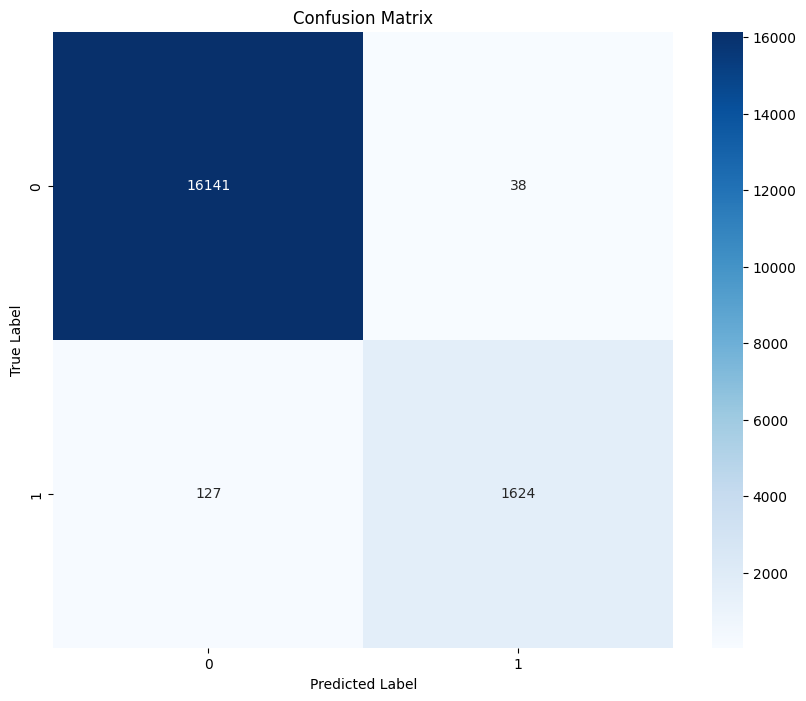


Accuracy: 0.9908


In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get predictions
y_pred = best_model.predict(dtest)

# Convert GPU arrays to CPU numpy arrays for evaluation
y_test_cpu = y_test.values.get()
y_pred_cpu = y_pred

# Print evaluation metrics
print("\nClassification Report:")
print(classification_report(y_test_cpu, y_pred_cpu))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_cpu, y_pred_cpu))

# Visualize confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_cpu, y_pred_cpu)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate and print accuracy
accuracy = (y_pred_cpu == y_test_cpu).mean()
print(f"\nAccuracy: {accuracy:.4f}")